### This notebook implements attempt of Interpretation KAN:
1. Squeezing input curve to 5 values.
2. KAN fitting on data of 4 component task with squeezed input data. Predicting 1 component=ion.
3. Using different seeds to investigate several fitted activation functions.
4. Disable low value connetions (set them as 0).
5. Post fitting model and analyzing results.

Attention: In this notebook version of pykan=0.2.7

---
Functions, that are used in this notebook, are written in modules:
* raw_data_processing.py
* tools.py

In [1]:
import os
import sys
import numpy as np
import pandas as pd
from copy import deepcopy, copy

import matplotlib.pyplot as plt
import plotly
import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

import torch

from tqdm import tqdm

project_dir = os.path.dirname(os.path.dirname(os.path.abspath('__file__')))
sys.path.append(project_dir)
from raw_data_processing import get_x, get_y, get_wavelength
from tools import JSON_Read, plotly_multi_scatter
from tools import KAN_es_2 as KAN_es
from tools import lmdKAN_es, importance_analyse_lmdKAN
SCRIPT_DIR = os.path.abspath('')


def get_sqz_input(x_axis, y_axis):
    ''' Evaluate squeezed data from curve.
    '''
    i_max = np.argmax(y_axis)
    I = y_axis[i_max]  # Max I
    c_I = x_axis[i_max]  # Coordinate of max I

    diff_I = np.absolute(y_axis-I/2)
    c_I2_left = x_axis[ np.argmin(diff_I[:i_max]) ]  # Left I/2 coordinate
    c_I2_right = x_axis[ np.argmin(diff_I[i_max:])+i_max]  # Right I/2 coordinate

    c_I2 = np.mean([c_I2_left, c_I2_right])  # Mean center coordinate on I/2 
    disp_I2 = np.abs(c_I2_right-c_I2_left)  # Width of curve on I/2 y-level

    integr_ratio = np.sum(y_axis[i_max+1:]) / np.sum(y_axis[:i_max])

    sqz_input = [I, c_I, c_I2, disp_I2, integr_ratio]
    
    
    return sqz_input

def get_all_sqz_input(matr_x, matr_y):
    matr_sqz_input = []
    for x_axis, y_axis in zip(matr_x, matr_y):
        matr_sqz_input.append(get_sqz_input(x_axis, y_axis))


    return np.array(matr_sqz_input)

def scatter_prediction_skl(model, 
                           x, 
                           y_true, 
                           title = ""):
    """Evaluates MSE and R^2 of model. 
    Draws scatter plot of (y_true, y_predicted).
    Returns  (mse, r2)
    """
    y_pred = model.predict(x)
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    fig, ax = plt.subplots(figsize=(5,5))
    plt.plot(y_true, y_pred, 'o', markersize=4, alpha = 0.8) 
    plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], markersize=2, alpha = 0.5, color='r') 
    ax.set_title(f"MSE={round(float(mse), 3)} | RMSE={round(float(mse)**0.5, 3)} | R2={round(float(r2), 3)} | {title}")
    ax.set_xlabel("y_true")
    ax.set_ylabel("y_pred")
    plt.show()

    
    return mse, r2

d_config = JSON_Read("", "json_config.txt")
EXCITE_WAVE_LENGTH = d_config['EXCITE_WAVE_LENGTH']
PREDICT_IONS = ['Cr']# ['Cr'], ['Cu'], ['Ni'], ['NO3']# d_config['PREDICT_IONS']
SPEC_FOLDER = d_config['SPEC_FOLDER']

TRAIN_TEST_RATIO = d_config['TRAIN_TEST_RATIO']
VALIDATION_TRAIN_RATIO = d_config['VALIDATION_TRAIN_RATIO']
N_ITER_NO_CHANGE = d_config['N_ITER_NO_CHANGE']

HIDDEN_LAYER_SIZES = d_config['HIDDEN_LAYER_SIZES']
ACTIVATION = d_config['ACTIVATION']
SOLVER = d_config['SOLVER']
MAX_ITER = d_config['MAX_ITER']

x = get_x(wave_length=EXCITE_WAVE_LENGTH, spec_file=project_dir+'\\'+SPEC_FOLDER)
#y = get_y(l_ions=PREDICT_IONS, spec_file=""+SPEC_FOLDER)

l_wavelenth = get_wavelength(spec_file=project_dir+'\\'+SPEC_FOLDER)

x_matrix, y_matrix = np.broadcast_to(l_wavelenth, (len(x), len(l_wavelenth))), x.to_numpy()
x = get_all_sqz_input(x_matrix, y_matrix)

In [3]:
from sklearn.base import RegressorMixin, BaseEstimator, _fit_context
from sklearn.utils.validation import check_is_fitted


class lmdKANRegressor(RegressorMixin, BaseEstimator):
    """Sci-kit learn wrapper for pykan model.
    
    Hierarchical inheritance chain of classes:
    1. pykan.kan --> 
    2. --> KAN_es: pykan.kan with early stopping, made as in skl.neural_network.MLPRegressor -->
    3. --> KANRegressor: pykan.kan wrapped in (RegressorMixin, BaseEstimator) for compatibility with skl interface.
           Uses params, inspired by skl.neural_network.MLPRegressor params logic.
    """

    # This is a dictionary allowing to define the type of parameters.
    # It used to validate parameter within the `_fit_context` decorator.
    
    _parameter_constraints = {}
    
    _d_solver_translation = {
        'lbfgs': 'LBFGS',
        'adam': 'Adam'
    }

    def __init__(self, 
                 # kan.__init__ args
                 hidden_layer_sizes=None,
                 grid=3,
                 k=3,
                 seed=1,
                 device='cpu',
                 # kan.train_es args
                 tol=1e-3,
                 n_iter_no_change=10,
                 solver='lbfgs',
                 max_iter=100,
                 learning_rate_init=1.0,
                 validation_fraction=0.1,
                 # additional kan.__init__ args
                 mult_arity = 2, noise_scale=0.3, scale_base_mu=0.0, scale_base_sigma=1.0, base_fun='silu', symbolic_enabled=True, affine_trainable=False, grid_eps=0.02, grid_range=[-1, 1], sp_trainable=True, sb_trainable=True, save_act=True, sparse_init=False, auto_save=True, first_init=True, ckpt_path='./model', state_id=0, round=0,
                 lmd_init_vector=None, lmd_init_mu=0.0, lmd_init_sigma=1.0, lmd_trainable=True,
                 # additional kan.train_es args
                 log=1, lamb=0., lamb_l1=1., lamb_entropy=2., lamb_coef=0., lamb_coefdiff=0., update_grid=True, grid_update_num=10, loss_fn=None, start_grid_update_step=-1, stop_grid_update_step=50, batch=-1, metrics=None, singularity_avoiding=False, save_fig=False, in_vars=None, out_vars=None, beta=3, save_fig_freq=1, img_folder='./video',  y_th=1000., reg_metric='edge_forward_spline_n', display_metrics=None
                 ):
        '''
        Init method. Saving all kan.__init__ and kan.fit args.
        
        Args:
        -----
            -- kan.__init__ parameteres --
            hidden_layer_sizes : list
                the ith element represents the number of neurons in the ith hidden layer.
            grid : int
                number of grid intervals. Default: 3.
            k : int
                order of piecewise polynomial. Default: 3.
            mult_arity : int, or list of int lists
                multiplication arity for each multiplication node (the number of numbers to be multiplied)
            noise_scale : float
                initial injected noise to spline.
            base_fun : str
                the residual function b(x). Default: 'silu'
            symbolic_enabled : bool
                compute (True) or skip (False) symbolic computations (for efficiency). By default: True. 
            affine_trainable : bool
                affine parameters are updated or not. Affine parameters include node_scale, node_bias, subnode_scale, subnode_bias
            grid_eps : float
                When grid_eps = 1, the grid is uniform; when grid_eps = 0, the grid is partitioned using percentiles of samples. 0 < grid_eps < 1 interpolates between the two extremes.
            grid_range : list/np.array of shape (2,))
                setting the range of grids. Default: [-1,1]. This argument is not important if fit(update_grid=True) (by default updata_grid=True)
            sp_trainable : bool
                If true, scale_sp is trainable. Default: True.
            sb_trainable : bool
                If true, scale_base is trainable. Default: True.
            device : str
                device
            seed : int
                random seed
            save_act : bool
                indicate whether intermediate activations are saved in forward pass
            sparse_init : bool
                sparse initialization (True) or normal dense initialization. Default: False.
            auto_save : bool
                indicate whether to automatically save a checkpoint once the model is modified
            state_id : int
                the state of the model (used to save checkpoint)
            ckpt_path : str
                the folder to store checkpoints. Default: './model'
            round : int
                the number of times rewind() has been called
            
            -- kan.train_es parameteres --
            tol : float
                Delta of validation fit which doesn`t count as fitness improvement. (Tolerence of training).
            n_iter_no_change : int
                Number of iteration with no fit change to early stopping.
            solver : str
                "lbfgs" or "adam"
            max_iter : int
                training steps
            learning_rate_init: float
                learning rate
            log : int
                logging frequency
            lamb : float
                overall penalty strength
            lamb_l1 : float
                l1 penalty strength
            lamb_entropy : float
                entropy penalty strength
            lamb_coef : float
                coefficient magnitude penalty strength
            lamb_coefdiff : float
                difference of nearby coefficits (smoothness) penalty strength
            update_grid : bool
                If True, update grid regularly before stop_grid_update_step
            grid_update_num : int
                the number of grid updates before stop_grid_update_step
            stop_grid_update_step : int
                no grid updates after this training step
            batch : int
                batch size, if -1 then full.
            small_mag_threshold : float
                threshold to determine large or small numbers (may want to apply larger penalty to smaller numbers)
            small_reg_factor : float
                penalty strength applied to small factors relative to large factos
            save_fig_freq : int
                save figure every (save_fig_freq) step
        '''
        
        self.hidden_layer_sizes, self.grid, self.k, self.seed, self.device = hidden_layer_sizes, grid, k, seed, device
        self.mult_arity, self.noise_scale, self.scale_base_mu, self.scale_base_sigma, self.base_fun, self.symbolic_enabled, self.affine_trainable, self.grid_eps, self.grid_range, self.sp_trainable, self.sb_trainable, self.save_act, self.sparse_init, self.auto_save, self.first_init, self.ckpt_path, self.state_id, self.round = mult_arity, noise_scale, scale_base_mu, scale_base_sigma, base_fun, symbolic_enabled, affine_trainable, grid_eps, grid_range, sp_trainable, sb_trainable, save_act, sparse_init, auto_save, first_init, ckpt_path, state_id, round
        self.lmd_init_vector, self.lmd_init_mu, self.lmd_init_sigma, self.lmd_trainable = lmd_init_vector, lmd_init_mu, lmd_init_sigma, lmd_trainable
        
        self.tol, self.n_iter_no_change, self.solver, self.max_iter, self.learning_rate_init, self.validation_fraction = tol, n_iter_no_change, solver, max_iter, learning_rate_init, validation_fraction
        self.log, self.lamb, self.lamb_l1, self.lamb_entropy, self.lamb_coef, self.lamb_coefdiff, self.update_grid, self.grid_update_num, self.loss_fn, self.start_grid_update_step, self.stop_grid_update_step, self.batch, self.metrics, self.singularity_avoiding, self.save_fig, self.in_vars, self.out_vars, self.beta, self.save_fig_freq, self.img_folder, self.y_th, self.reg_metric, self.display_metrics = log, lamb, lamb_l1, lamb_entropy, lamb_coef, lamb_coefdiff, update_grid, grid_update_num, loss_fn, start_grid_update_step, stop_grid_update_step, batch, metrics, singularity_avoiding, save_fig, in_vars, out_vars, beta, save_fig_freq, img_folder, y_th, reg_metric, display_metrics
        
    @_fit_context(prefer_skip_nested_validation=True)
    def fit(self, X, y, speed=False):
        """A reference implementation of a fitting function.

        Parameters
        ----------
        X : {array-like, sparse matrix}, shape (n_samples, n_features)
            The training input samples.

        y : array-like, shape (n_samples,) or (n_samples, n_outputs)
            The target values (class labels in classification, real numbers in
            regression).

        Returns
        -------
        self : object
            Returns self.
        """
        # `_validate_data` is defined in the `BaseEstimator` class.
        # It allows to:
        # - run different checks on the input data;
        # - define some attributes associated to the input data: `n_features_in_` and
        #   `feature_names_in_`.
        
        # Make sure self.hidden_layer_sizes is a list
        hidden_layer_sizes = self.hidden_layer_sizes
        if not hasattr(hidden_layer_sizes, "__iter__"):
            hidden_layer_sizes = [hidden_layer_sizes]
        hidden_layer_sizes = list(hidden_layer_sizes)
        
        X, y = self._validate_data(X, y, accept_sparse=True)
        n_features = X.shape[1]
        
        # Ensure y is 2D
        if y.ndim == 1:
            y = y.reshape((-1, 1))
            
        if not hasattr(self, "is_fitted_"): self.is_fitted_ = False
        
        if not self.is_fitted_:
            self.n_outputs_ = y.shape[1]
        
            self.width = [n_features] + self.hidden_layer_sizes + [self.n_outputs_]
            self.kan = lmdKAN_es(width=self.width, grid=self.grid, k=self.k, seed=self.seed, device=self.device,
                                 mult_arity=self.mult_arity, noise_scale=self.noise_scale, scale_base_mu=self.scale_base_mu, scale_base_sigma=self.scale_base_sigma, base_fun=self.base_fun, symbolic_enabled=self.symbolic_enabled, affine_trainable=self.affine_trainable, grid_eps=self.grid_eps, grid_range=self.grid_range, sp_trainable=self.sp_trainable, sb_trainable=self.sb_trainable, save_act=self.save_act, sparse_init=self.sparse_init, auto_save=self.auto_save, first_init=self.first_init, ckpt_path=self.ckpt_path, state_id=self.state_id, round=self.round,
                                 lmd_init_vector=self.lmd_init_vector, lmd_init_mu=self.lmd_init_mu, lmd_init_sigma=self.lmd_init_sigma, lmd_trainable=self.lmd_trainable)
        
        if speed: self.kan.speed()
        
        X_train, X_val, y_train, y_val = train_test_split(X, y, 
                                                        test_size=self.validation_fraction,
                                                        random_state=self.seed)
                    
        kan_dataset = {'train_input': torch.tensor(np.array(X_train), dtype=torch.float),
                       'train_label': torch.tensor(np.array(y_train), dtype=torch.float),
                       'test_input': torch.tensor(np.array(X_val), dtype=torch.float),
                       'test_label': torch.tensor(np.array(y_val), dtype=torch.float)}
        
        results = self.kan.fit(kan_dataset, 
                               tol=self.tol, 
                               n_iter_no_change=self.n_iter_no_change,
                               opt=self._d_solver_translation[self.solver], 
                               lr = self.learning_rate_init,
                               steps=self.max_iter,
                               log=self.log, lamb=self.lamb, lamb_l1=self.lamb_l1, lamb_entropy=self.lamb_entropy, lamb_coef=self.lamb_coef, lamb_coefdiff=self.lamb_coefdiff, update_grid=self.update_grid, grid_update_num=self.grid_update_num, loss_fn=self.loss_fn, stop_grid_update_step=self.stop_grid_update_step, batch=self.batch, singularity_avoiding=self.singularity_avoiding, save_fig=self.save_fig, in_vars=self.in_vars, out_vars=self.out_vars, beta=self.beta, save_fig_freq=self.save_fig_freq, img_folder=self.img_folder, y_th=self.y_th, reg_metric=self.reg_metric, display_metrics=self.display_metrics
                                )
        
        self. kan.results = results
        self.is_fitted_ = True
        # `fit` should always return `self`
        return self

    def predict(self, X):
        """A reference implementation of a predicting function.

        Parameters
        ----------
        X : {array-like, sparse matrix}, shape (n_samples, n_features)
            The training input samples.

        Returns
        -------
        y : ndarray of shape (n_samples, n_outputs)
            The predicted values.
        """
        # Check if fit had been called
        check_is_fitted(self)
        # We need to set reset=False because we don't want to overwrite `n_features_in_`
        # `feature_names_in_` but only check that the shape is consistent.
        X = self._validate_data(X, accept_sparse=True, reset=False)
        
        x = torch.tensor(np.array(X), dtype=torch.float)
        pred = self.kan.forward(x).detach().numpy()
        
        return pred

# Interpretability investigation

# $Cr$

In [4]:
# PREPARING DATA + PairPlot
PREDICT_IONS = ['Cr']# ['Cr'], ['Cu'], ['Ni'], ['NO3']# d_config['PREDICT_IONS']
PREDICT_ION_NAME = '$Cr^{3+}$'
y = get_y(l_ions=PREDICT_IONS, spec_file=""+SPEC_FOLDER)


squeezed_df = pd.DataFrame(np.concatenate([x, y.reshape([-1,1])], axis=1), columns=['$I$', '$c$', '$c_h$', '$wth$', '$rat$', PREDICT_IONS[0] + ' concentration'])
#sns.pairplot(squeezed_df)

x_train, x_test, y_train, y_test = train_test_split(x, y, 
                                                    train_size=TRAIN_TEST_RATIO,
                                                    random_state=42)

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

'''
scalerY = StandardScaler()
y_train = scalerY.fit_transform(y_train.reshape(-1, 1))
y_test = scalerY.transform(y_test.reshape(-1, 1))
'''
INPUT_SHAPE = x_train.shape[1]

- seed=0 -
checkpoint directory created: ./model
saving model version 0.0


| trn_loss: 3.82e-01 | tst_loss: 3.88e-01 | e_stop: 10/10 | reg: 1.13e+01 | :  19%|▏| 19/100 [00:09<


Early stopping criteria raised
saving model version 0.1


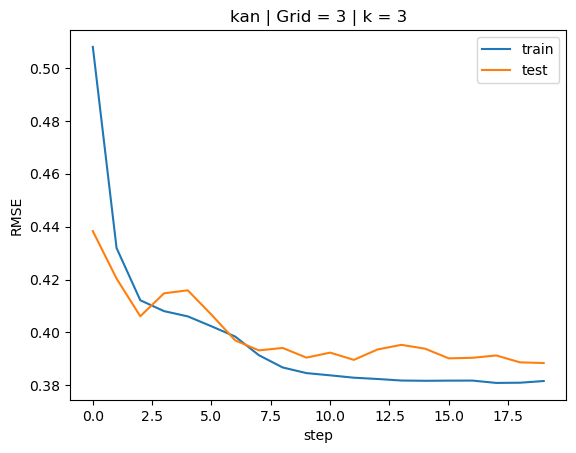

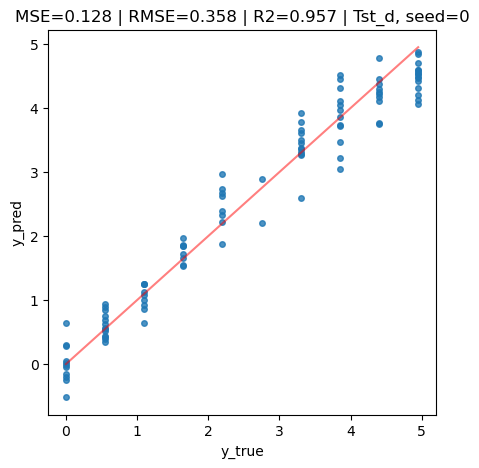

Full dataset:


ExactExplainer explainer: 1001it [00:49, 16.88it/s]                         


module of Input importance:


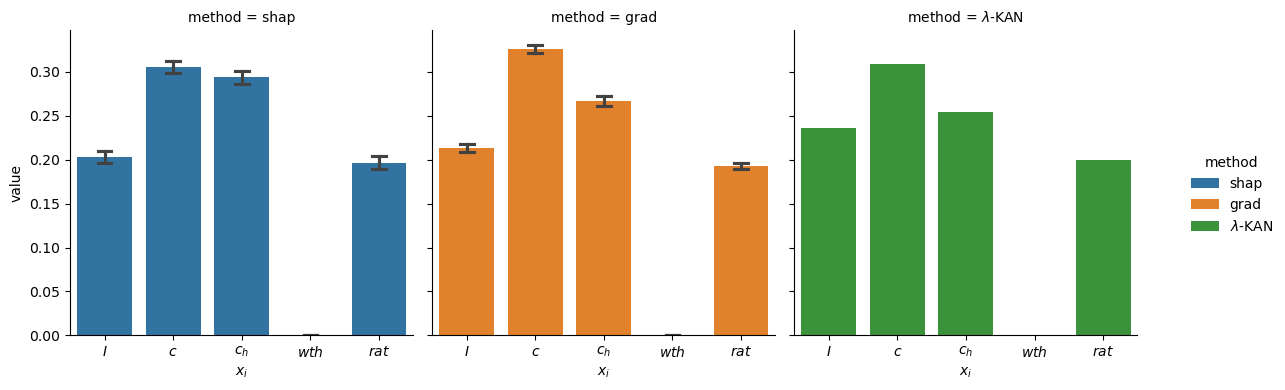

Input importance:


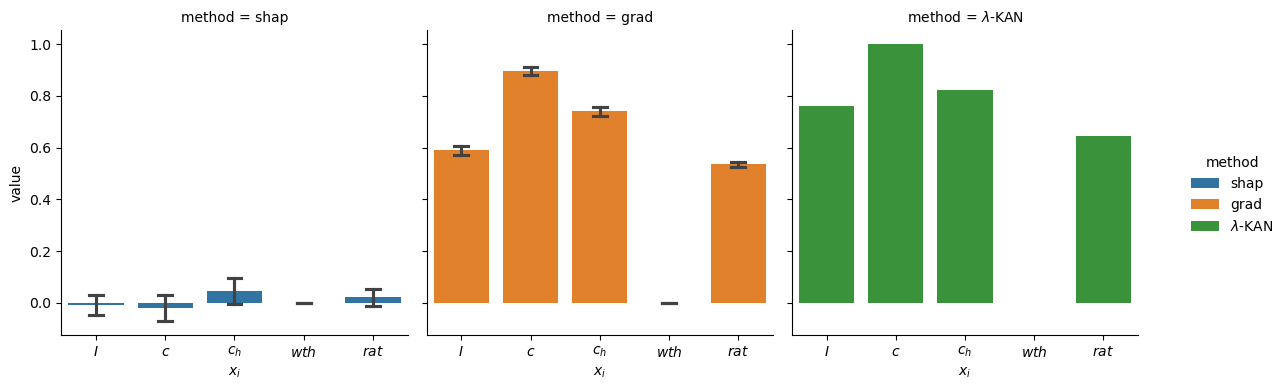

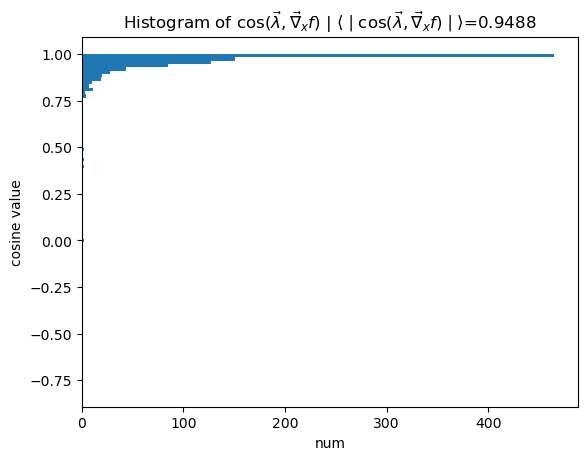

- seed=1 -
checkpoint directory created: ./model
saving model version 0.0


| trn_loss: 3.52e-01 | tst_loss: 3.82e-01 | e_stop: 10/10 | reg: 1.21e+01 | :  25%|▎| 25/100 [00:14<

Early stopping criteria raised
saving model version 0.1


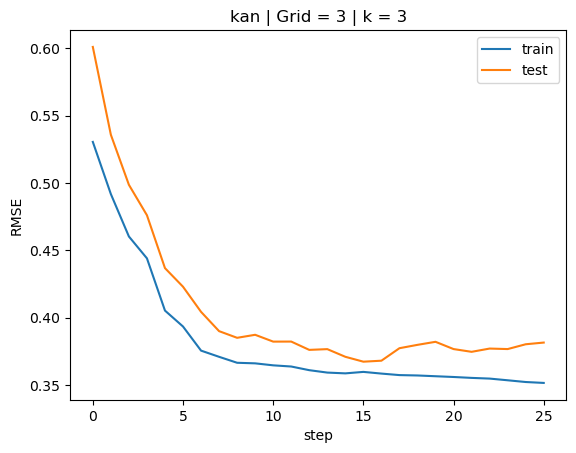

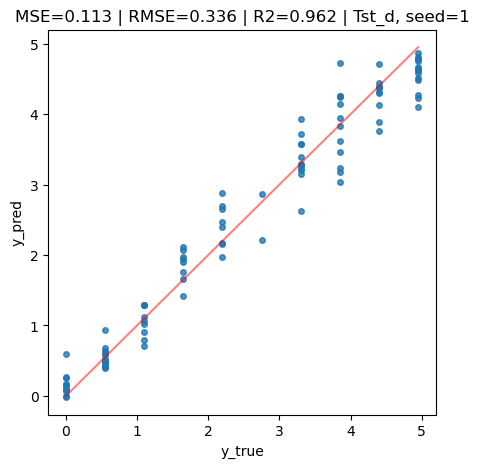

Full dataset:


ExactExplainer explainer: 1001it [00:48, 16.53it/s]                         


module of Input importance:


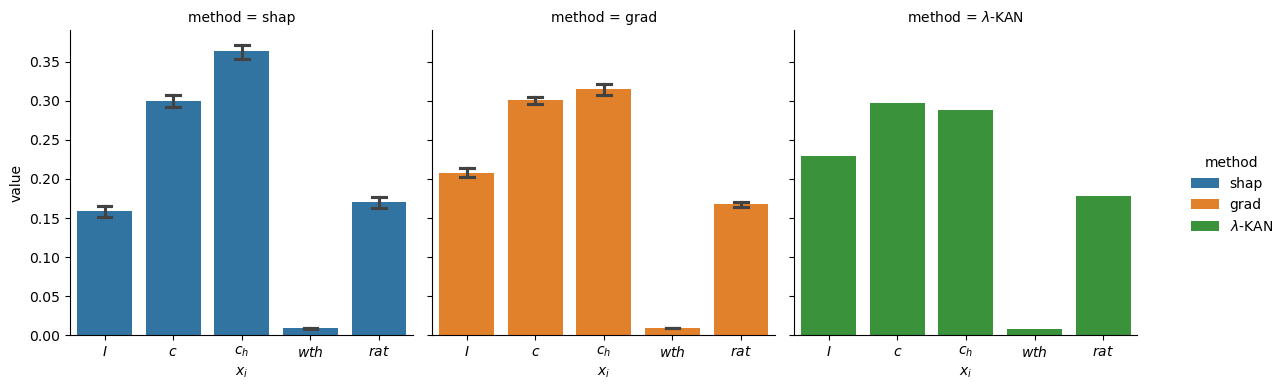

Input importance:


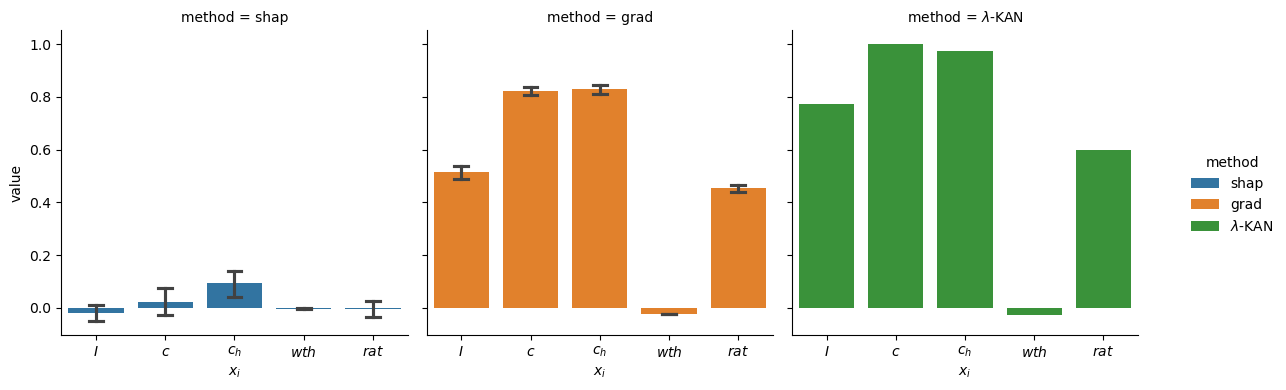

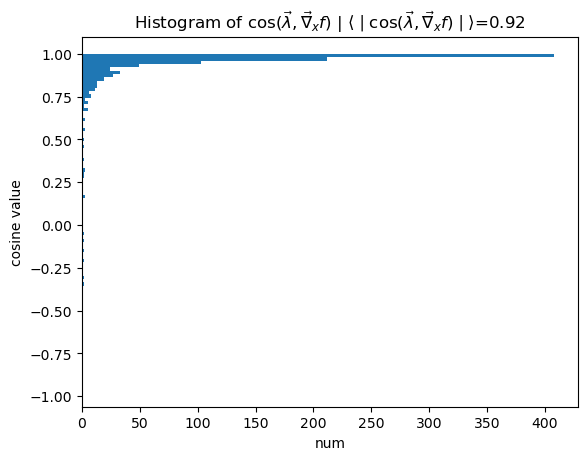

- seed=2 -
checkpoint directory created: ./model
saving model version 0.0


| trn_loss: 4.02e-01 | tst_loss: 4.22e-01 | e_stop: 10/10 | reg: 1.02e+01 | :  29%|▎| 29/100 [00:15<

Early stopping criteria raised
saving model version 0.1


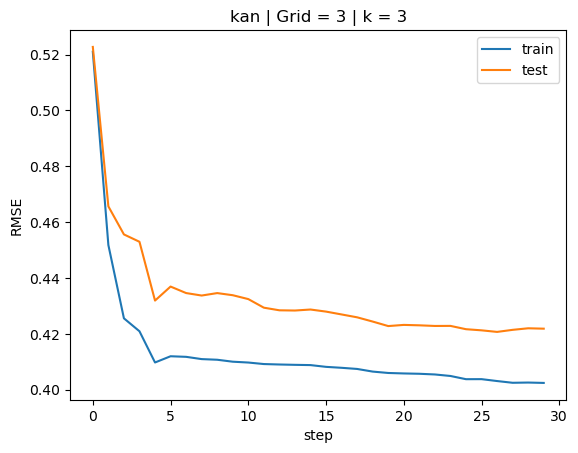

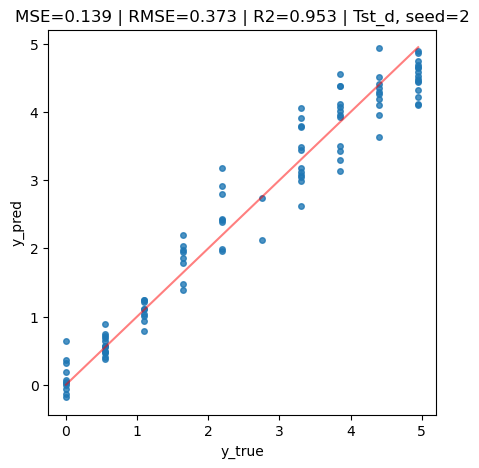

Full dataset:


ExactExplainer explainer: 1001it [00:46, 16.85it/s]                         


module of Input importance:


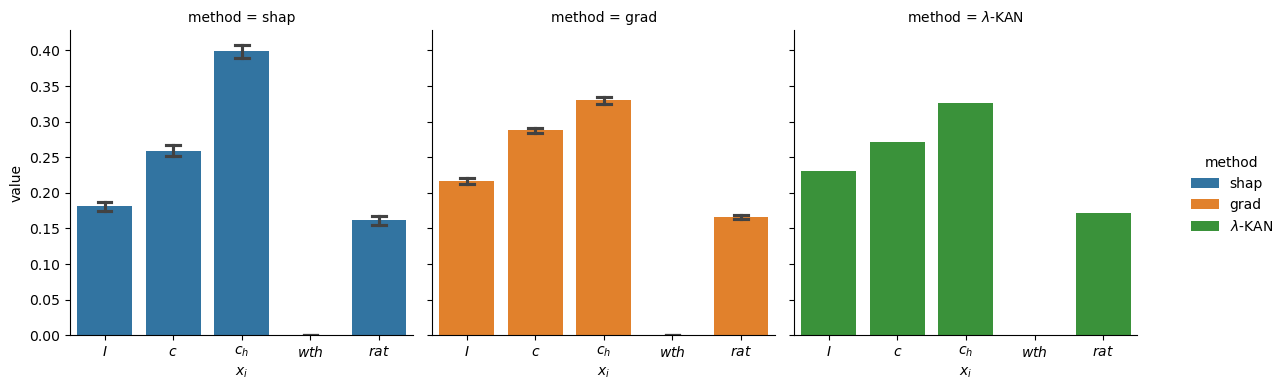

Input importance:


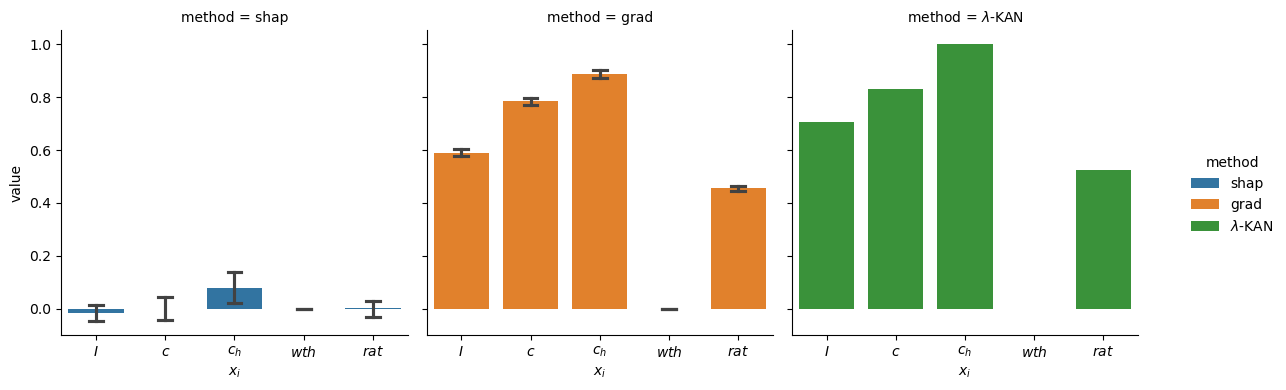

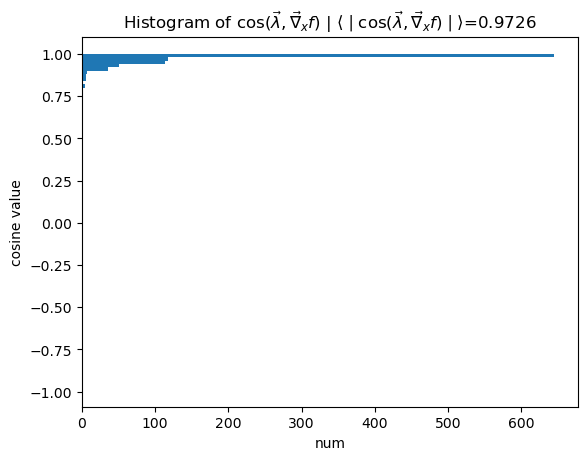

- seed=3 -
checkpoint directory created: ./model
saving model version 0.0


| trn_loss: 4.41e-01 | tst_loss: 4.27e-01 | e_stop: 10/10 | reg: 9.13e+00 | :  22%|▏| 22/100 [00:11<

Early stopping criteria raised
saving model version 0.1


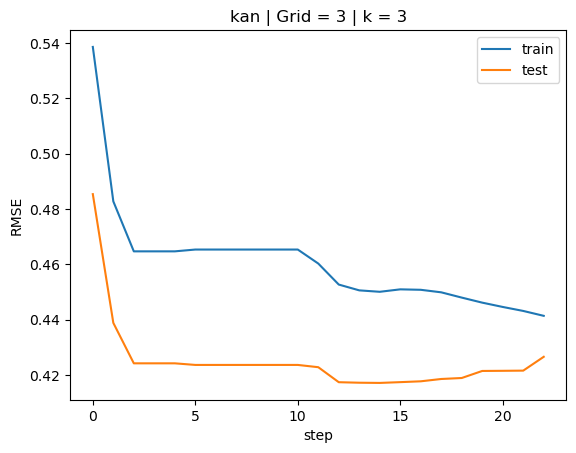

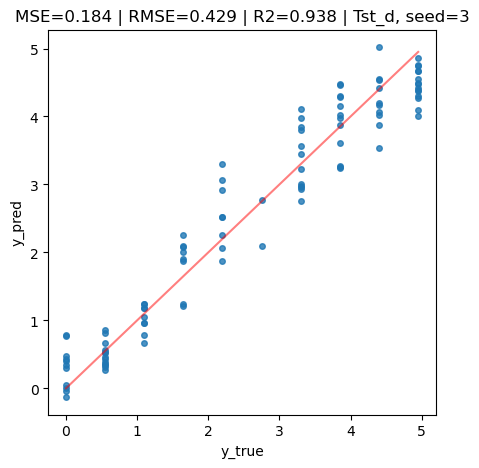

Full dataset:


ExactExplainer explainer: 1001it [00:45, 17.17it/s]                         


module of Input importance:


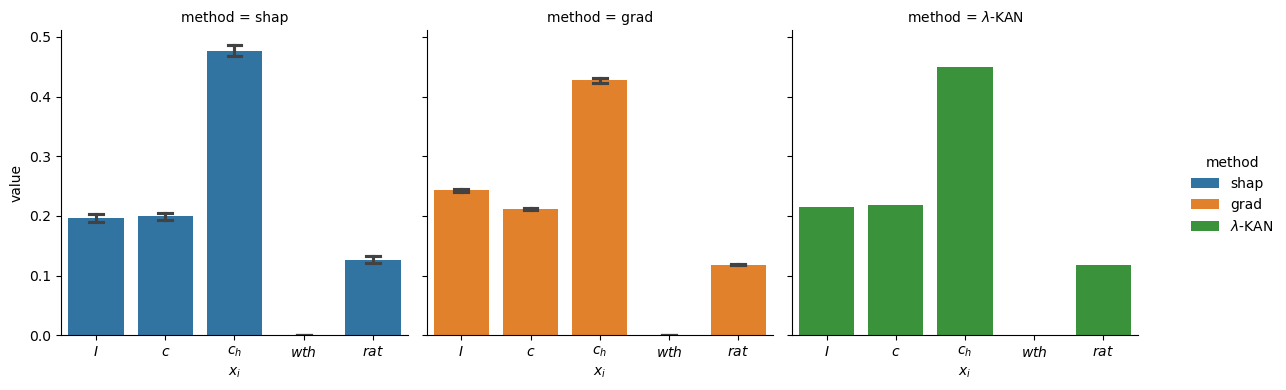

Input importance:


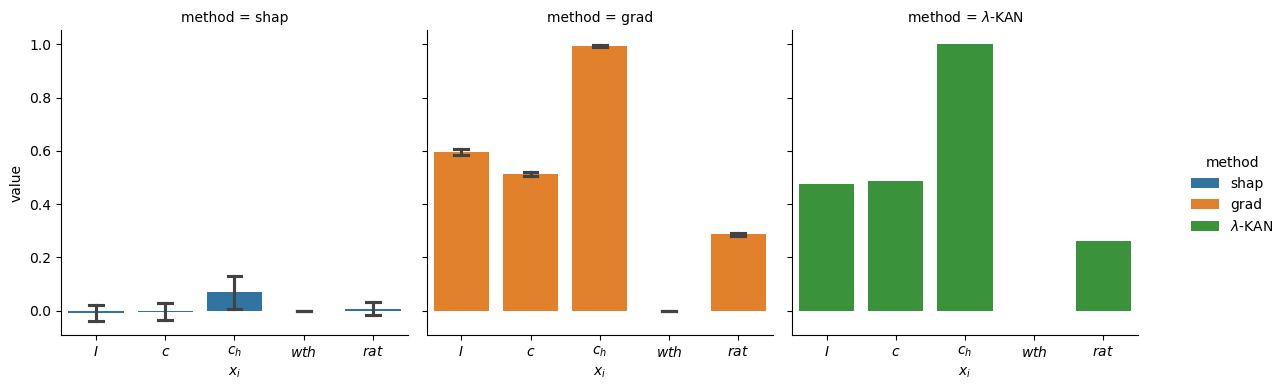

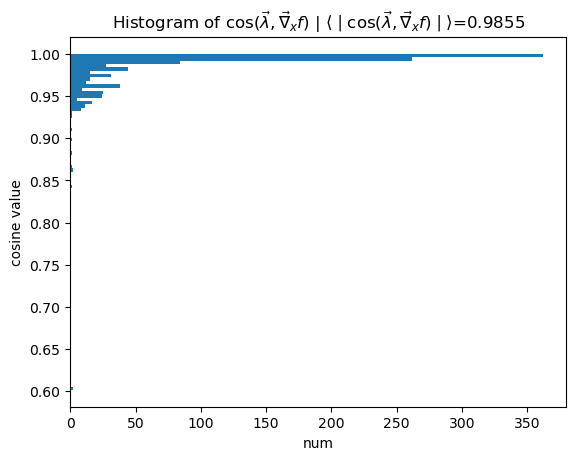

- seed=4 -
checkpoint directory created: ./model
saving model version 0.0


| trn_loss: 3.73e-01 | tst_loss: 3.50e-01 | e_stop: 10/10 | reg: 1.17e+01 | :  21%|▏| 21/100 [00:10<

Early stopping criteria raised
saving model version 0.1


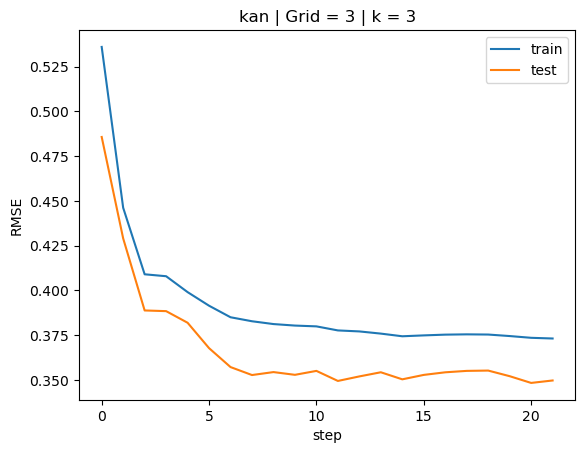

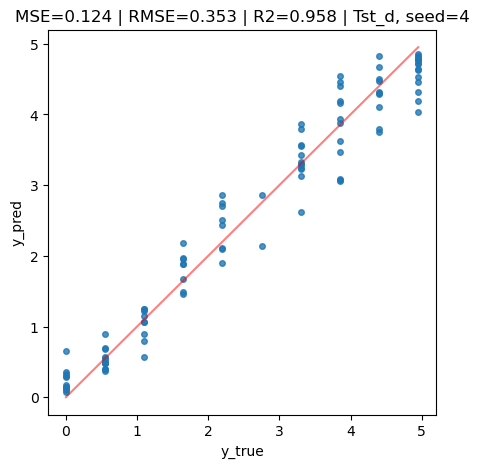

Full dataset:


ExactExplainer explainer: 1001it [00:45, 17.16it/s]                          


module of Input importance:


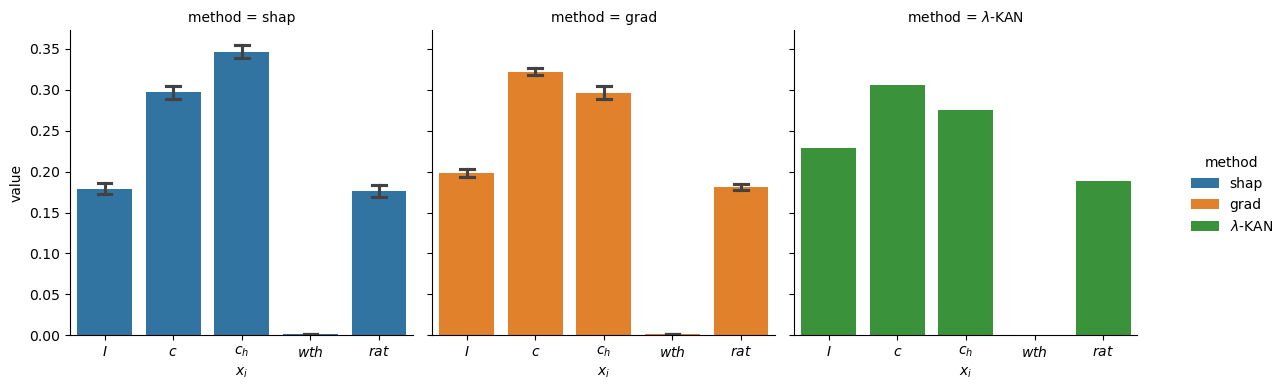

Input importance:


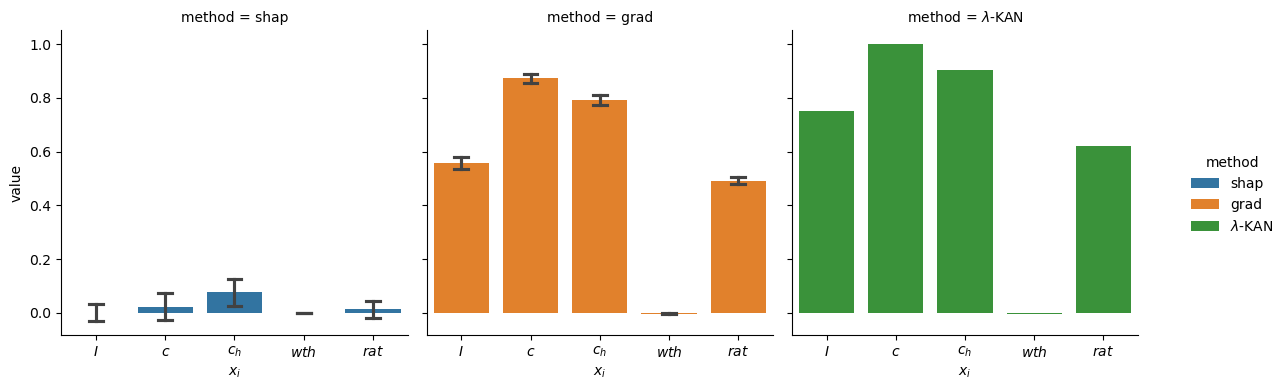

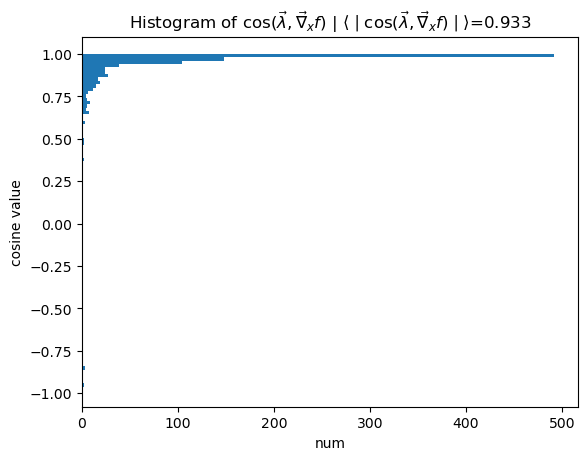

- seed=5 -
checkpoint directory created: ./model
saving model version 0.0


| trn_loss: 4.35e-01 | tst_loss: 4.19e-01 | e_stop: 10/10 | reg: 8.75e+00 | :  13%|▏| 13/100 [00:07<

Early stopping criteria raised
saving model version 0.1


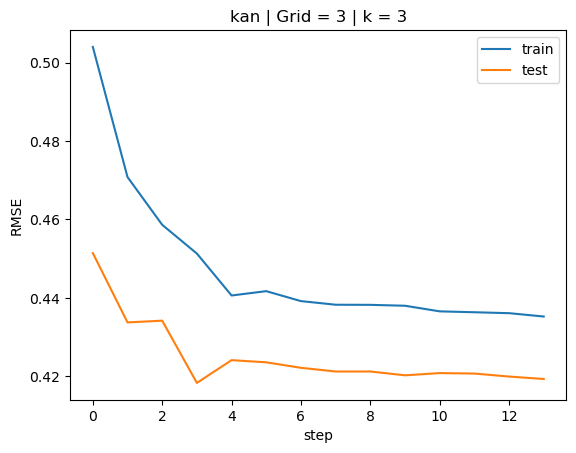

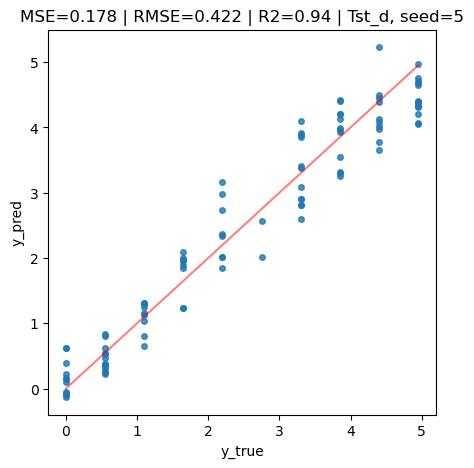

Full dataset:


ExactExplainer explainer: 1001it [00:43, 17.66it/s]                         


module of Input importance:


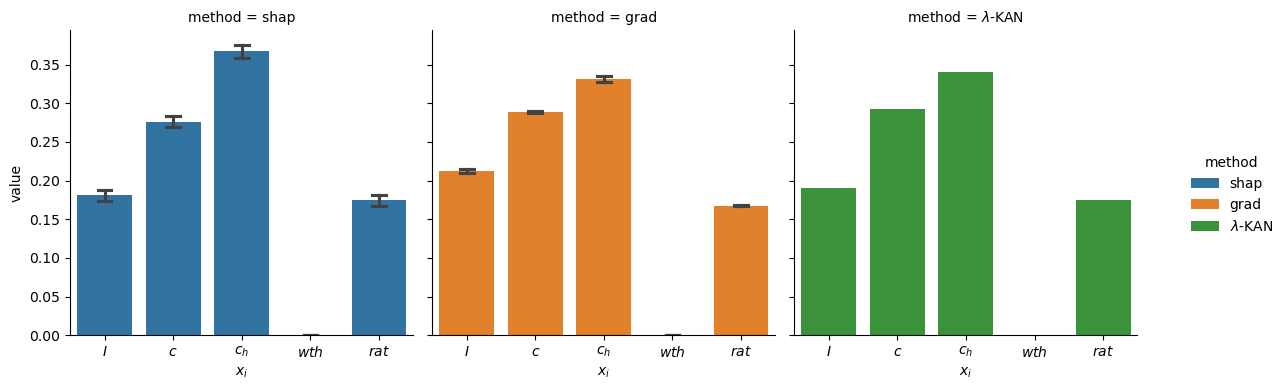

Input importance:


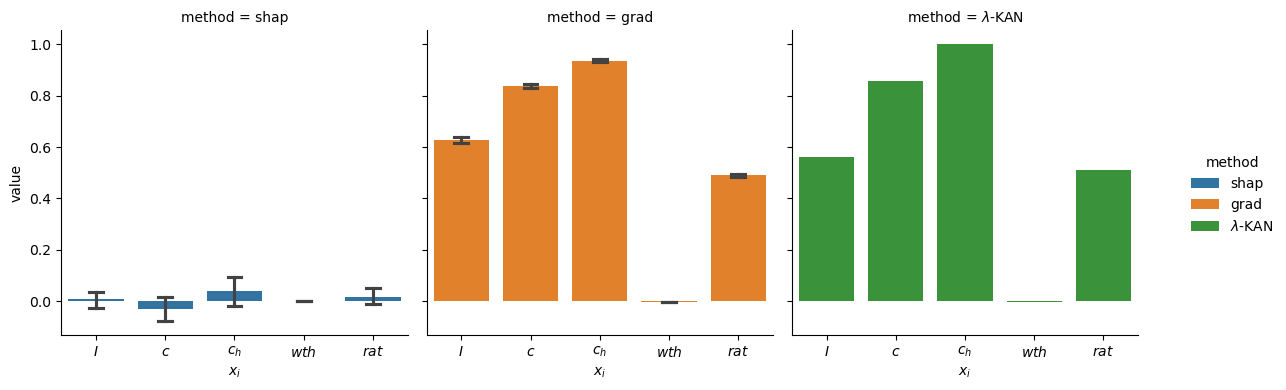

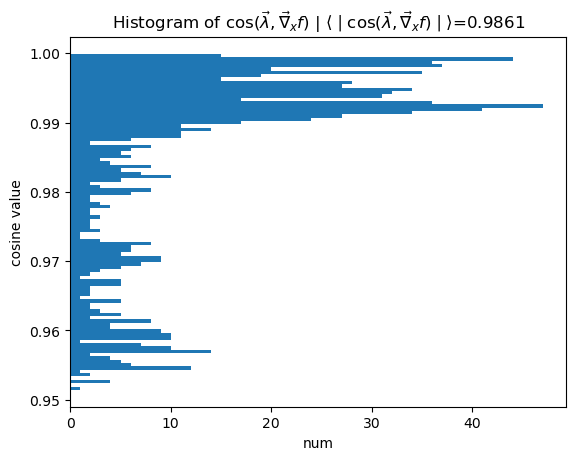

- seed=6 -
checkpoint directory created: ./model
saving model version 0.0


| trn_loss: 4.26e-01 | tst_loss: 4.57e-01 | e_stop: 10/10 | reg: 8.54e+00 | :  20%|▏| 20/100 [00:10<

Early stopping criteria raised
saving model version 0.1


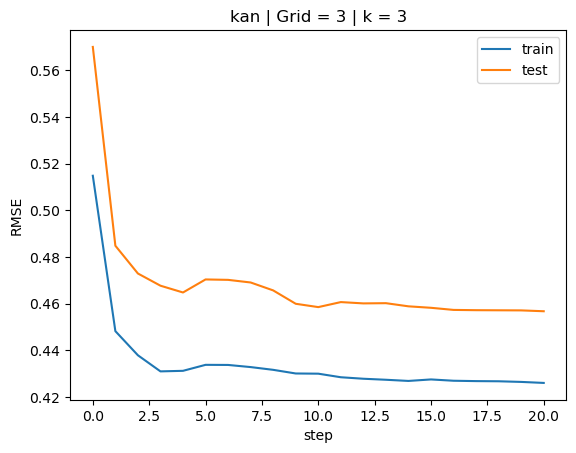

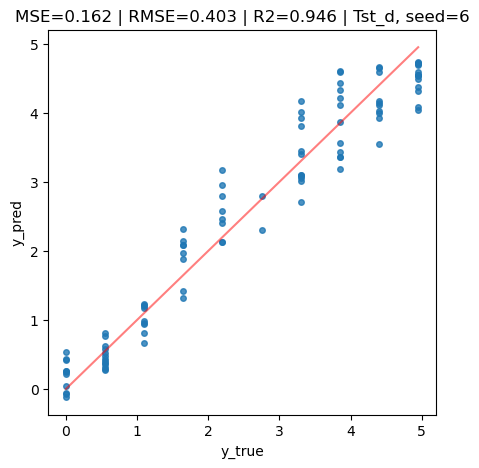

Full dataset:


ExactExplainer explainer: 1001it [00:44, 17.67it/s]                         


module of Input importance:


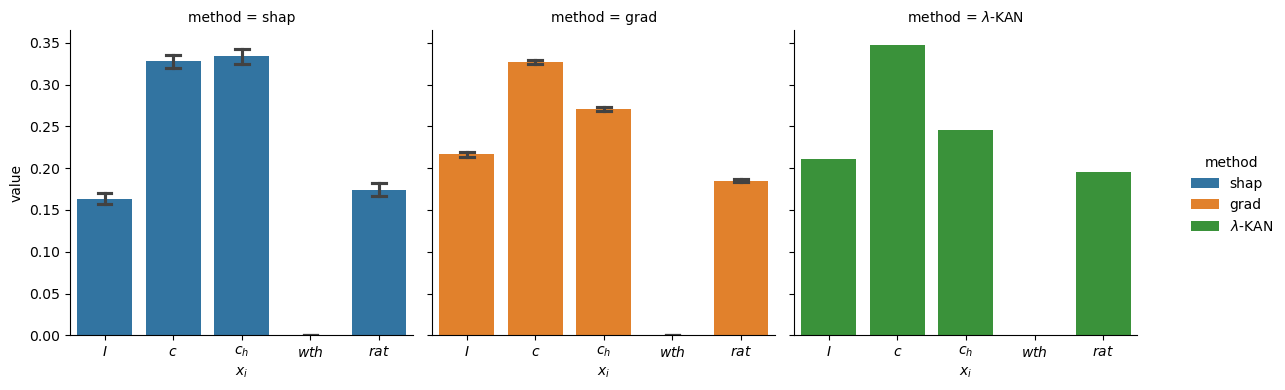

Input importance:


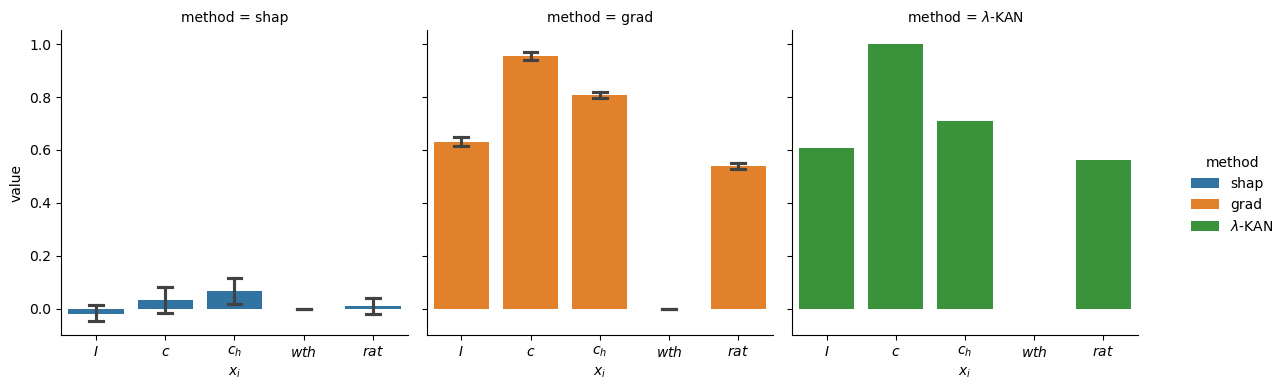

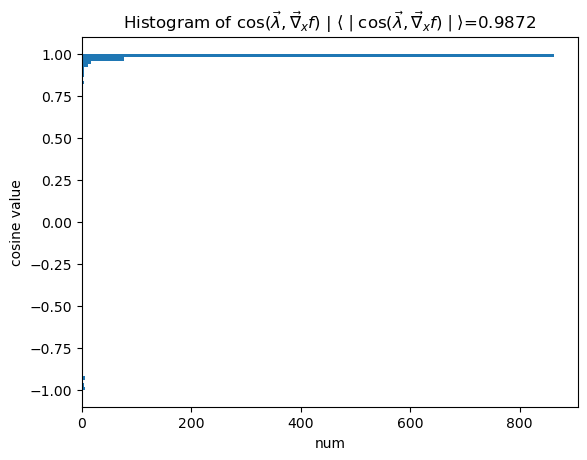

- seed=7 -
checkpoint directory created: ./model
saving model version 0.0


| trn_loss: 3.58e-01 | tst_loss: 3.62e-01 | e_stop: 10/10 | reg: 1.43e+01 | :  27%|▎| 27/100 [00:13<

Early stopping criteria raised
saving model version 0.1


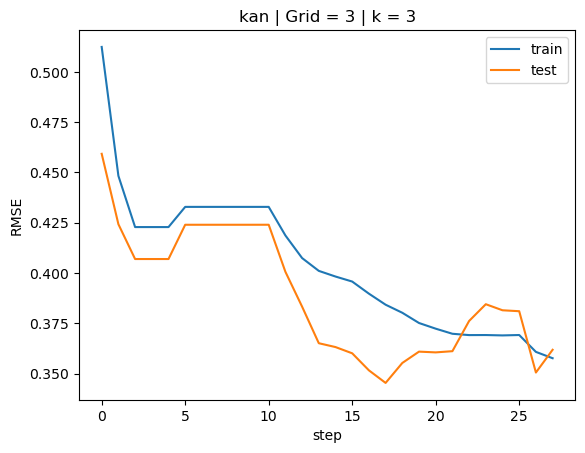

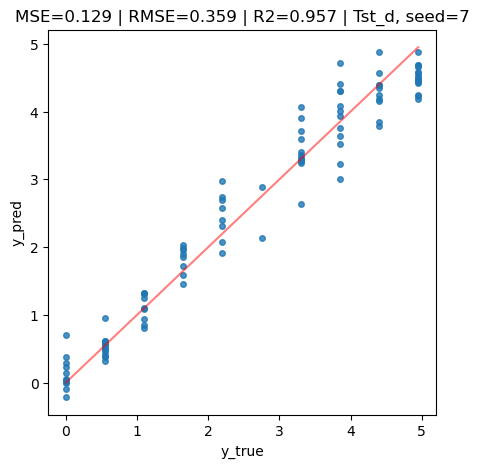

Full dataset:


ExactExplainer explainer: 1001it [00:44, 17.46it/s]                         


module of Input importance:


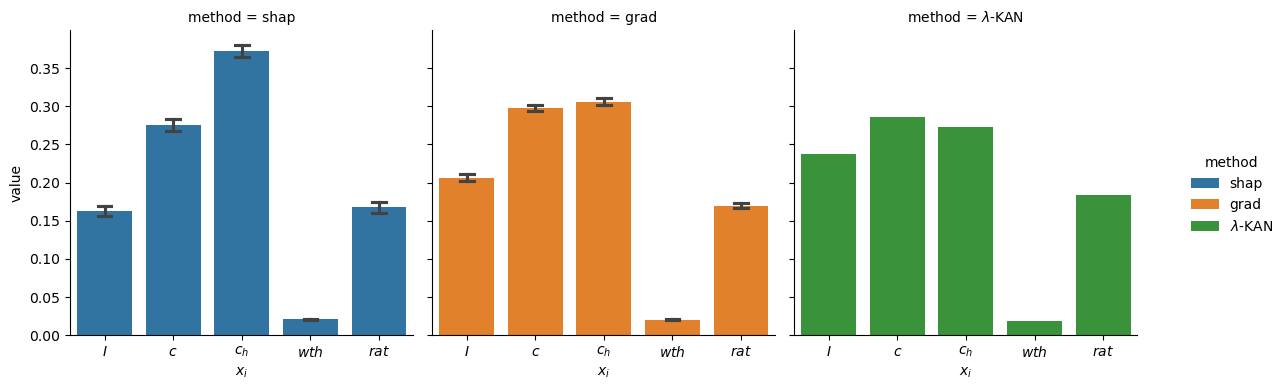

Input importance:


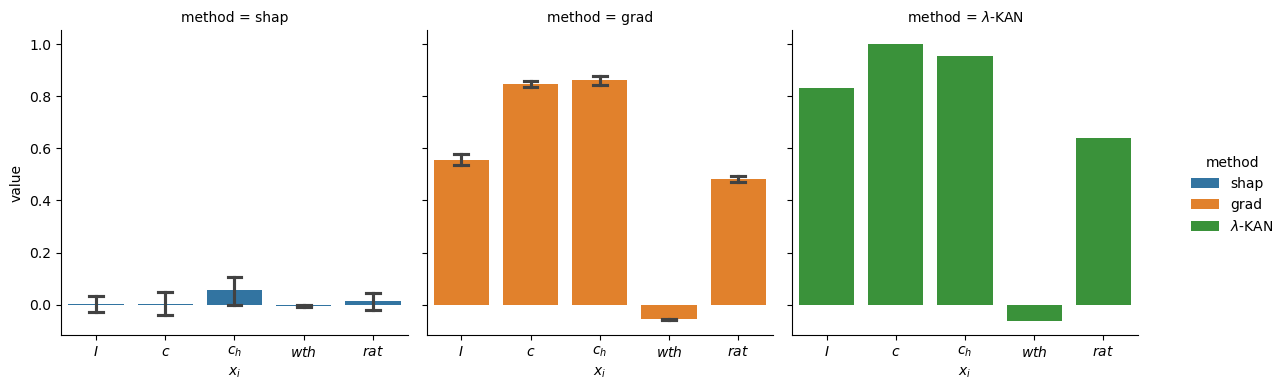

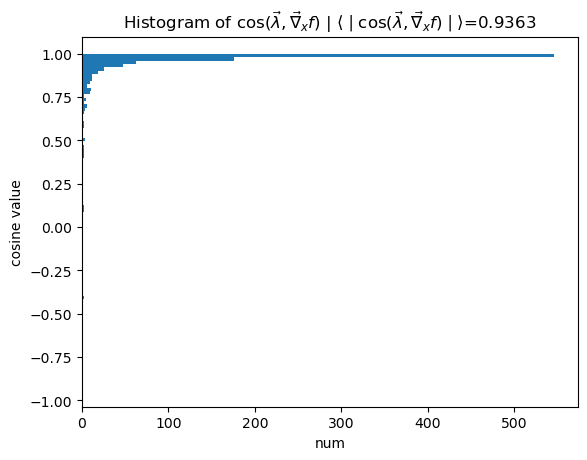

- seed=8 -
checkpoint directory created: ./model
saving model version 0.0


| trn_loss: 3.77e-01 | tst_loss: 3.12e-01 | e_stop: 10/10 | reg: 1.11e+01 | :  24%|▏| 24/100 [00:12<

Early stopping criteria raised
saving model version 0.1


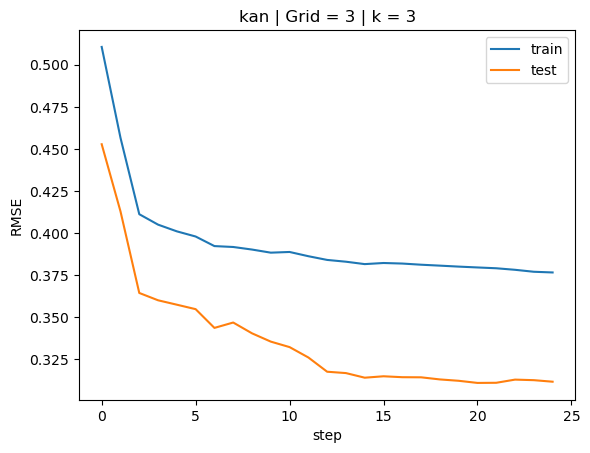

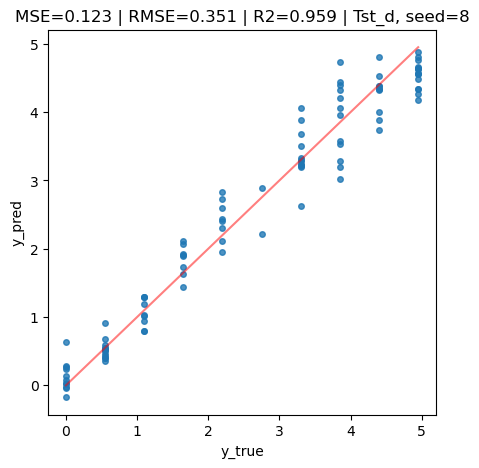

Full dataset:


ExactExplainer explainer: 1001it [00:45, 17.13it/s]                         


module of Input importance:


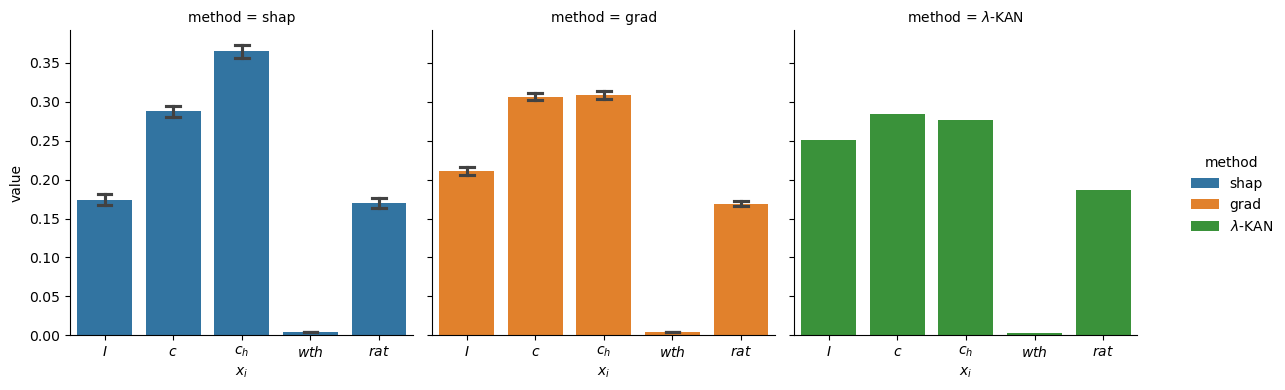

Input importance:


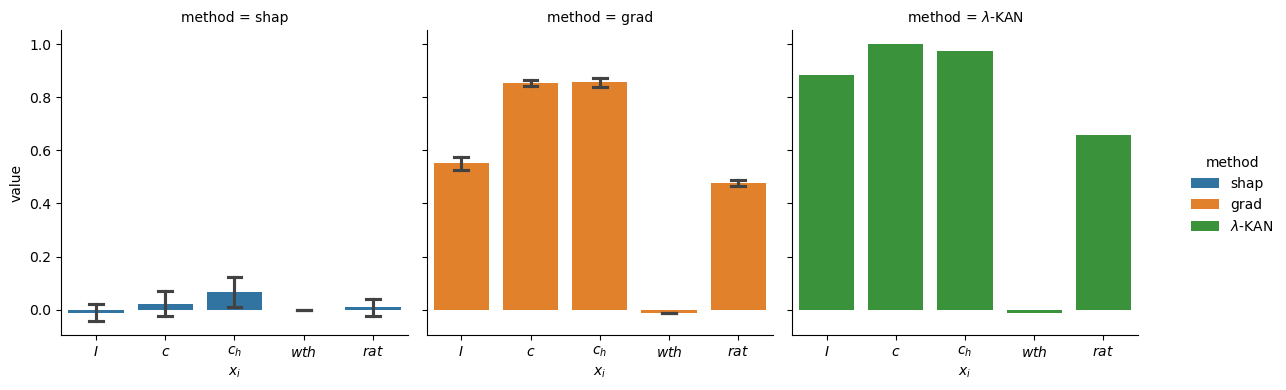

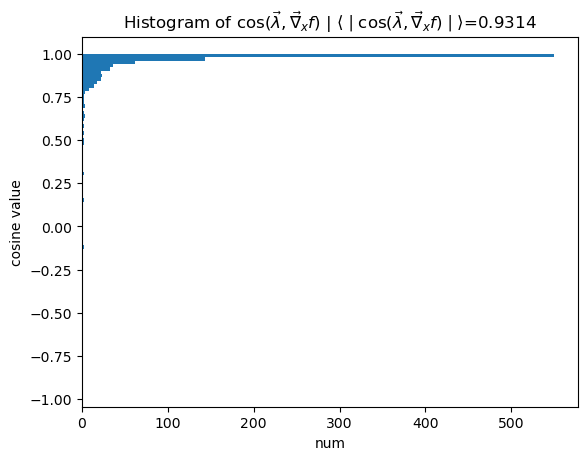

- seed=9 -
checkpoint directory created: ./model
saving model version 0.0


| trn_loss: 3.46e-01 | tst_loss: 3.91e-01 | e_stop: 10/10 | reg: 1.15e+01 | :  32%|▎| 32/100 [00:16<

Early stopping criteria raised
saving model version 0.1


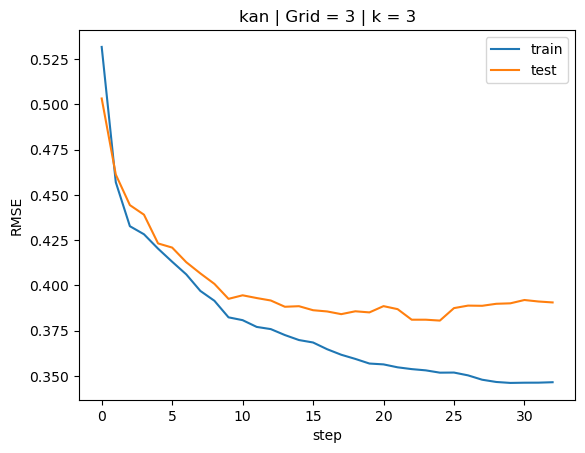

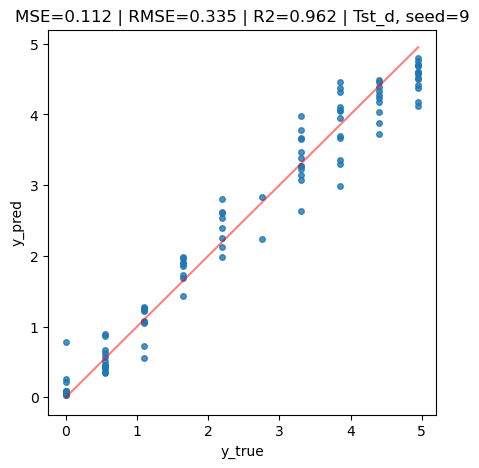

Full dataset:


ExactExplainer explainer: 1001it [00:44, 17.78it/s]                         


module of Input importance:


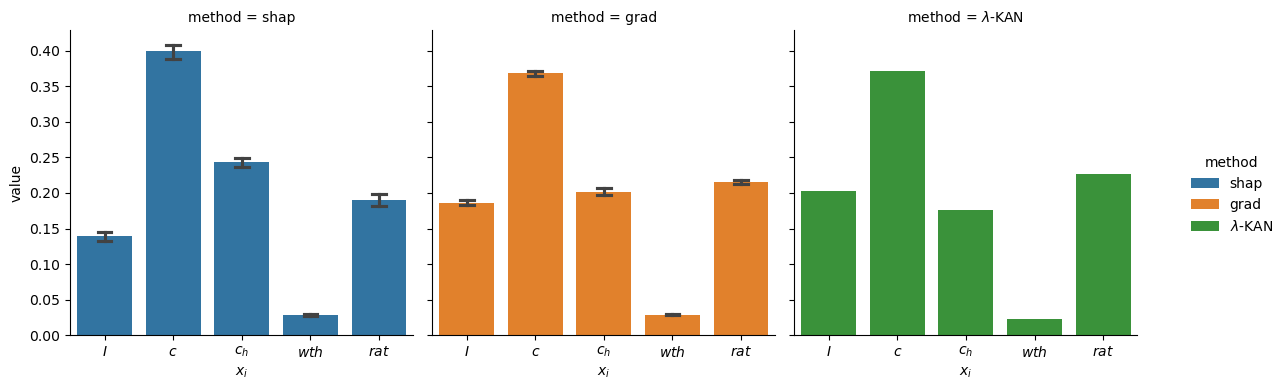

Input importance:


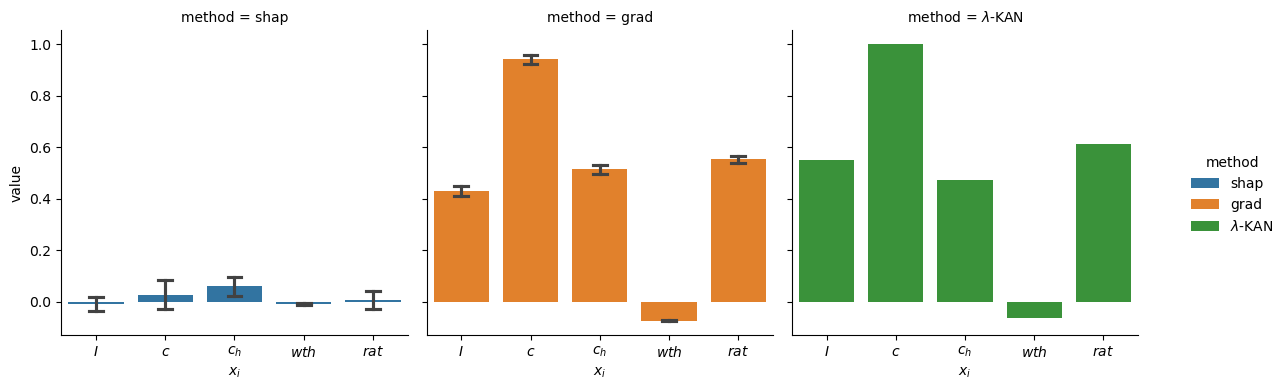

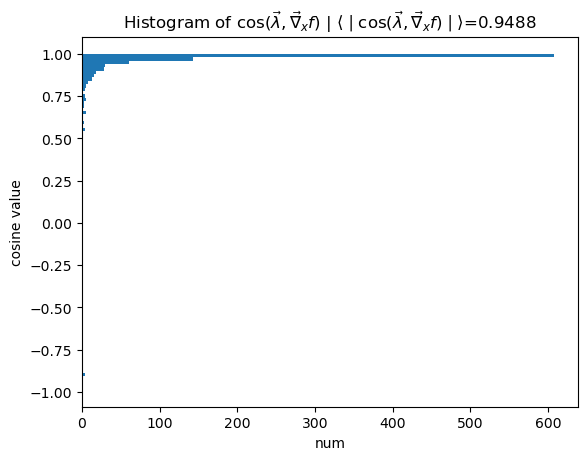

In [4]:
# FITTING KAN with different seed
l_seed = range(10)
grid = 3
k = 3

l_feature_scores = []

for seed in l_seed:
    print(f'==========\n- {seed=} -\n==========')
    model2 = lmdKANRegressor(hidden_layer_sizes=[5,2], seed=seed, grid=3, k=3, 
                       solver="lbfgs", max_iter=100, 
                       lamb=1e-2,
                       lamb_l1=1,
                       lamb_entropy=2)
    
    model2.fit(x_train, y_train)
    result2 = model2.kan.results
    
    #pred_test = model2.predict(x_test)
    pred_train = model2.predict(x_train)
    
    l_feature_scores.append(model2.kan.act_fun[0].lmd.detach().numpy())

    VAR = ['$I$', '$c$', '$c_h$', '$wth$', '$rat$']
    prnt_kwrgs = {'in_vars': VAR, 
                'out_vars': [PREDICT_IONS[0] + ' concentration'], 
                'title': None,
                'sample': True,
                'scale': 0.5,
                'scale_scatter': 0.5}
    
    #model2.kan.plot(**prnt_kwrgs, reper_in_out='out', reper_index=0, hist_plot=True)
    plt.show()

    plt.plot(result2['train_loss'])
    plt.plot(result2['test_loss'])
    #plt.plot(result2['reg'])
    plt.legend(['train', 'test']) #, 'reg'
    plt.title(f'kan | Grid = {grid} | k = {k}')
    plt.ylabel('RMSE')
    plt.xlabel('step')
    plt.show()

    scatter_prediction_skl(model2, x_test, y_test, f"Tst_d, seed={seed}")

    print('Full dataset:')
    importance_analyse_lmdKAN(model2.kan, dict(test_input=torch.tensor(scaler.transform(x), dtype=torch.float)))

    plt.show()
    
l_feature_scores = np.array(l_feature_scores)

In [5]:
l_feature_scores

array([[ 7.0922893e-01,  9.3122101e-01,  7.6582515e-01, -1.1754523e-03,
         6.0164028e-01],
       [ 8.8246572e-01,  1.1411180e+00,  1.1098226e+00, -2.9486371e-02,
         6.8384373e-01],
       [ 7.1077883e-01,  8.3763367e-01,  1.0088986e+00, -3.0893402e-04,
         5.3045619e-01],
       [ 7.0264274e-01,  7.1734989e-01,  1.4728643e+00, -2.9585935e-06,
         3.8616616e-01],
       [ 6.0870361e-01,  8.1118202e-01,  7.3189723e-01, -2.4959235e-03,
         5.0250947e-01],
       [ 5.8448720e-01,  8.9587080e-01,  1.0441976e+00, -2.5111143e-03,
         5.3496039e-01],
       [ 7.5990921e-01,  1.2537390e+00,  8.8732606e-01, -2.2501308e-03,
         7.0490438e-01],
       [ 6.6352630e-01,  7.9822046e-01,  7.6130962e-01, -5.1601544e-02,
         5.1115078e-01],
       [ 6.0140741e-01,  6.8071687e-01,  6.6243720e-01, -8.6197508e-03,
         4.4668561e-01],
       [ 4.4072193e-01,  8.0382478e-01,  3.8026351e-01, -5.0704788e-02,
         4.9056369e-01]], dtype=float32)

- seed=0 -
checkpoint directory created: ./model
saving model version 0.0


| trn_loss: 3.82e-01 | tst_loss: 3.88e-01 | e_stop: 10/10 | reg: 1.13e+01 | :  19%|▏| 19/100 [00:10<


Early stopping criteria raised
saving model version 0.1


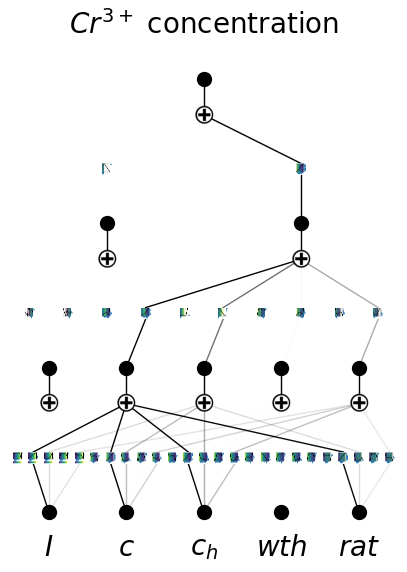

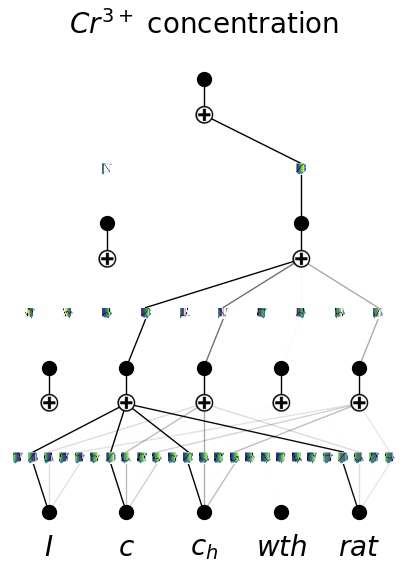

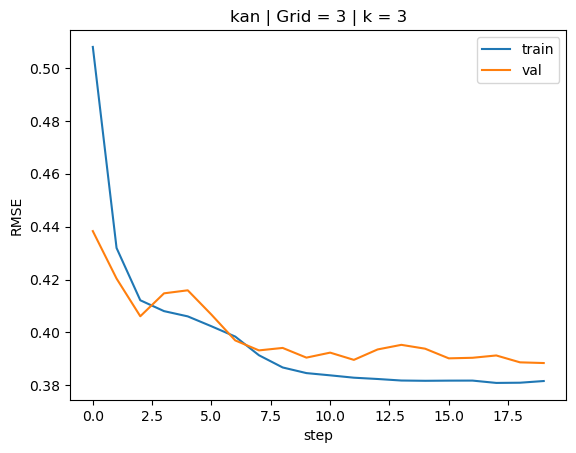

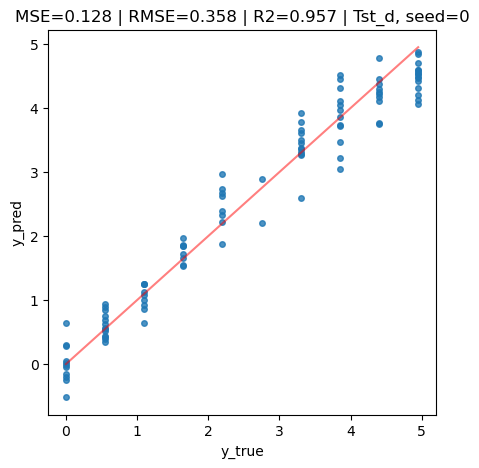

Full dataset:


ExactExplainer explainer: 1001it [00:47, 17.94it/s]                         


module of Input importance:


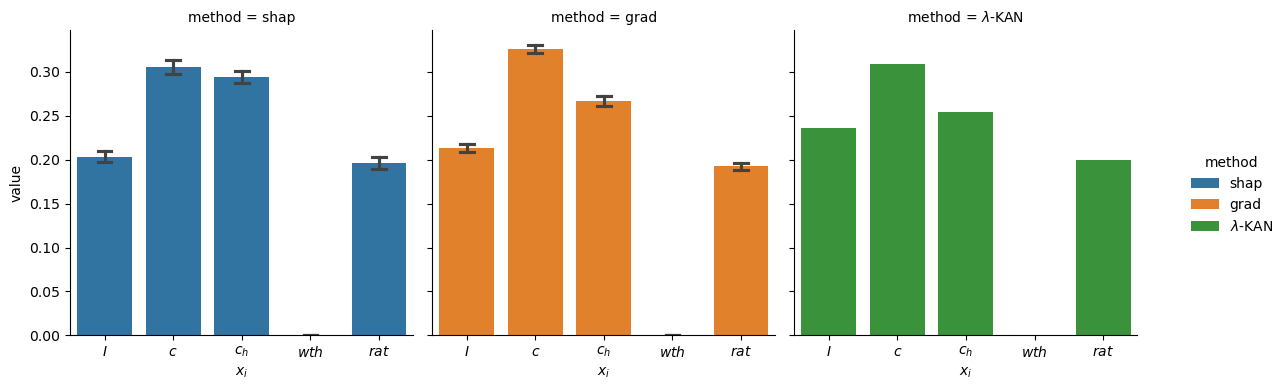

Input importance:


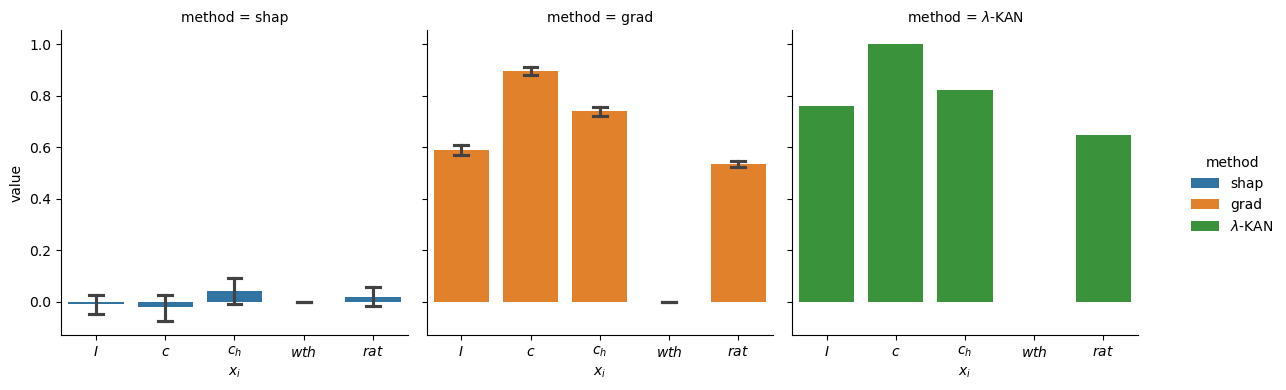

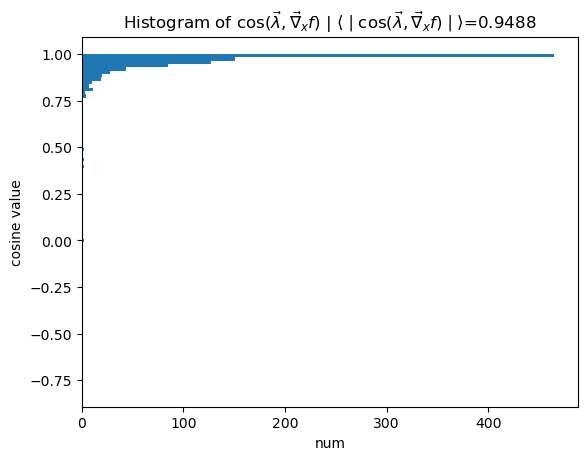

In [5]:
grid = 3
k = 3

# Choose seed and train again
seed = 0
print(f'==========\n- {seed=} -\n==========')
model2 = lmdKANRegressor(hidden_layer_sizes=[5,2,], seed=seed, grid=grid, k=k, 
                   solver="lbfgs", max_iter=100, 
                   lamb=1e-2,
                   lamb_l1=1,
                   lamb_entropy=2)

model2.fit(x_train, y_train)
result2 = model2.kan.results

#pred_test = model2.predict(x_test)
pred_train = model2.predict(x_train)
VAR = ['$I$', '$c$', '$c_h$', '$wth$', '$rat$']
prnt_kwrgs = {'in_vars': VAR, 
            'out_vars': [PREDICT_ION_NAME + ' concentration'], 
            'title': None,
            'sample': True,
            'scale': 0.5,
            'scale_scatter': 0.5}

model2.kan.plot(**prnt_kwrgs, reper_in_out='in', reper_index=0, hist_plot=True)
model2.kan.plot(**prnt_kwrgs, reper_in_out='out', reper_index=0, hist_plot=True)
plt.show()
plt.plot(result2['train_loss'])
plt.plot(result2['test_loss'])
#plt.plot(result2['reg'])
plt.legend(['train', 'val']) #, 'reg'
plt.title(f'kan | Grid = {grid} | k = {k}')
plt.ylabel('RMSE')
plt.xlabel('step')
plt.show()
scatter_prediction_skl(model2, x_test, y_test, f"Tst_d, seed={seed}")
print('Full dataset:')
importance_analyse_lmdKAN(model2.kan, dict(test_input=torch.tensor(scaler.transform(x), dtype=torch.float)))
plt.show()

# $Cu$

In [6]:
# PREPARING DATA + PairPlot
PREDICT_IONS = ['Cu']# ['Cr'], ['Cu'], ['Ni'], ['NO3']# d_config['PREDICT_IONS']
PREDICT_ION_NAME = '$Cu^{2+}$'
y = get_y(l_ions=PREDICT_IONS, spec_file=""+SPEC_FOLDER)


squeezed_df = pd.DataFrame(np.concatenate([x, y.reshape([-1,1])], axis=1), columns=['$I$', '$c$', '$c_h$', '$wth$', '$rat$', PREDICT_IONS[0] + ' concentration'])
#sns.pairplot(squeezed_df)

x_train, x_test, y_train, y_test = train_test_split(x, y, 
                                                    train_size=TRAIN_TEST_RATIO,
                                                    random_state=42)

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

'''
scalerY = StandardScaler()
y_train = scalerY.fit_transform(y_train.reshape(-1, 1))
y_test = scalerY.transform(y_test.reshape(-1, 1))
'''
INPUT_SHAPE = x_train.shape[1]

- seed=0 -
checkpoint directory created: ./model
saving model version 0.0


| trn_loss: 7.20e-01 | tst_loss: 8.50e-01 | e_stop: 10/10 | reg: 1.03e+01 | :  13%|▏| 13/100 [00:07<

Early stopping criteria raised
saving model version 0.1


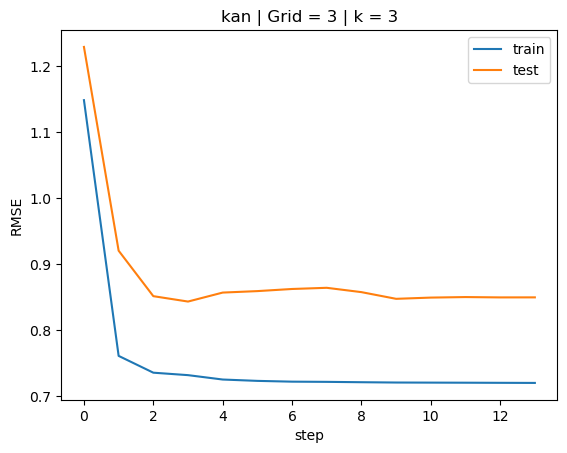

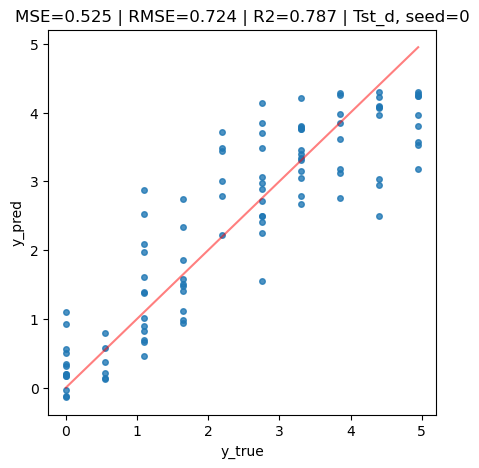

Full dataset:


ExactExplainer explainer: 1001it [00:40, 18.79it/s]                          


module of Input importance:


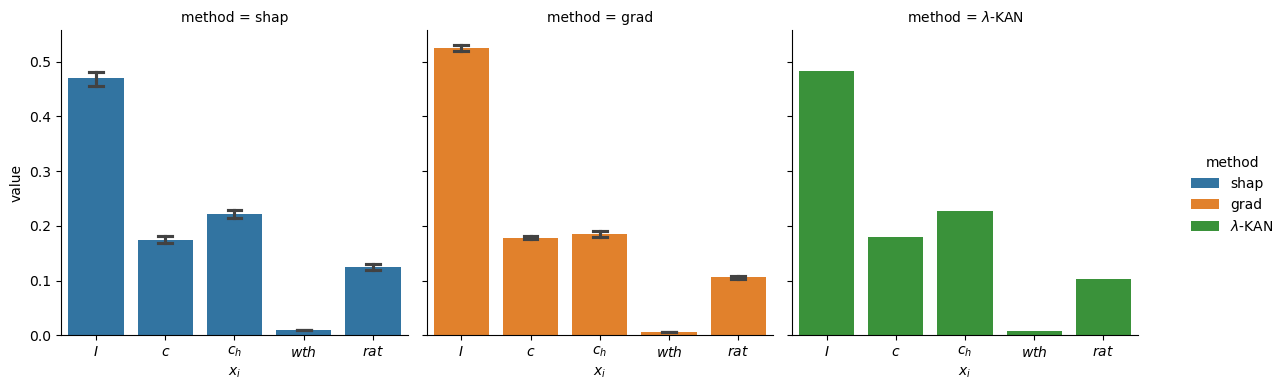

Input importance:


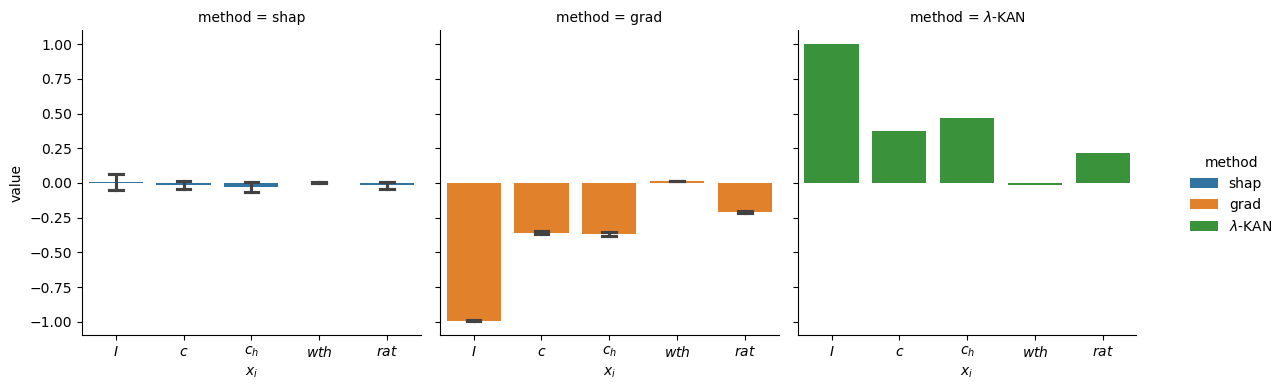

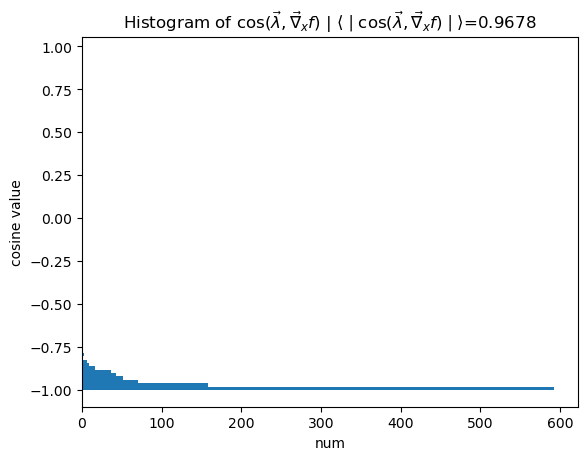

- seed=1 -
checkpoint directory created: ./model
saving model version 0.0


| trn_loss: 7.06e-01 | tst_loss: 7.65e-01 | e_stop: 10/10 | reg: 1.27e+01 | :  21%|▏| 21/100 [00:10<

Early stopping criteria raised
saving model version 0.1


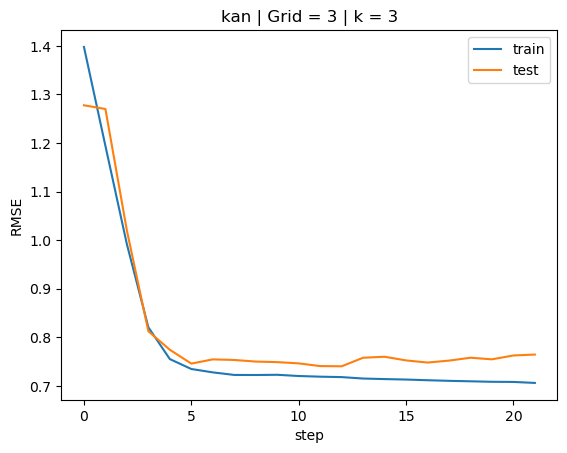

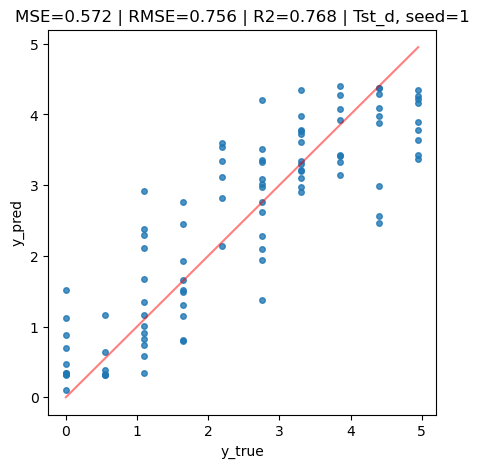

Full dataset:


ExactExplainer explainer: 1001it [00:51, 15.39it/s]                         


module of Input importance:


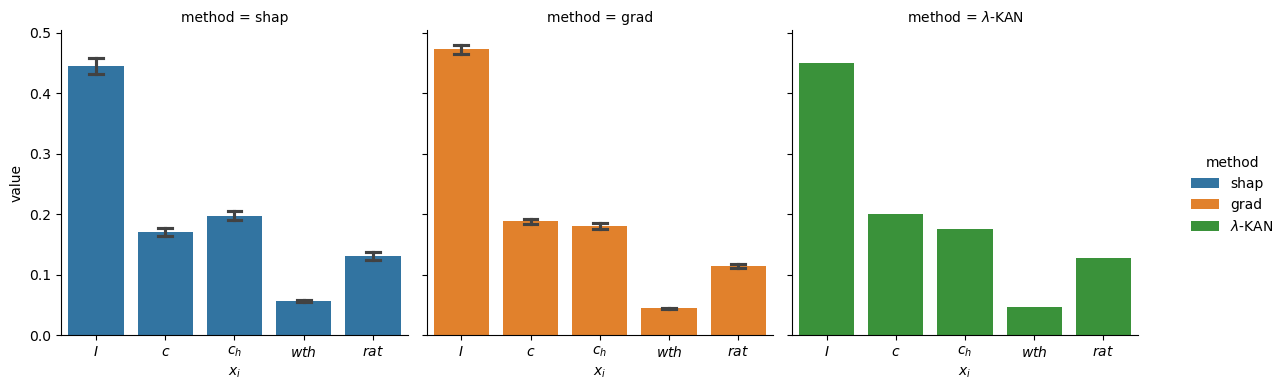

Input importance:


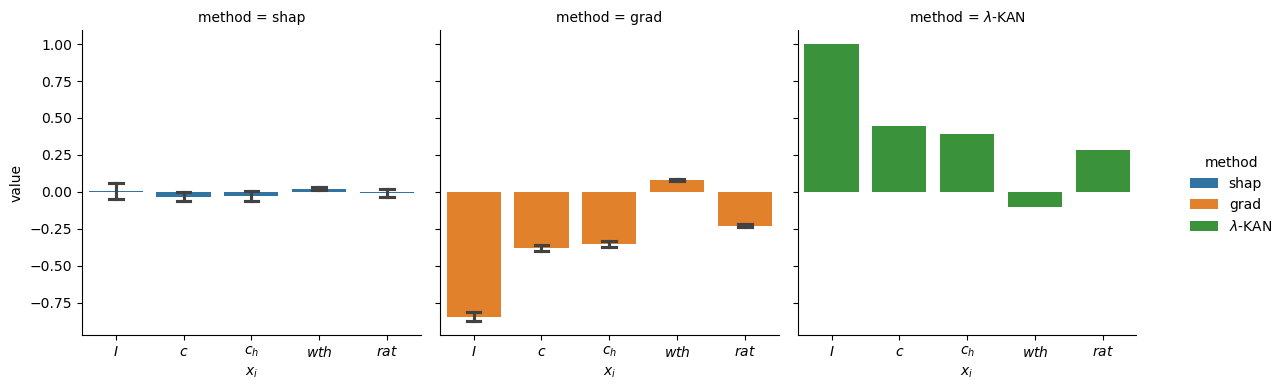

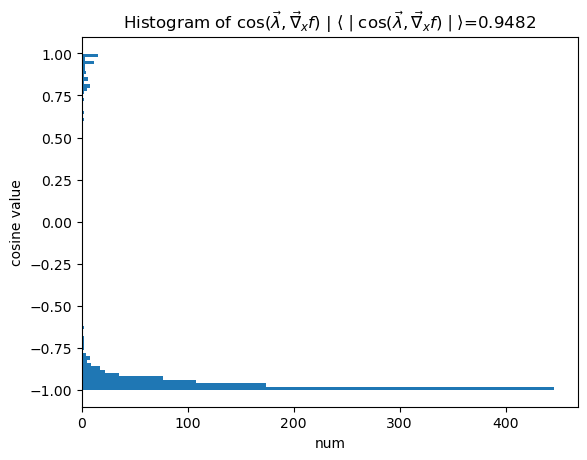

- seed=2 -
checkpoint directory created: ./model
saving model version 0.0


| trn_loss: 7.96e-01 | tst_loss: 8.45e-01 | e_stop: 10/10 | reg: 2.23e+01 | :  19%|▏| 19/100 [00:10<

Early stopping criteria raised
saving model version 0.1


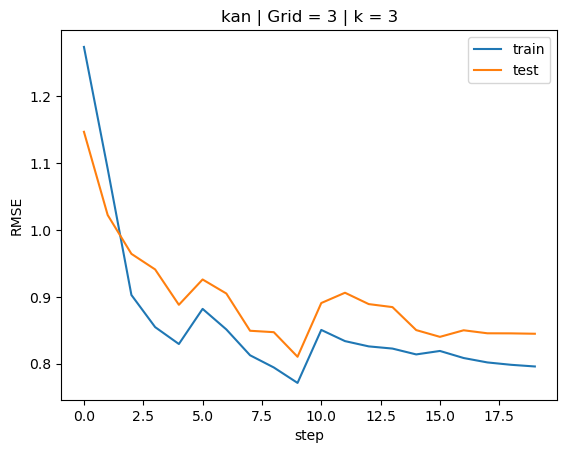

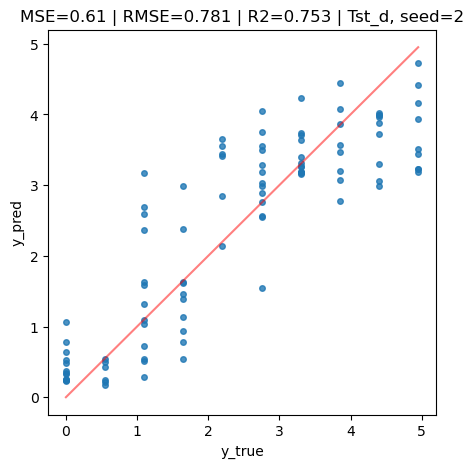

Full dataset:


ExactExplainer explainer: 1001it [00:52, 14.99it/s]                          


module of Input importance:


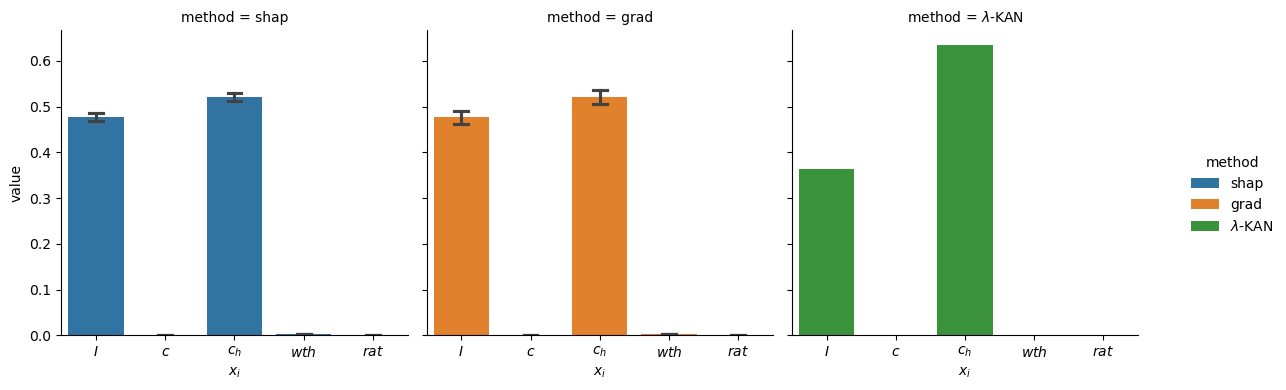

Input importance:


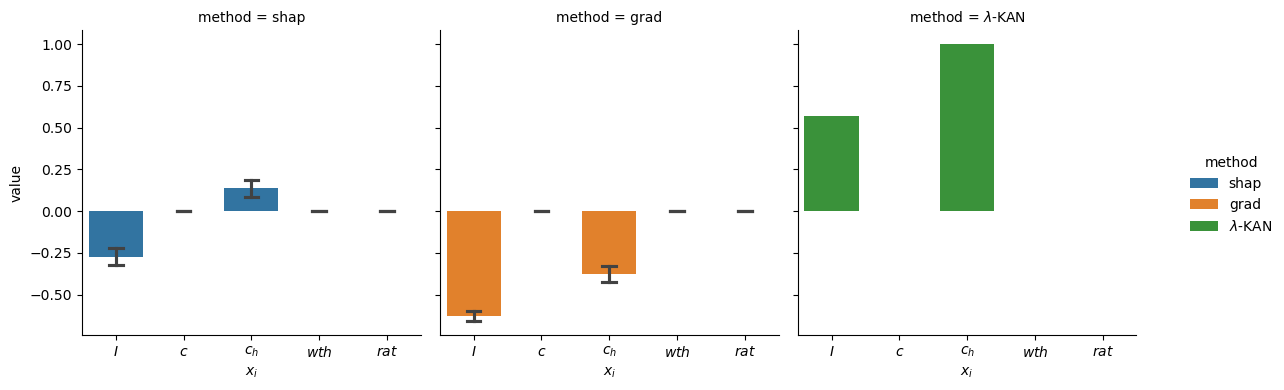

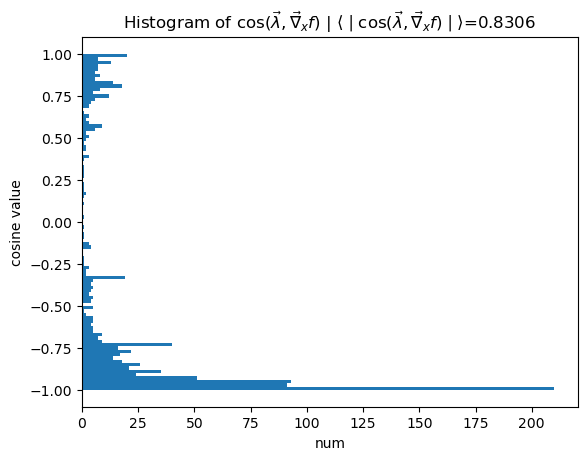

- seed=3 -
checkpoint directory created: ./model
saving model version 0.0


| trn_loss: 7.39e-01 | tst_loss: 6.48e-01 | e_stop: 10/10 | reg: 1.07e+01 | :  45%|▍| 45/100 [00:24<

Early stopping criteria raised
saving model version 0.1


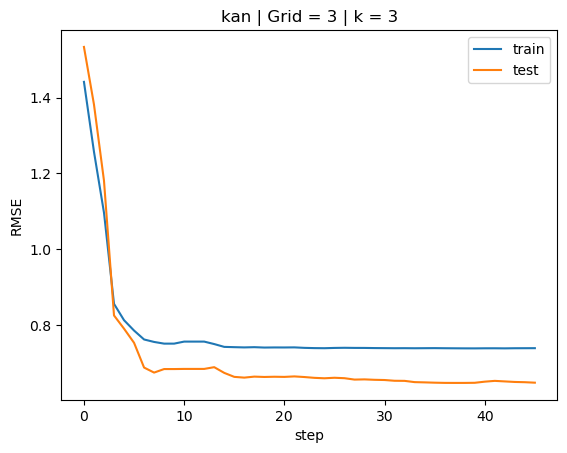

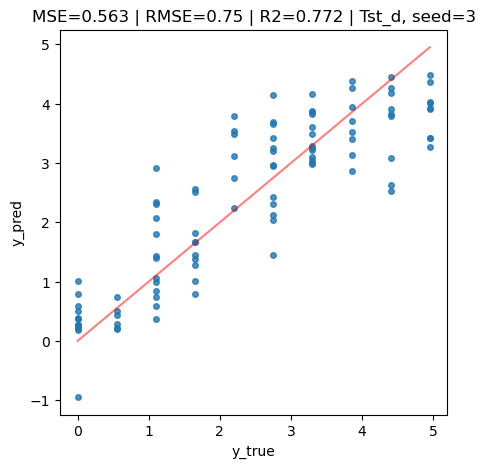

Full dataset:


ExactExplainer explainer: 1001it [00:43, 17.51it/s]                         


module of Input importance:


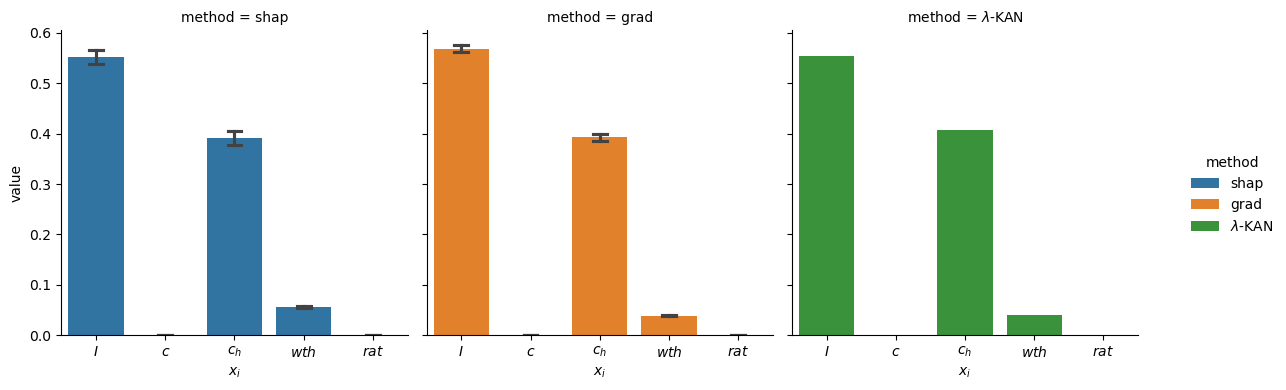

Input importance:


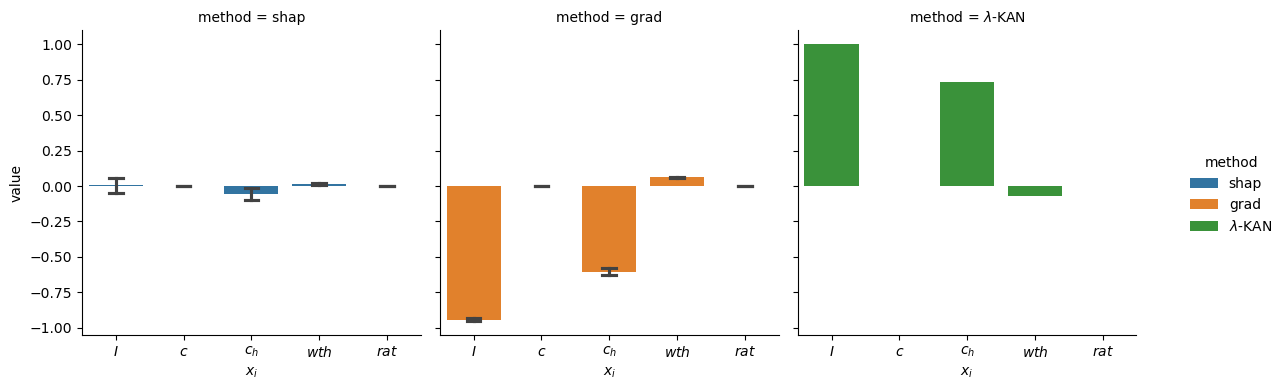

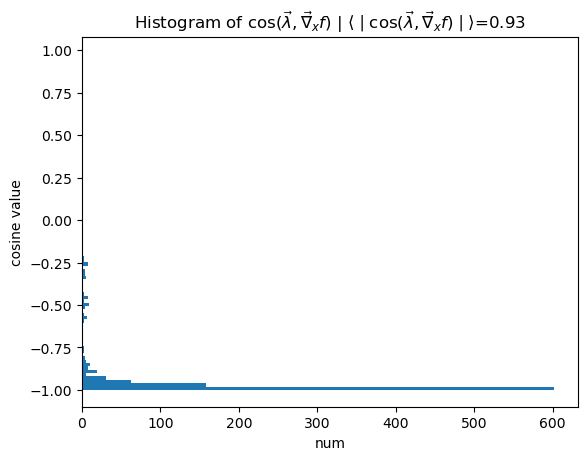

- seed=4 -
checkpoint directory created: ./model
saving model version 0.0


| trn_loss: 7.43e-01 | tst_loss: 6.17e-01 | e_stop: 10/10 | reg: 1.04e+01 | :  15%|▏| 15/100 [00:08<

Early stopping criteria raised
saving model version 0.1


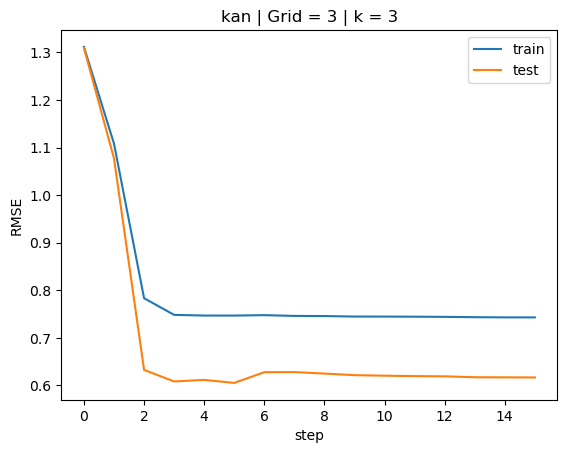

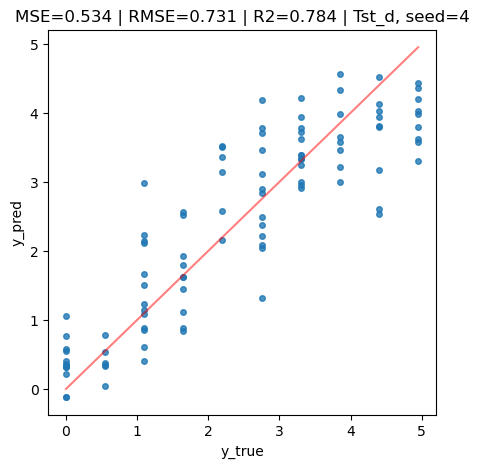

Full dataset:


ExactExplainer explainer: 1001it [00:52, 15.63it/s]                          


module of Input importance:


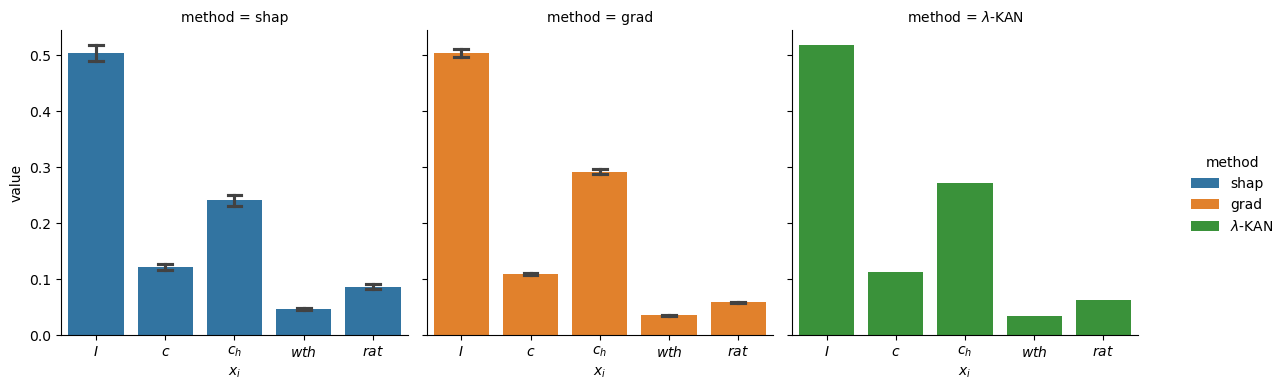

Input importance:


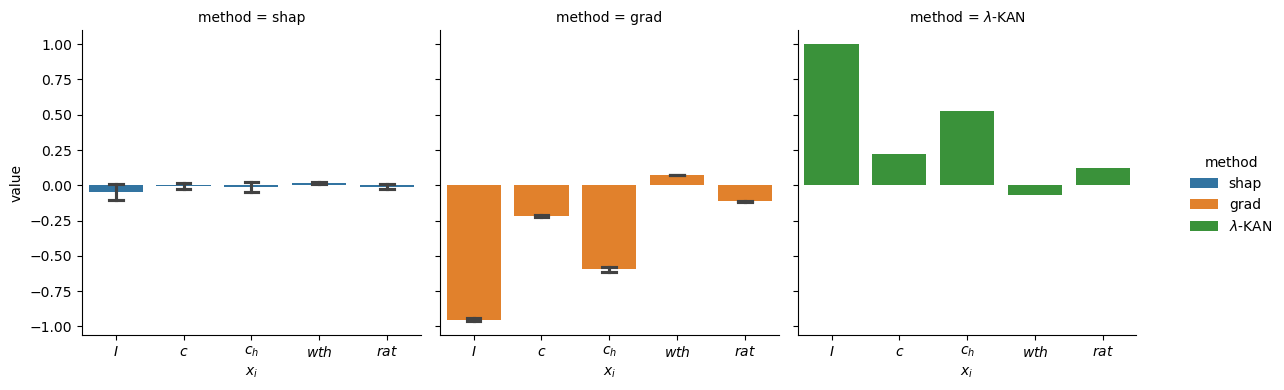

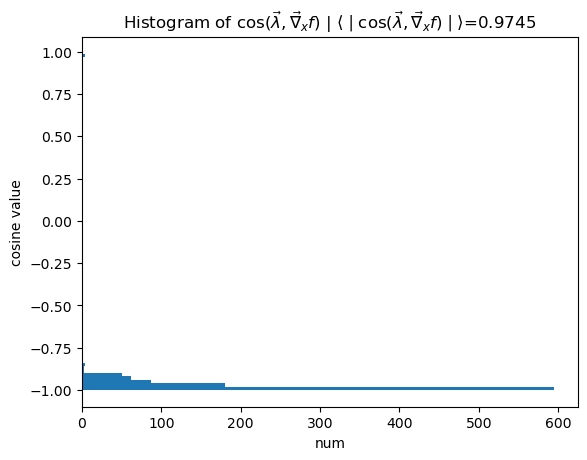

- seed=5 -
checkpoint directory created: ./model
saving model version 0.0


| trn_loss: 7.28e-01 | tst_loss: 7.73e-01 | e_stop: 10/10 | reg: 2.01e+01 | :  34%|▎| 34/100 [00:19<

Early stopping criteria raised
saving model version 0.1


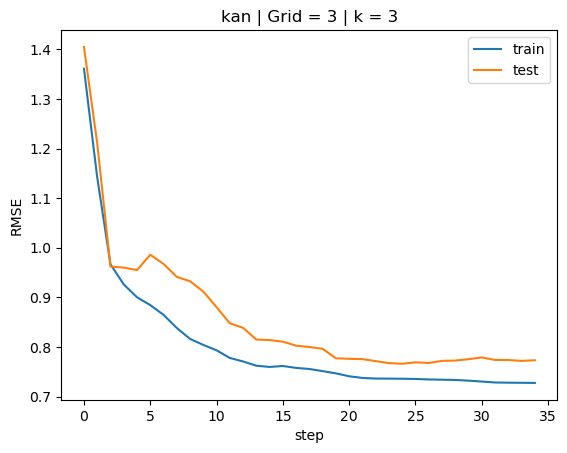

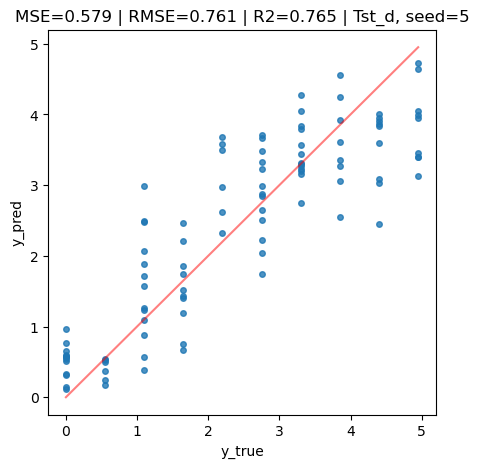

Full dataset:


ExactExplainer explainer: 1001it [00:52, 14.85it/s]                         


module of Input importance:


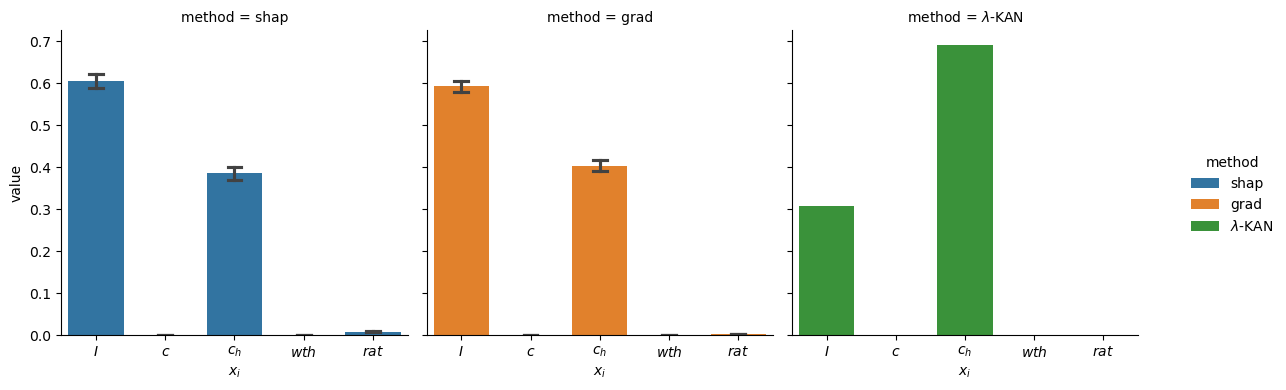

Input importance:


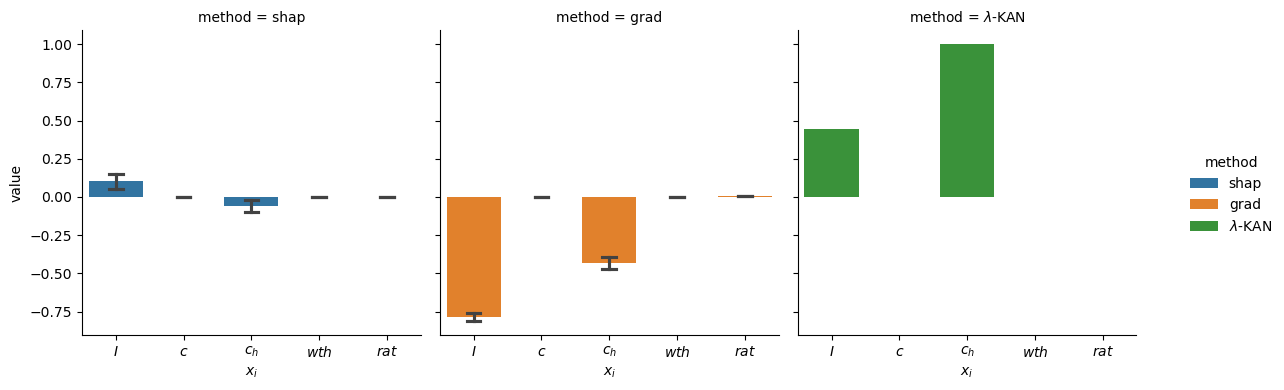

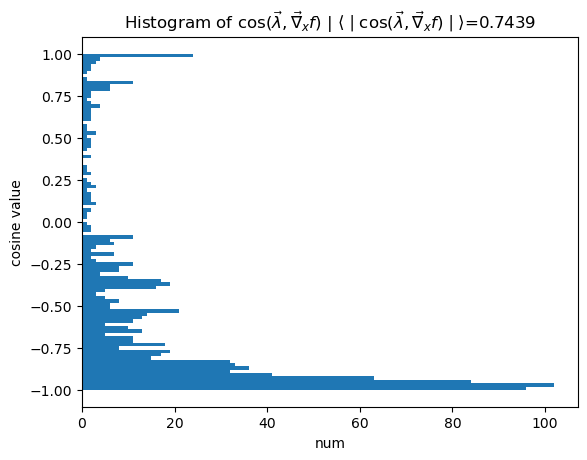

- seed=6 -
checkpoint directory created: ./model
saving model version 0.0


| trn_loss: 7.06e-01 | tst_loss: 8.93e-01 | e_stop: 10/10 | reg: 1.61e+01 | :  37%|▎| 37/100 [00:21<

Early stopping criteria raised
saving model version 0.1


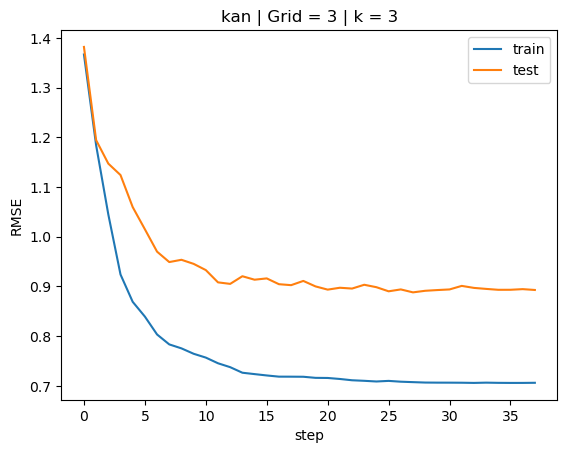

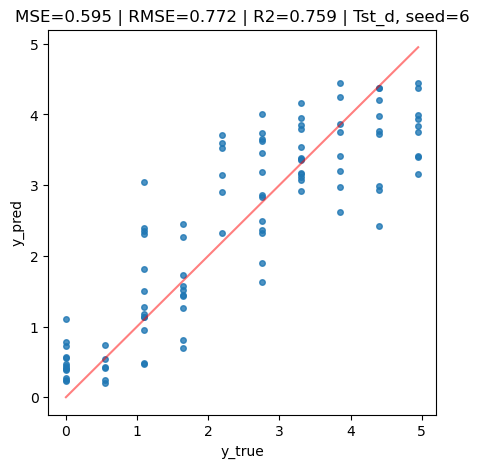

Full dataset:


ExactExplainer explainer: 1001it [00:46, 16.82it/s]                         


module of Input importance:


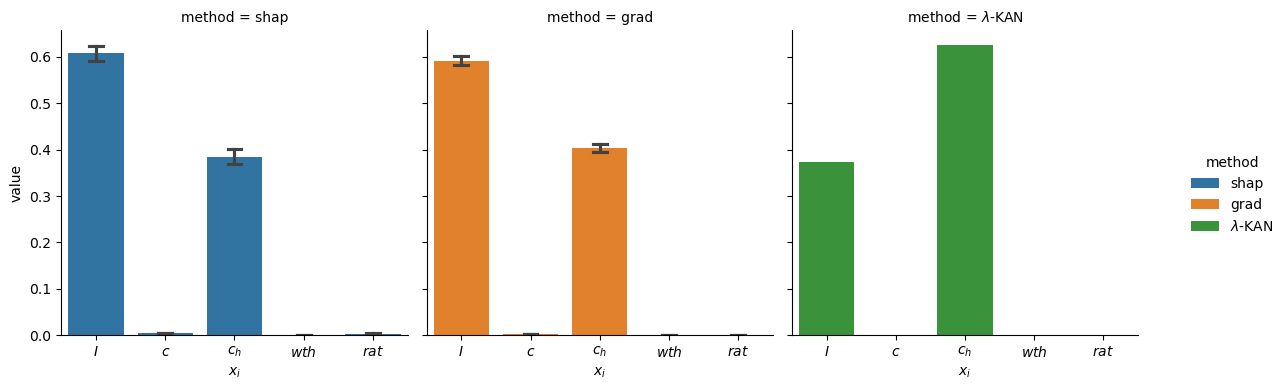

Input importance:


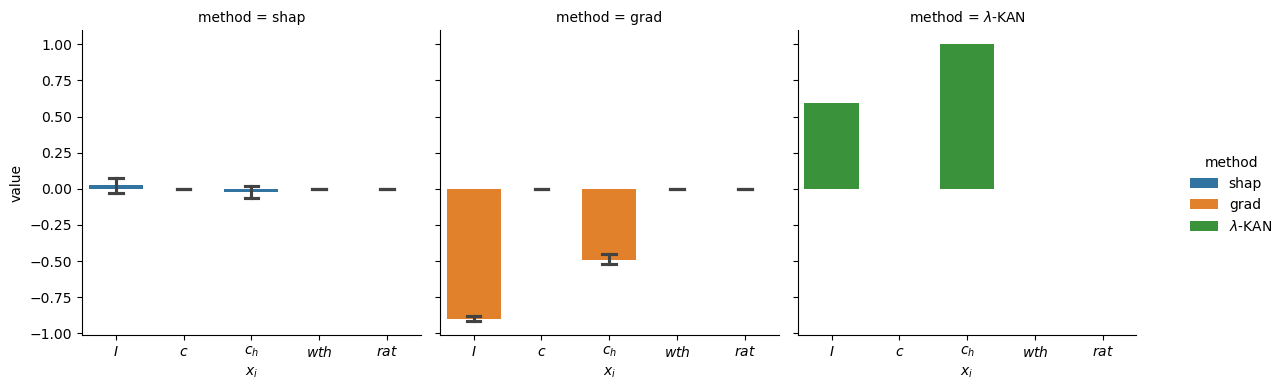

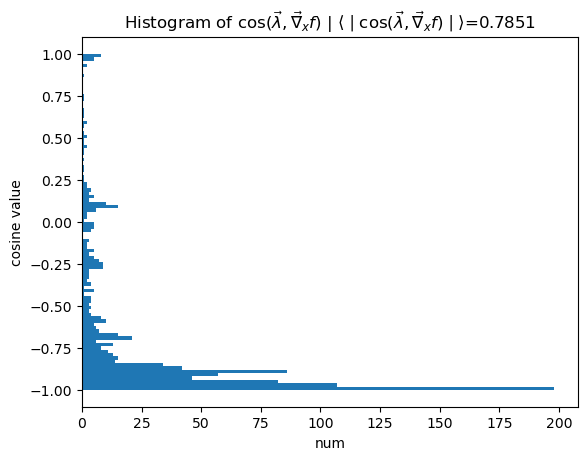

- seed=7 -
checkpoint directory created: ./model
saving model version 0.0


| trn_loss: 7.28e-01 | tst_loss: 7.53e-01 | e_stop: 10/10 | reg: 1.35e+01 | :  22%|▏| 22/100 [00:13<

Early stopping criteria raised
saving model version 0.1


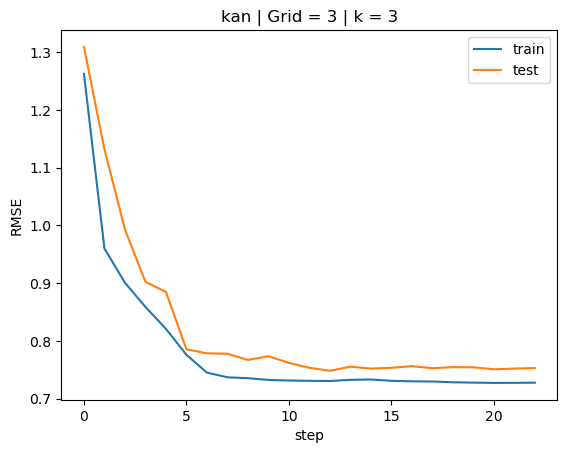

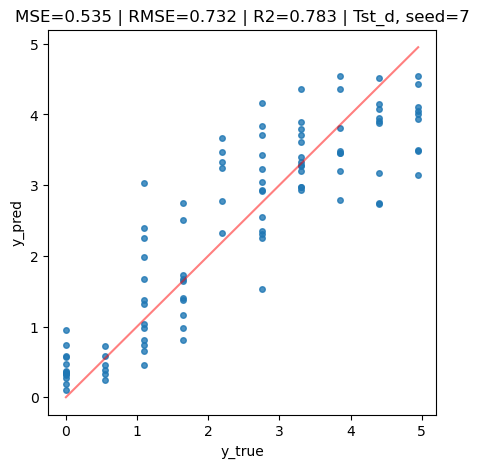

Full dataset:


ExactExplainer explainer: 1001it [00:56, 14.68it/s]                          


module of Input importance:


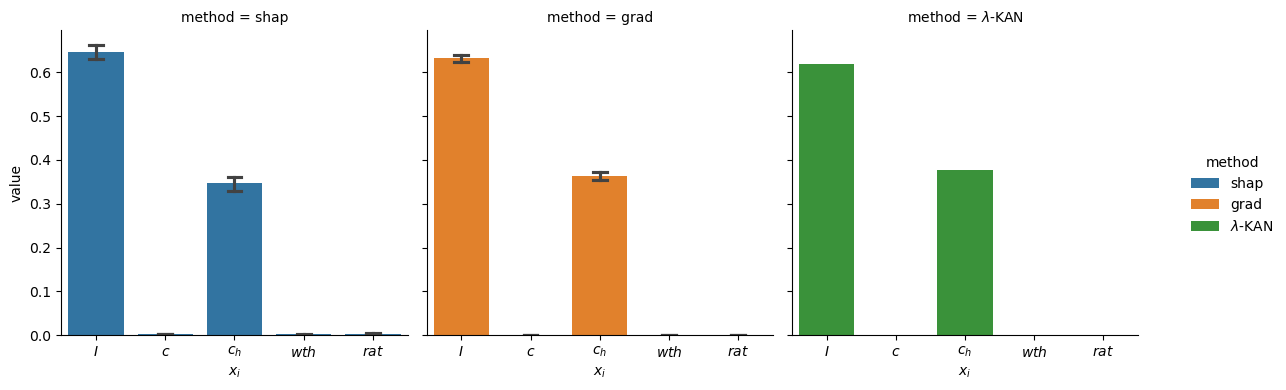

Input importance:


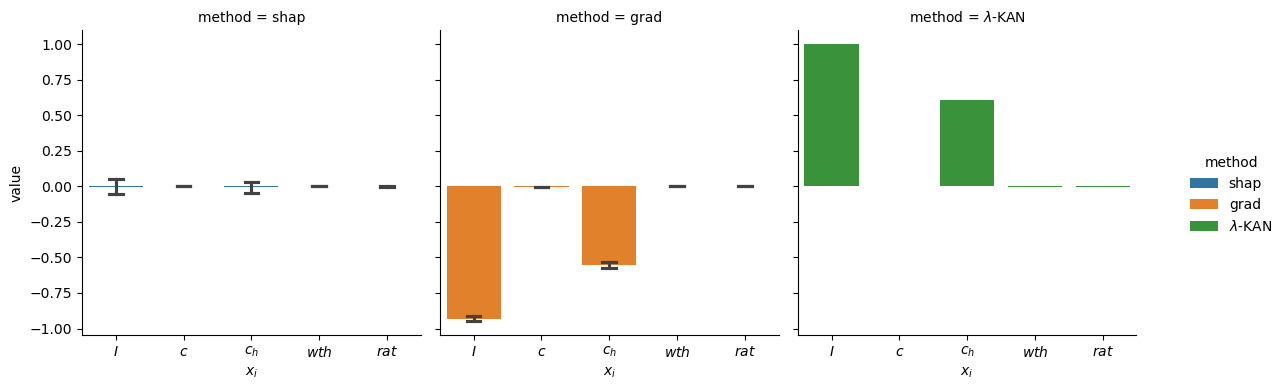

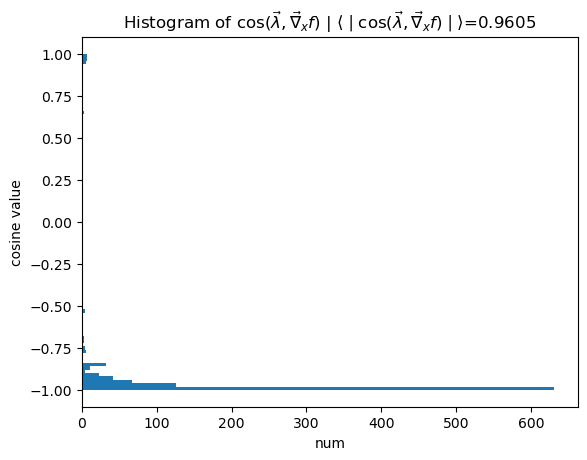

- seed=8 -
checkpoint directory created: ./model
saving model version 0.0


| trn_loss: 7.41e-01 | tst_loss: 5.98e-01 | e_stop: 10/10 | reg: 1.32e+01 | :  34%|▎| 34/100 [00:20<

Early stopping criteria raised
saving model version 0.1


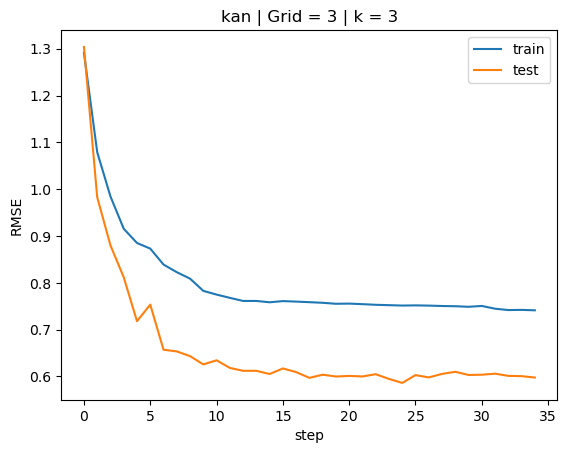

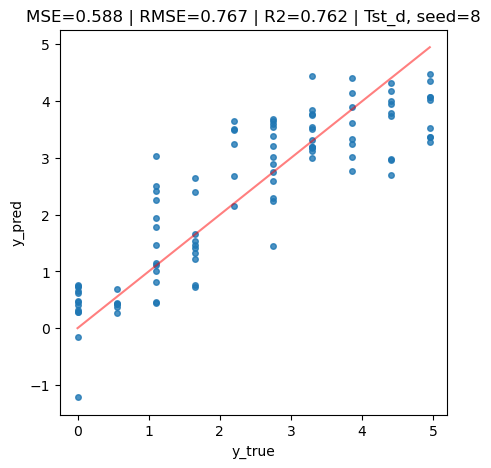

Full dataset:


ExactExplainer explainer: 1001it [00:51, 15.65it/s]                         


module of Input importance:


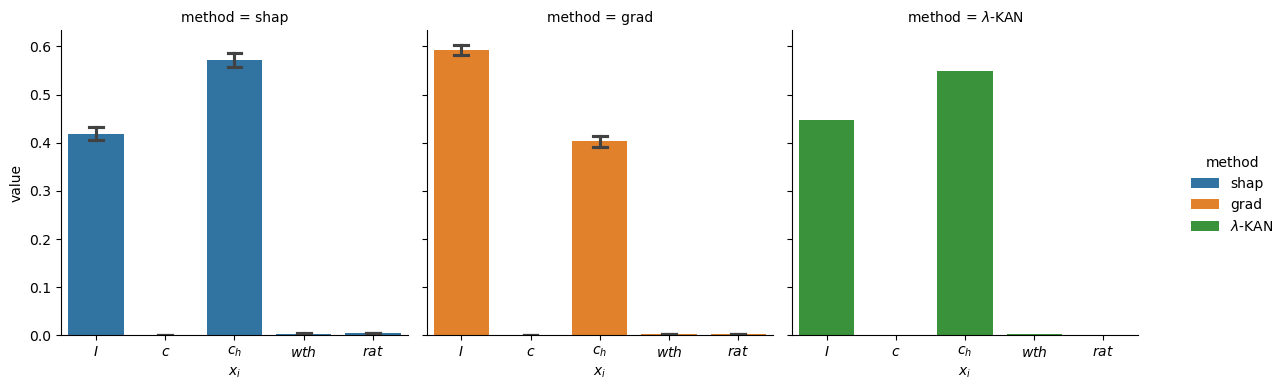

Input importance:


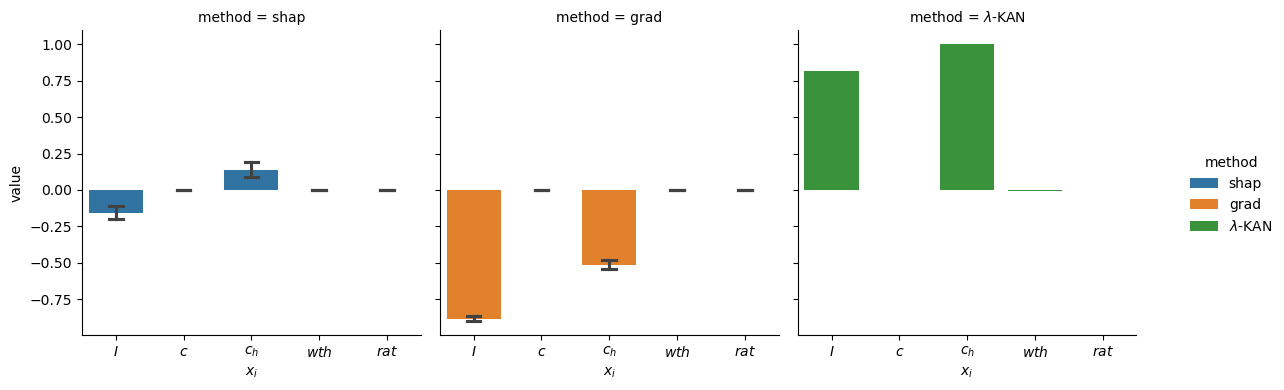

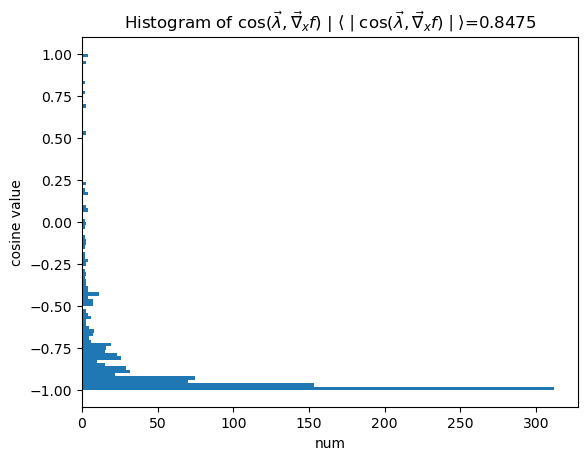

- seed=9 -
checkpoint directory created: ./model
saving model version 0.0


| trn_loss: 7.40e-01 | tst_loss: 7.97e-01 | e_stop: 10/10 | reg: 1.64e+01 | :  34%|▎| 34/100 [00:20<

Early stopping criteria raised
saving model version 0.1


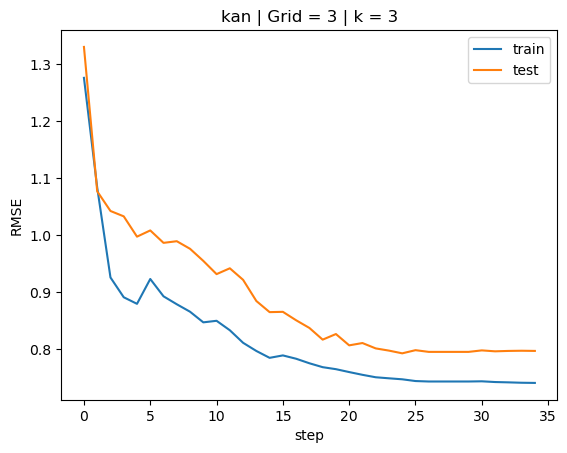

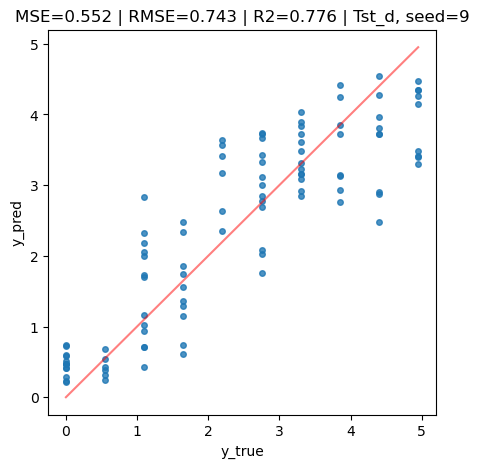

Full dataset:


ExactExplainer explainer: 1001it [00:45, 17.60it/s]                         


module of Input importance:


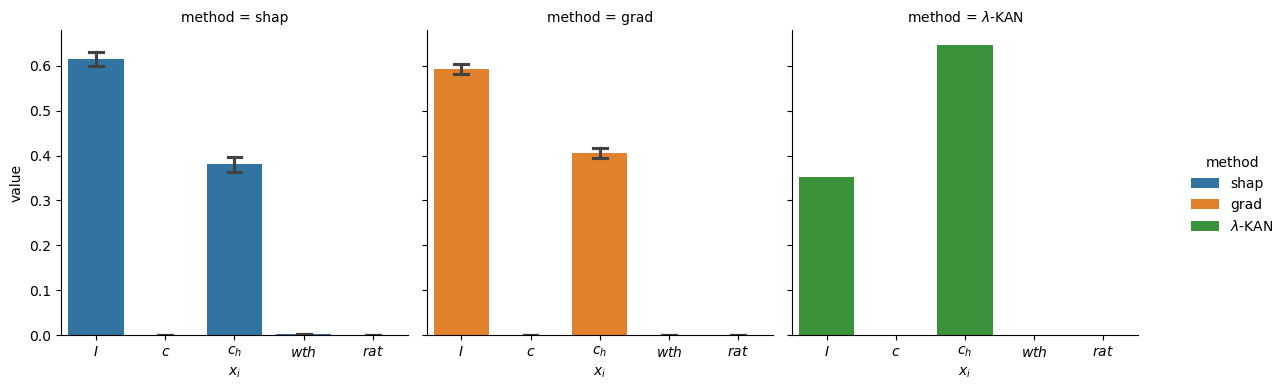

Input importance:


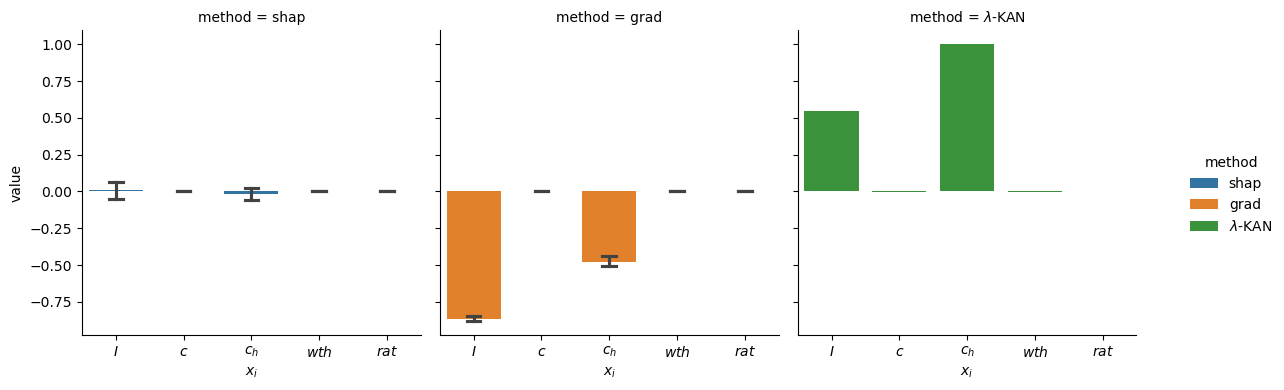

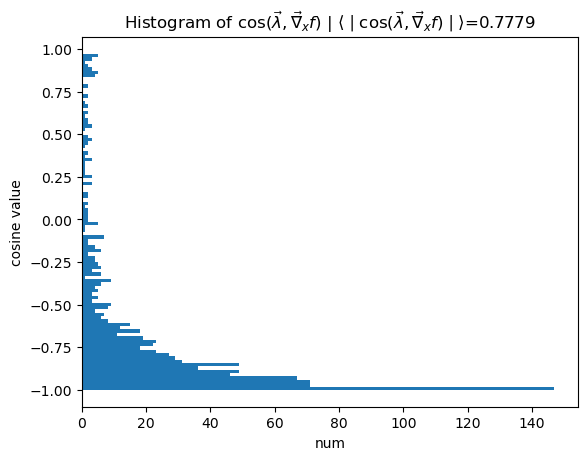

In [8]:
# FITTING KAN with different seed
l_seed = range(10)
grid = 3
k = 3

l_feature_scores = []

for seed in l_seed:
    print(f'==========\n- {seed=} -\n==========')
    model2 = lmdKANRegressor(hidden_layer_sizes=[5,2], seed=seed, grid=3, k=3, 
                       solver="lbfgs", max_iter=100, 
                       lamb=1e-2,
                       lamb_l1=1,
                       lamb_entropy=2)
    
    model2.fit(x_train, y_train)
    result2 = model2.kan.results
    
    #pred_test = model2.predict(x_test)
    pred_train = model2.predict(x_train)
    
    l_feature_scores.append(model2.kan.act_fun[0].lmd.detach().numpy())

    VAR = ['$I$', '$c$', '$c_h$', '$wth$', '$rat$']
    prnt_kwrgs = {'in_vars': VAR, 
                'out_vars': [PREDICT_IONS[0] + ' concentration'], 
                'title': None,
                'sample': True,
                'scale': 0.5,
                'scale_scatter': 0.5}
    
    #model2.kan.plot(**prnt_kwrgs, reper_in_out='out', reper_index=0, hist_plot=True)
    plt.show()

    plt.plot(result2['train_loss'])
    plt.plot(result2['test_loss'])
    #plt.plot(result2['reg'])
    plt.legend(['train', 'test']) #, 'reg'
    plt.title(f'kan | Grid = {grid} | k = {k}')
    plt.ylabel('RMSE')
    plt.xlabel('step')
    plt.show()

    scatter_prediction_skl(model2, x_test, y_test, f"Tst_d, seed={seed}")

    print('Full dataset:')
    importance_analyse_lmdKAN(model2.kan, dict(test_input=torch.tensor(scaler.transform(x), dtype=torch.float)))

    plt.show()
    
l_feature_scores = np.array(l_feature_scores)

In [9]:
l_feature_scores

array([[ 1.71451187e+00,  6.36252940e-01,  8.06422830e-01,
        -2.83168498e-02,  3.68855715e-01],
       [ 1.71748531e+00,  7.66426682e-01,  6.72685087e-01,
        -1.80470139e-01,  4.86496091e-01],
       [ 1.38403833e+00, -3.83677776e-04,  2.41960382e+00,
         5.81931230e-03, -1.08130299e-03],
       [ 1.36698723e+00,  3.46609158e-06,  1.00421047e+00,
        -9.95454565e-02,  2.57619598e-04],
       [ 1.61804092e+00,  3.53234917e-01,  8.51480365e-01,
        -1.08191356e-01,  1.96136370e-01],
       [ 9.08916771e-01, -1.66416270e-04,  2.04246950e+00,
        -5.20679168e-05, -3.93129187e-03],
       [ 1.31813550e+00,  4.47474374e-03,  2.21377778e+00,
         5.14839310e-04, -2.31943629e-03],
       [ 1.60248685e+00,  4.36162623e-03,  9.78168905e-01,
        -3.18350620e-03, -4.41343943e-03],
       [ 1.34086943e+00,  1.13479304e-03,  1.64130962e+00,
        -7.15742260e-03,  4.07861965e-03],
       [ 9.26575899e-01, -1.73917308e-03,  1.70417786e+00,
        -4.22996609e-03

- seed=0 -
checkpoint directory created: ./model
saving model version 0.0


| trn_loss: 7.20e-01 | tst_loss: 8.50e-01 | e_stop: 10/10 | reg: 1.03e+01 | :  13%|▏| 13/100 [00:07<


Early stopping criteria raised
saving model version 0.1


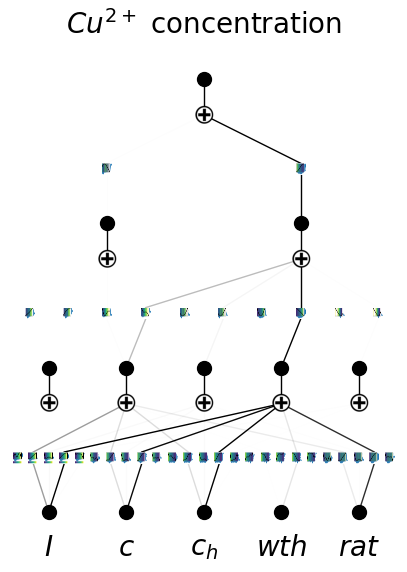

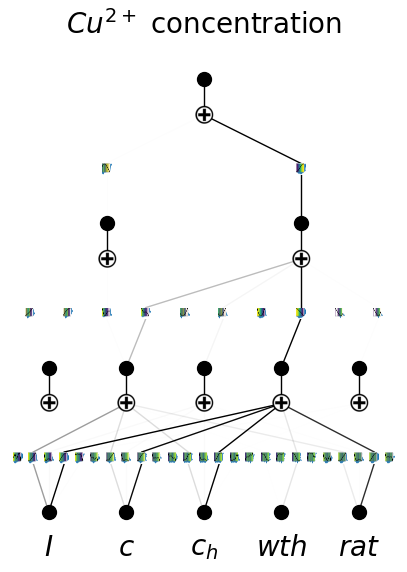

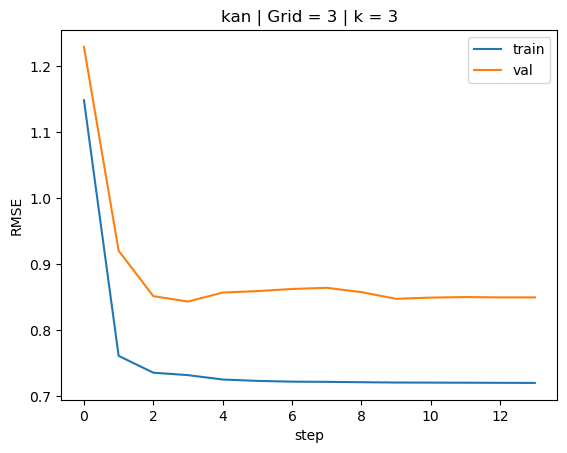

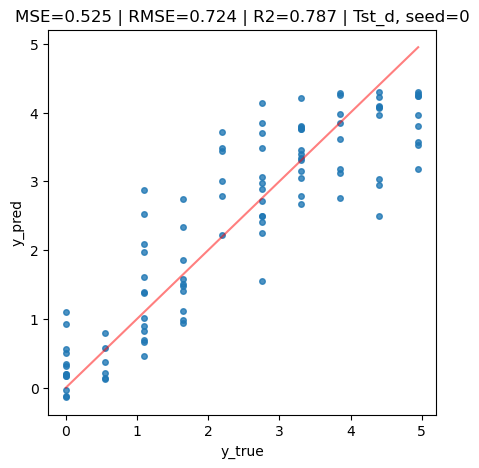

Full dataset:


ExactExplainer explainer: 1001it [00:46, 16.81it/s]                          


module of Input importance:


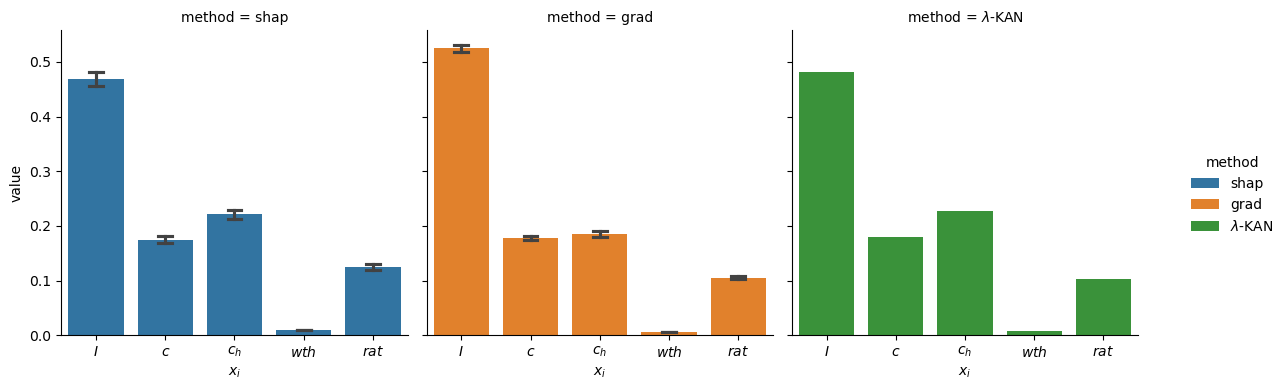

Input importance:


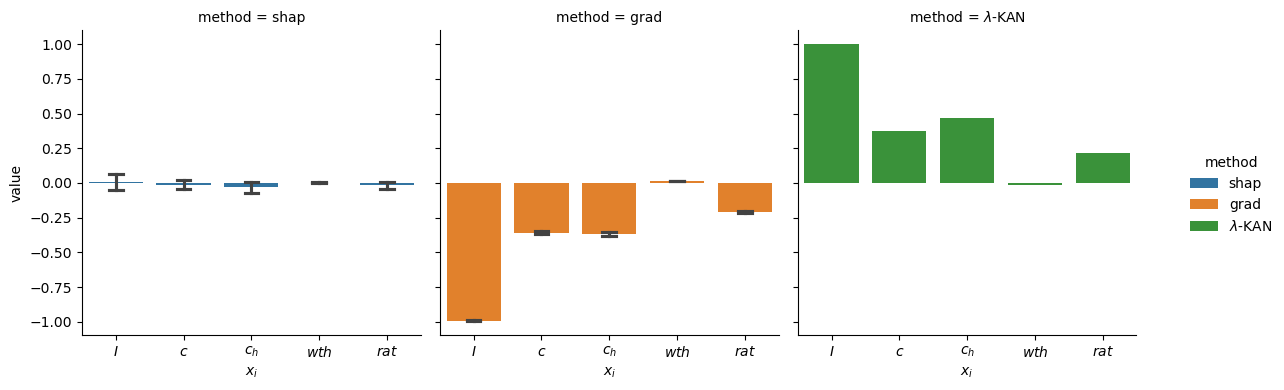

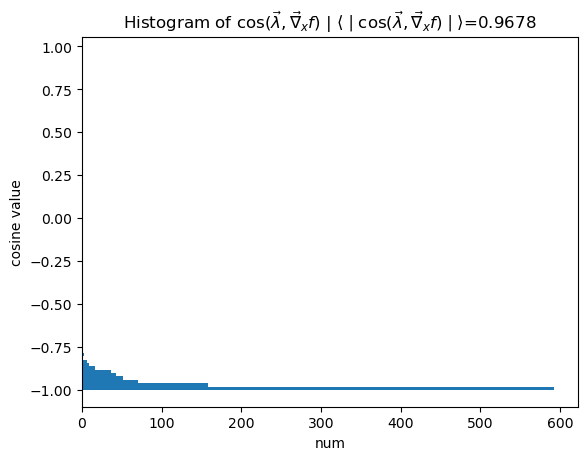

In [7]:
grid = 3
k = 3

# Choose seed and train again
seed = 0
print(f'==========\n- {seed=} -\n==========')
model2 = lmdKANRegressor(hidden_layer_sizes=[5,2,], seed=seed, grid=grid, k=k, 
                   solver="lbfgs", max_iter=100, 
                   lamb=1e-2,
                   lamb_l1=1,
                   lamb_entropy=2)

model2.fit(x_train, y_train)
result2 = model2.kan.results

#pred_test = model2.predict(x_test)
pred_train = model2.predict(x_train)
VAR = ['$I$', '$c$', '$c_h$', '$wth$', '$rat$']
prnt_kwrgs = {'in_vars': VAR, 
            'out_vars': [PREDICT_ION_NAME + ' concentration'], 
            'title': None,
            'sample': True,
            'scale': 0.5,
            'scale_scatter': 0.5}

model2.kan.plot(**prnt_kwrgs, reper_in_out='in', reper_index=0, hist_plot=True)
model2.kan.plot(**prnt_kwrgs, reper_in_out='out', reper_index=0, hist_plot=True)
plt.show()
plt.plot(result2['train_loss'])
plt.plot(result2['test_loss'])
#plt.plot(result2['reg'])
plt.legend(['train', 'val']) #, 'reg'
plt.title(f'kan | Grid = {grid} | k = {k}')
plt.ylabel('RMSE')
plt.xlabel('step')
plt.show()
scatter_prediction_skl(model2, x_test, y_test, f"Tst_d, seed={seed}")
print('Full dataset:')
importance_analyse_lmdKAN(model2.kan, dict(test_input=torch.tensor(scaler.transform(x), dtype=torch.float)))
plt.show()

# $Ni$

In [8]:
# PREPARING DATA + PairPlot
PREDICT_IONS = ['Ni']# ['Cr'], ['Cu'], ['Ni'], ['NO3']# d_config['PREDICT_IONS']
PREDICT_ION_NAME = '$Ni^{2+}$'
y = get_y(l_ions=PREDICT_IONS, spec_file=""+SPEC_FOLDER)


squeezed_df = pd.DataFrame(np.concatenate([x, y.reshape([-1,1])], axis=1), columns=['$I$', '$c$', '$c_h$', '$wth$', '$rat$', PREDICT_IONS[0] + ' concentration'])
#sns.pairplot(squeezed_df)

x_train, x_test, y_train, y_test = train_test_split(x, y, 
                                                    train_size=TRAIN_TEST_RATIO,
                                                    random_state=42)

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

'''
scalerY = StandardScaler()
y_train = scalerY.fit_transform(y_train.reshape(-1, 1))
y_test = scalerY.transform(y_test.reshape(-1, 1))
'''
INPUT_SHAPE = x_train.shape[1]

- seed=0 -
checkpoint directory created: ./model
saving model version 0.0


| trn_loss: 1.57e+00 | tst_loss: 1.61e+00 | e_stop: 10/10 | reg: 9.83e-01 | :  15%|▏| 15/100 [00:06<

Early stopping criteria raised
saving model version 0.1


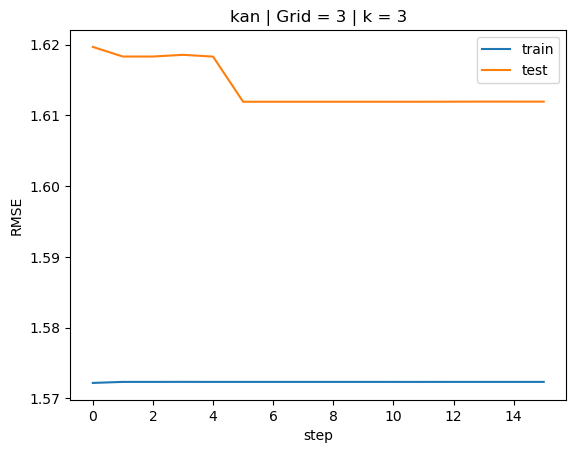

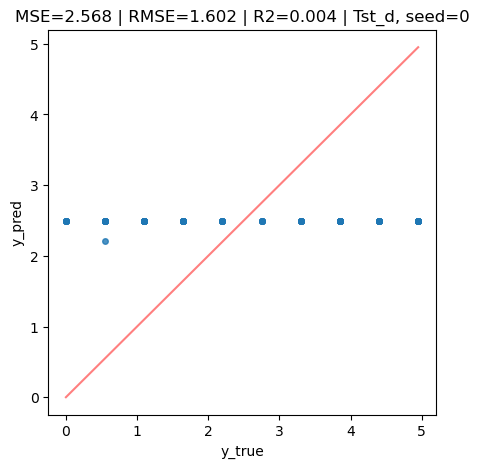

Full dataset:


ExactExplainer explainer: 1001it [00:42, 17.91it/s]                         


module of Input importance:


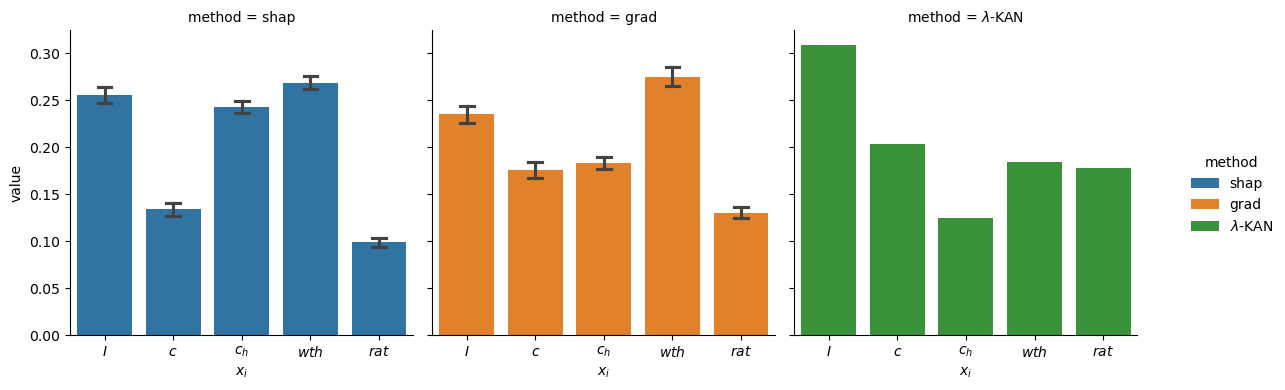

Input importance:


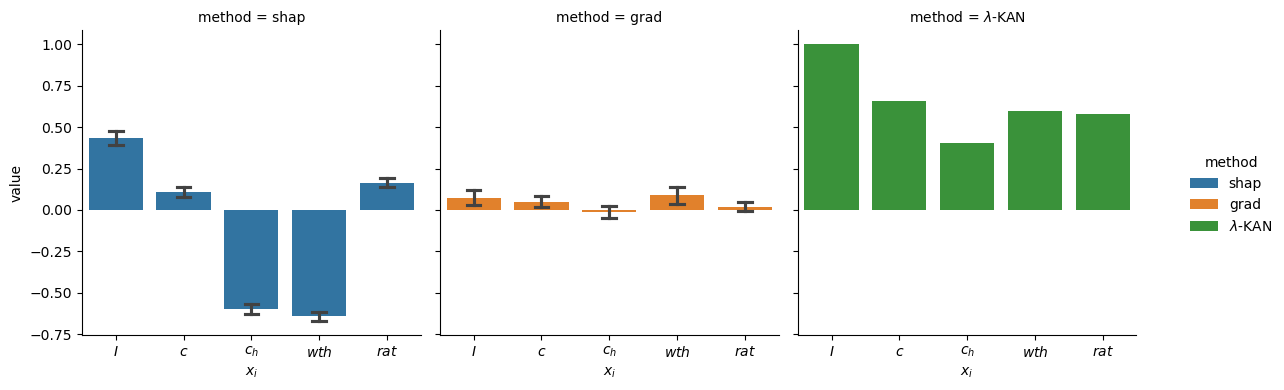

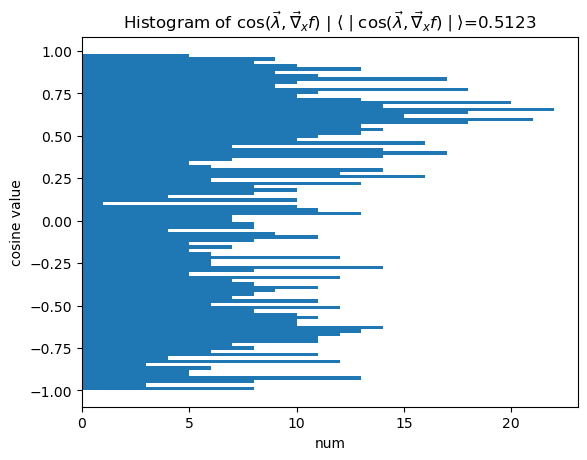

- seed=1 -
checkpoint directory created: ./model
saving model version 0.0


| trn_loss: 1.50e+00 | tst_loss: 1.66e+00 | e_stop: 10/10 | reg: 1.12e+01 | :  15%|▏| 15/100 [00:07<

Early stopping criteria raised
saving model version 0.1


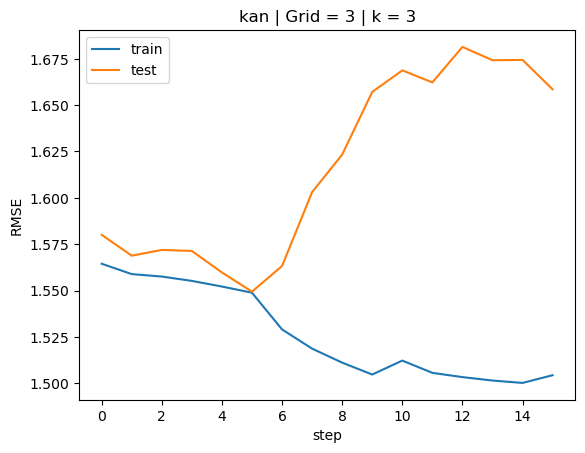

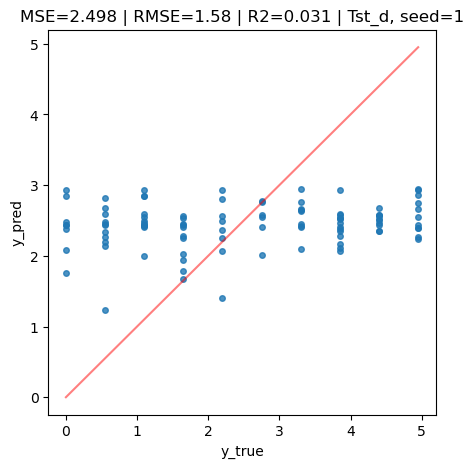

Full dataset:


ExactExplainer explainer: 1001it [00:40, 18.45it/s]                         


module of Input importance:


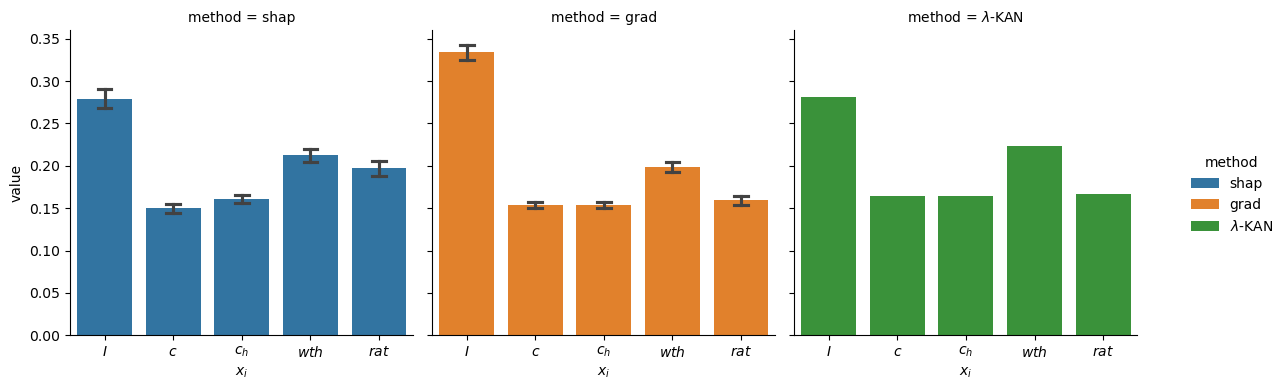

Input importance:


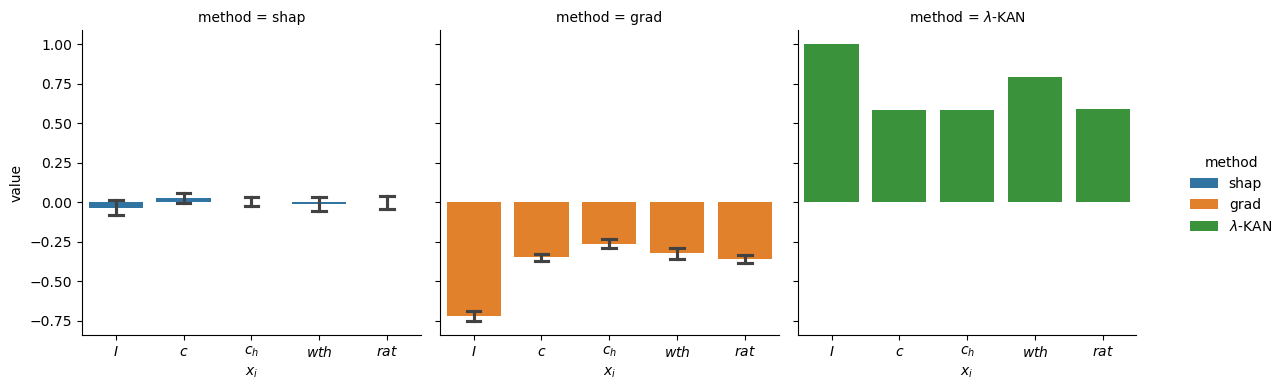

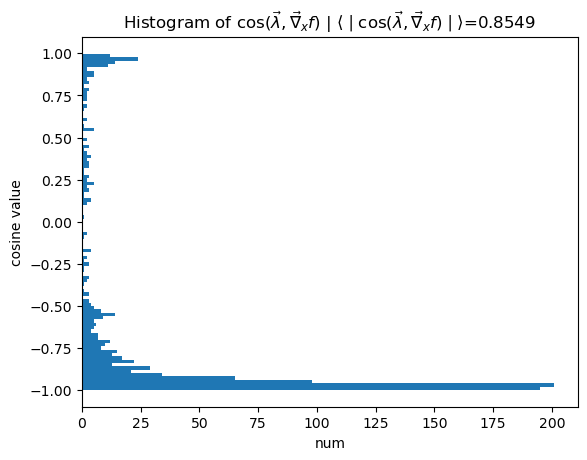

- seed=2 -
checkpoint directory created: ./model
saving model version 0.0


| trn_loss: 1.52e+00 | tst_loss: 1.52e+00 | e_stop: 10/10 | reg: 7.29e+00 | :  18%|▏| 18/100 [00:08<

Early stopping criteria raised
saving model version 0.1


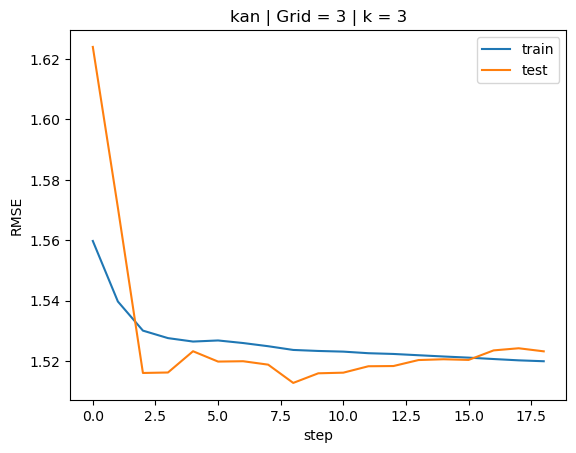

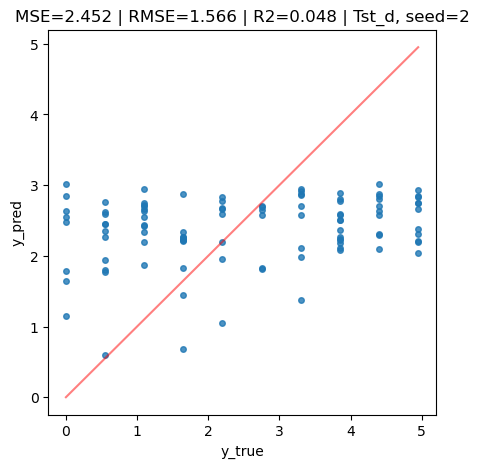

Full dataset:


ExactExplainer explainer: 1001it [00:42, 18.01it/s]                          


module of Input importance:


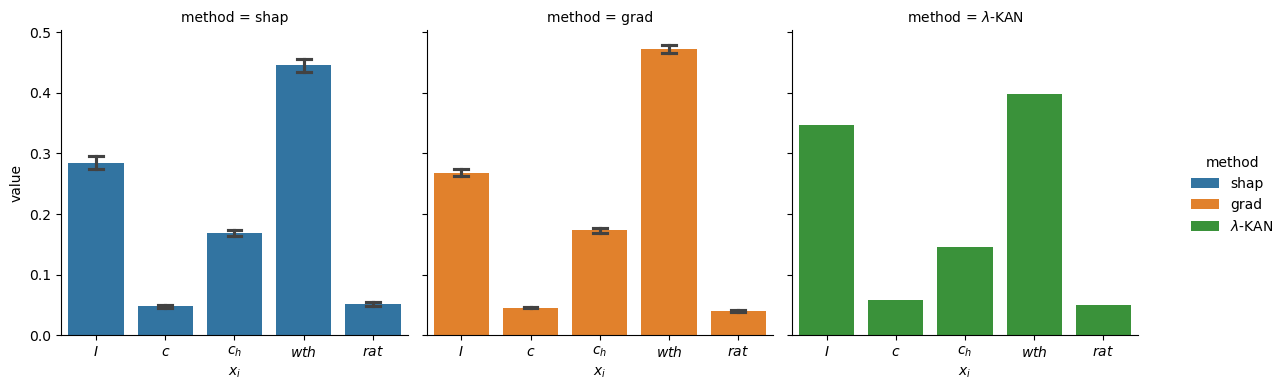

Input importance:


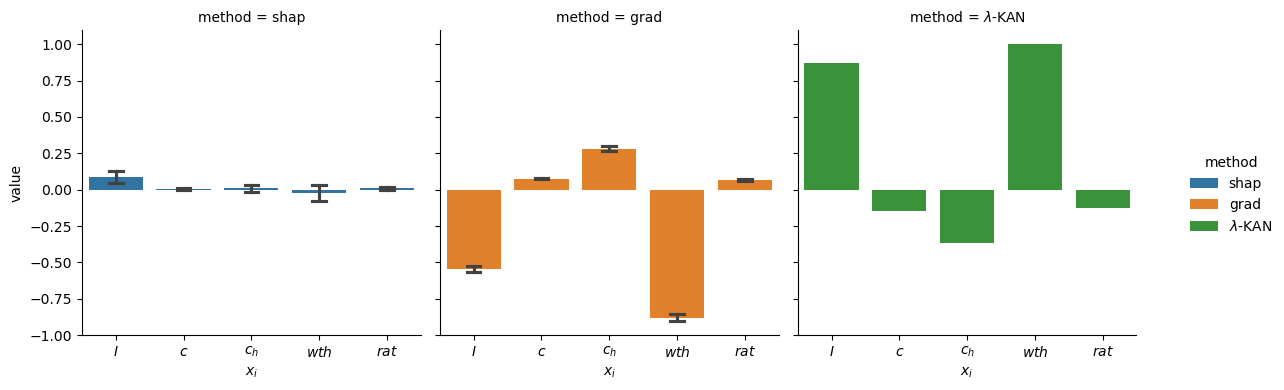

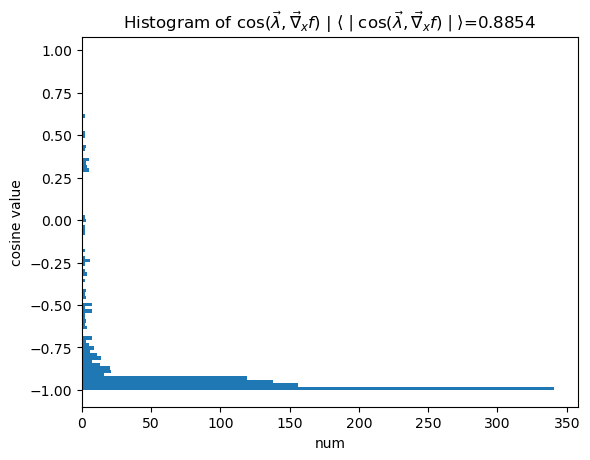

- seed=3 -
checkpoint directory created: ./model
saving model version 0.0


| trn_loss: 1.50e+00 | tst_loss: 1.50e+00 | e_stop: 10/10 | reg: 1.08e+01 | :  11%| | 11/100 [00:05<

Early stopping criteria raised
saving model version 0.1


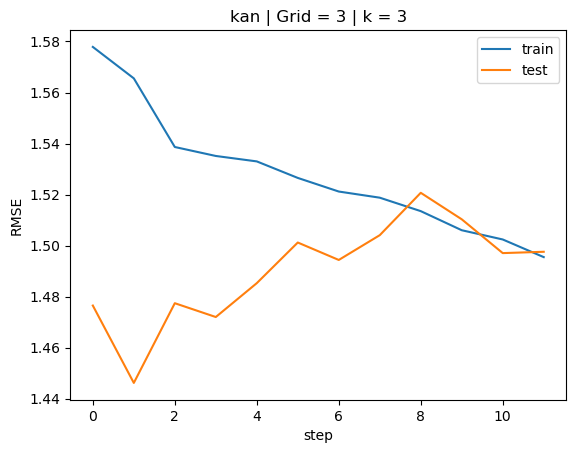

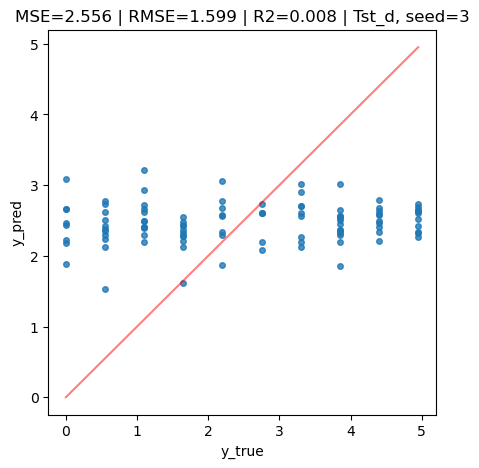

Full dataset:


ExactExplainer explainer: 1001it [00:39, 18.85it/s]                          


module of Input importance:


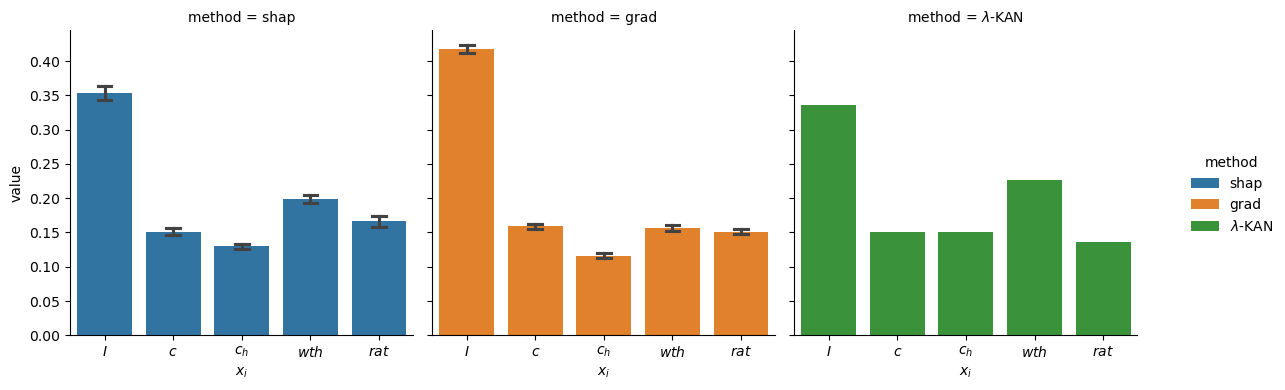

Input importance:


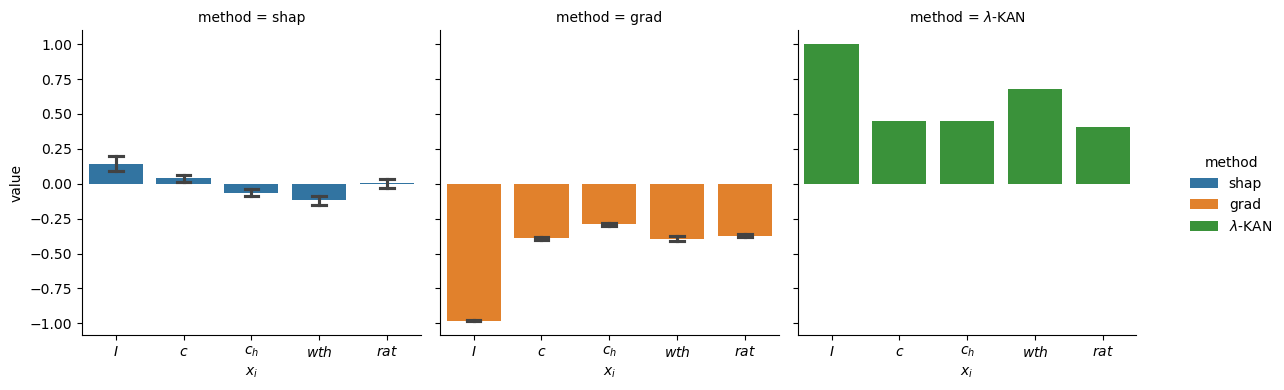

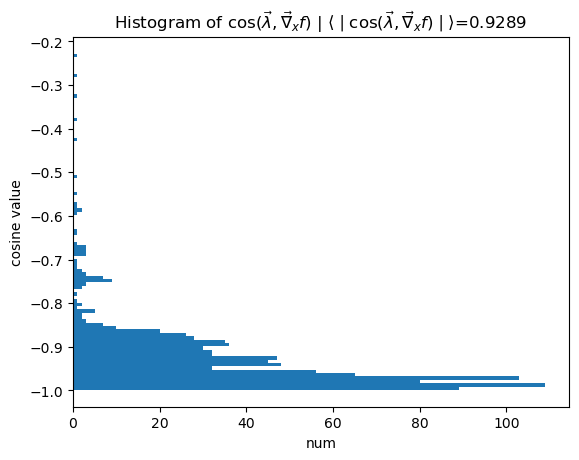

- seed=4 -
checkpoint directory created: ./model
saving model version 0.0


| trn_loss: 1.48e+00 | tst_loss: 1.64e+00 | e_stop: 10/10 | reg: 1.65e+01 | :  15%|▏| 15/100 [00:07<

Early stopping criteria raised
saving model version 0.1


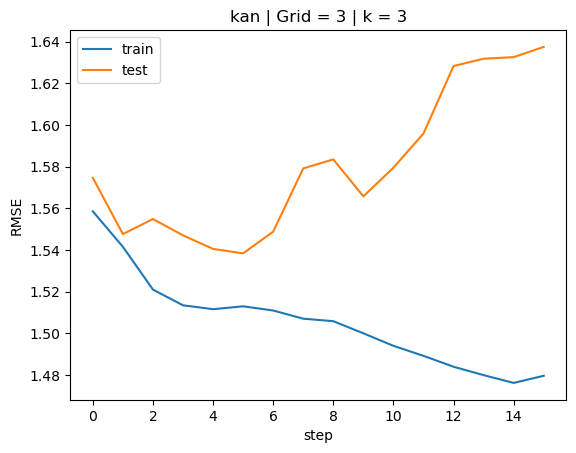

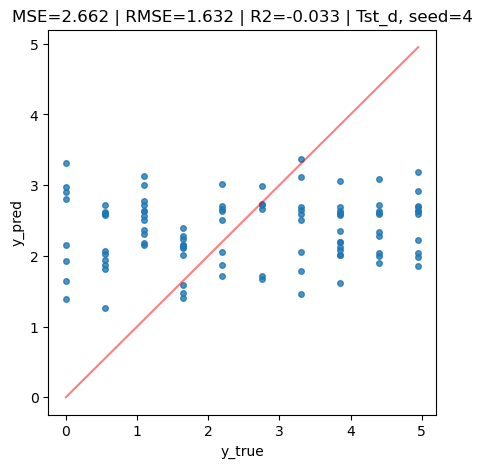

Full dataset:


ExactExplainer explainer: 1001it [00:40, 18.90it/s]                          


module of Input importance:


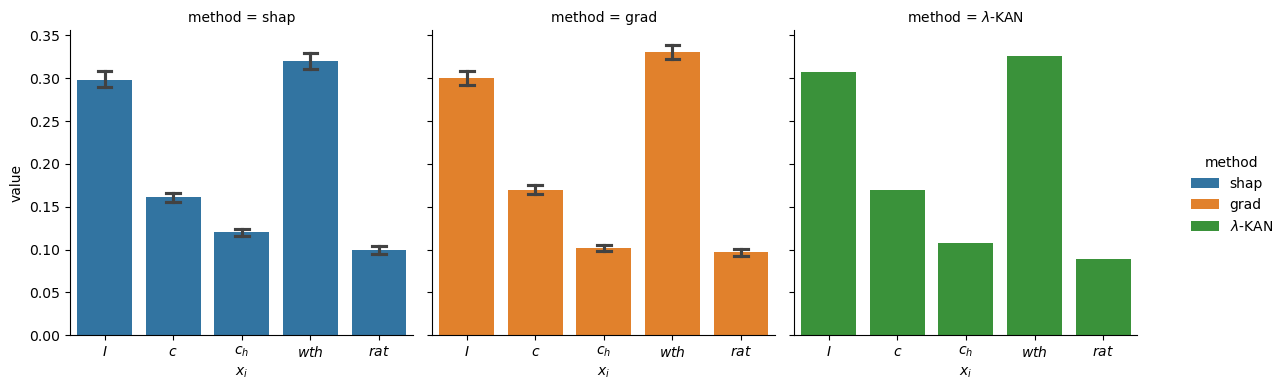

Input importance:


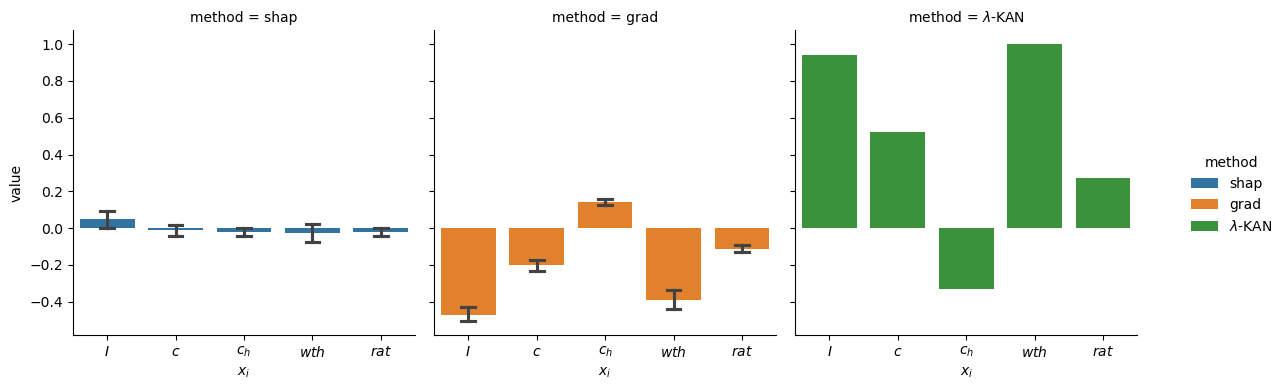

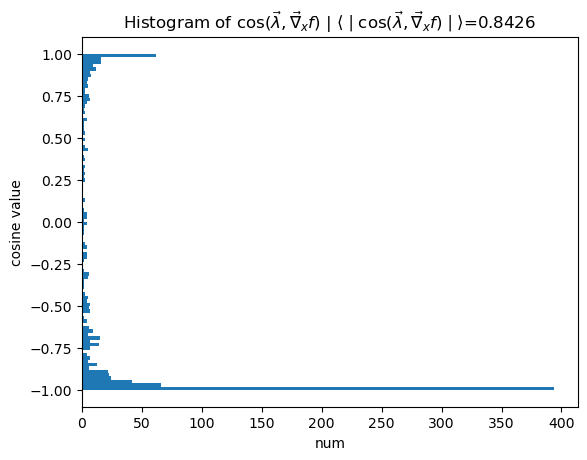

- seed=5 -
checkpoint directory created: ./model
saving model version 0.0


| trn_loss: 1.57e+00 | tst_loss: 1.60e+00 | e_stop: 10/10 | reg: 1.10e+00 | :  17%|▏| 17/100 [00:09<

Early stopping criteria raised
saving model version 0.1


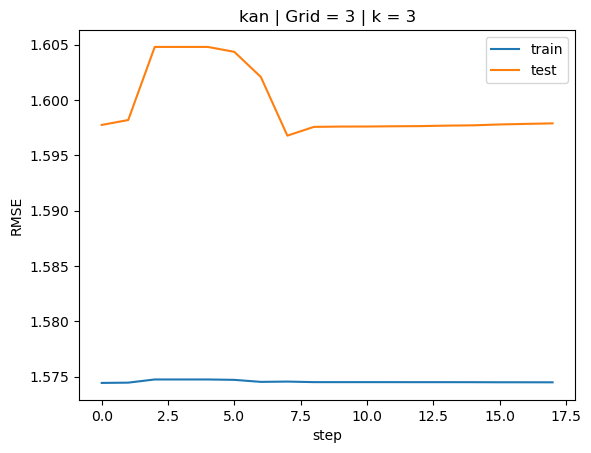

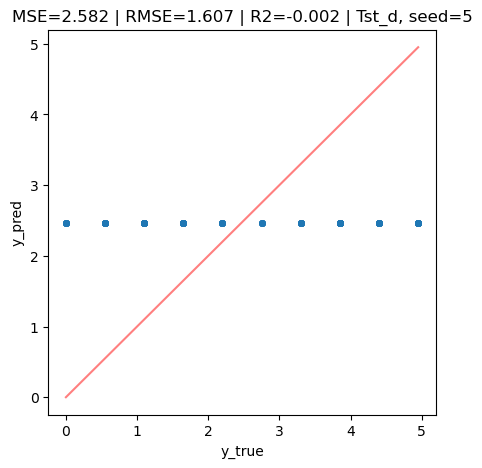

Full dataset:


ExactExplainer explainer: 1001it [00:40, 18.56it/s]                         


module of Input importance:


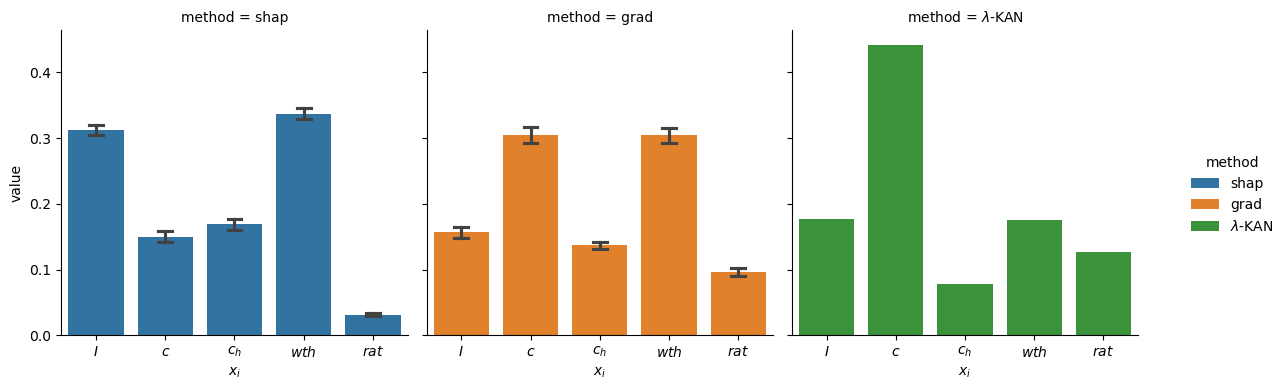

Input importance:


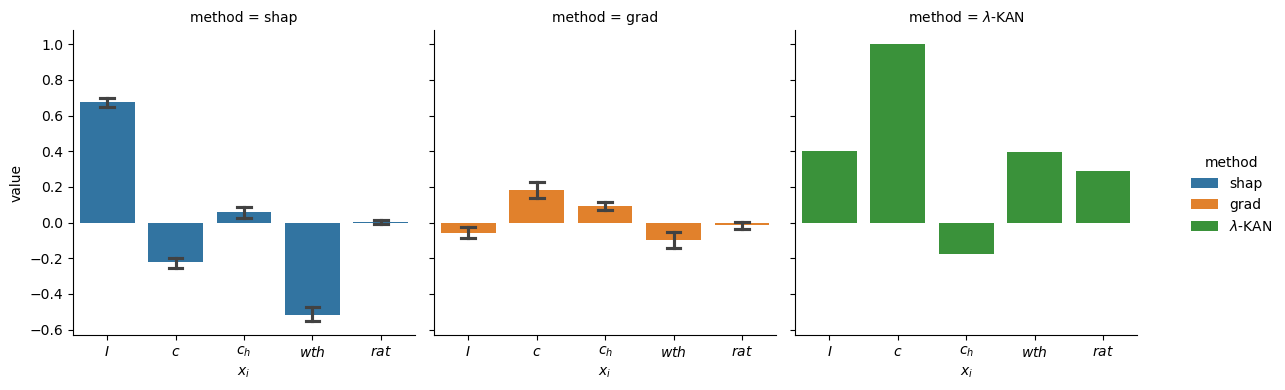

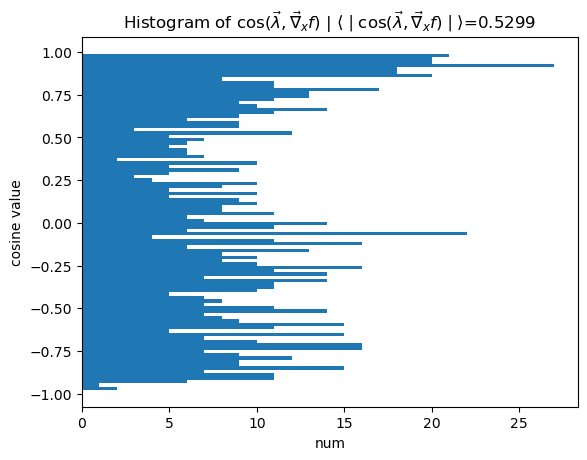

- seed=6 -
checkpoint directory created: ./model
saving model version 0.0


| trn_loss: 1.52e+00 | tst_loss: 1.49e+00 | e_stop: 10/10 | reg: 6.60e+00 | :  14%|▏| 14/100 [00:06<


Early stopping criteria raised
saving model version 0.1


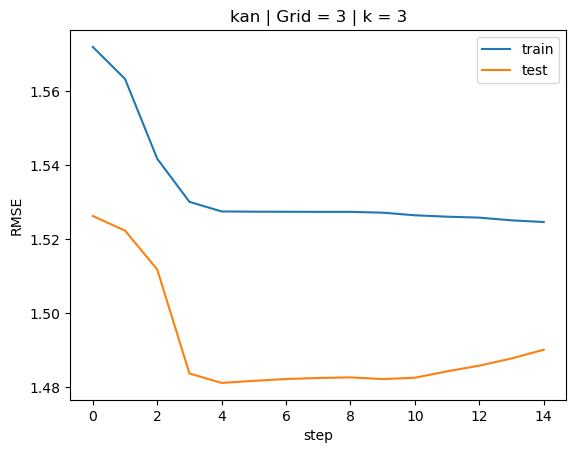

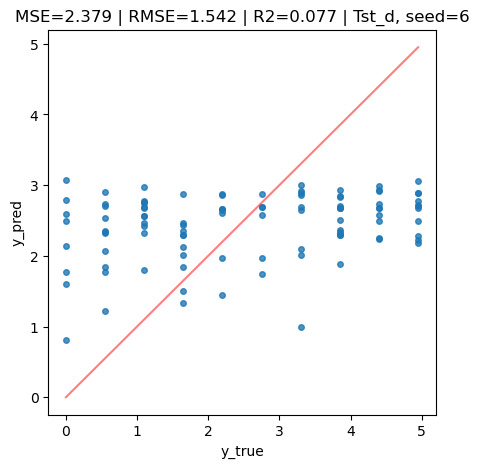

Full dataset:


ExactExplainer explainer: 1001it [00:40, 18.71it/s]                          


module of Input importance:


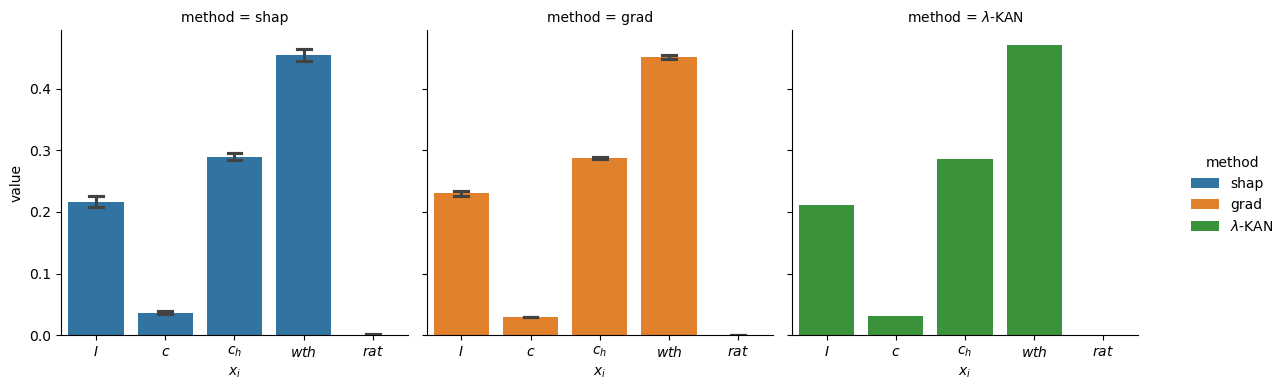

Input importance:


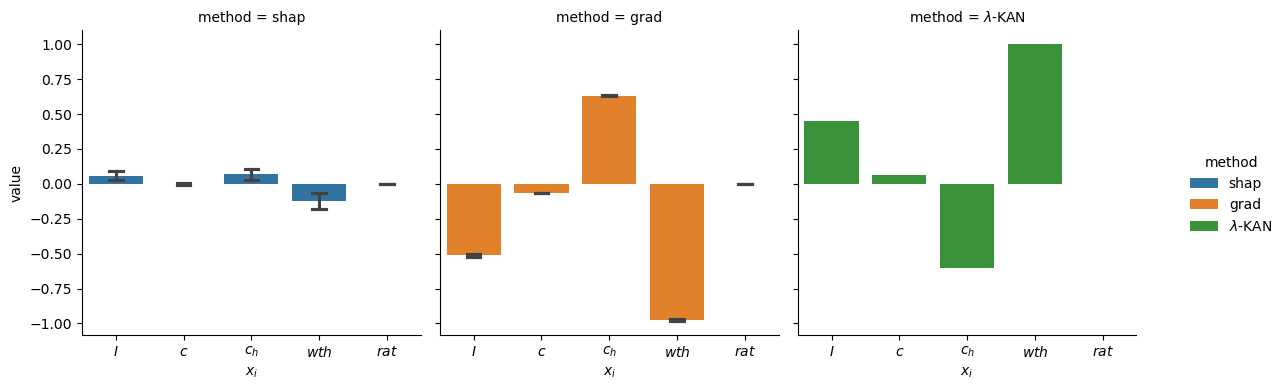

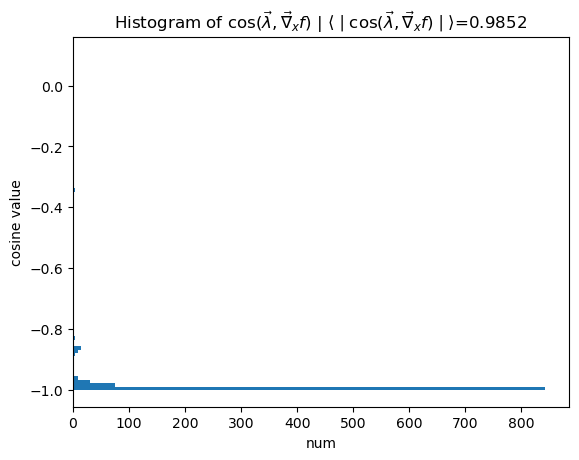

- seed=7 -
checkpoint directory created: ./model
saving model version 0.0


| trn_loss: 1.48e+00 | tst_loss: 1.60e+00 | e_stop: 10/10 | reg: 1.19e+01 | :  13%|▏| 13/100 [00:06<

Early stopping criteria raised
saving model version 0.1


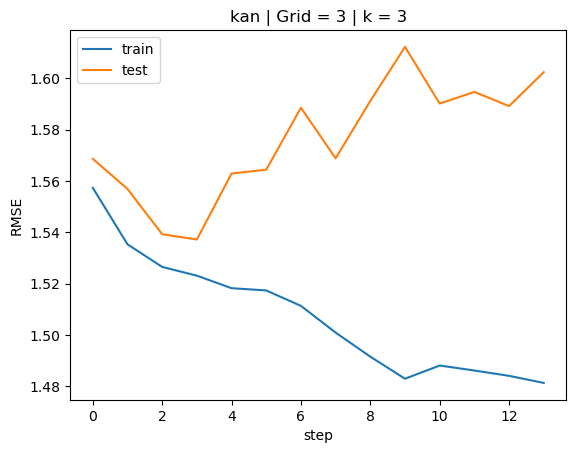

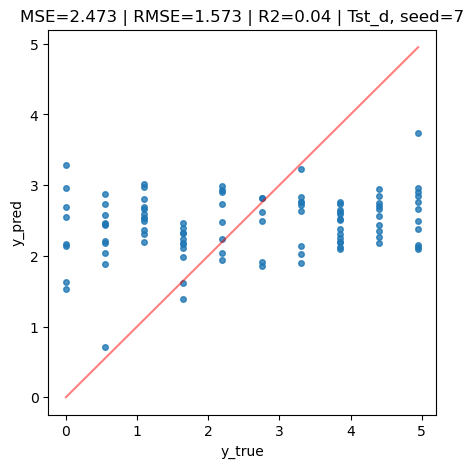

Full dataset:


ExactExplainer explainer: 1001it [00:40, 18.88it/s]                         


module of Input importance:


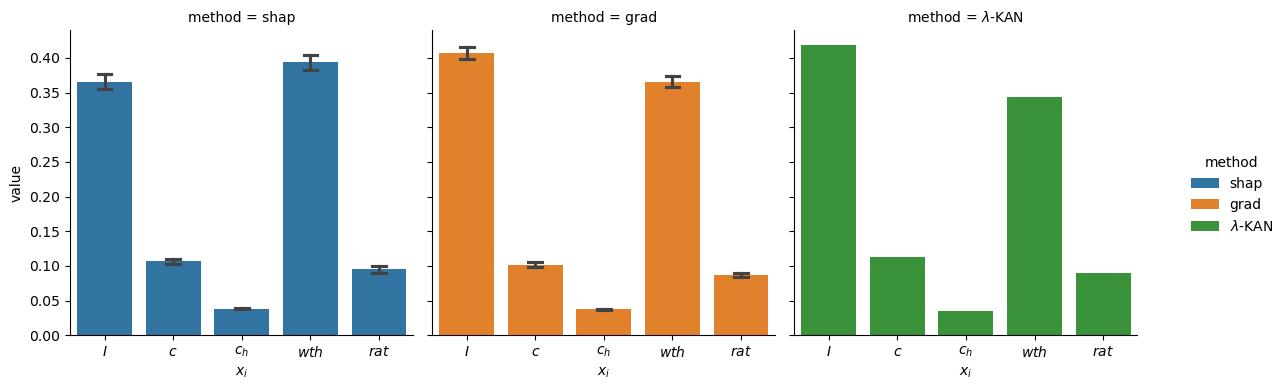

Input importance:


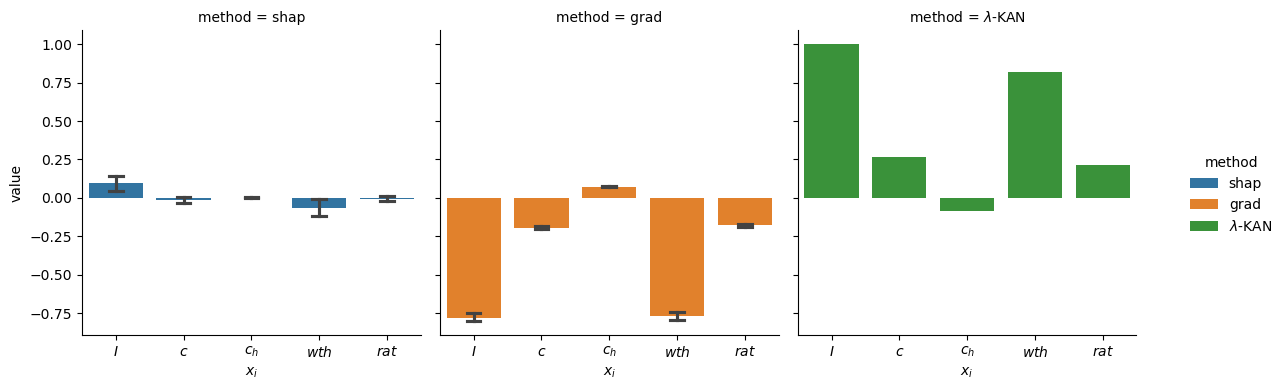

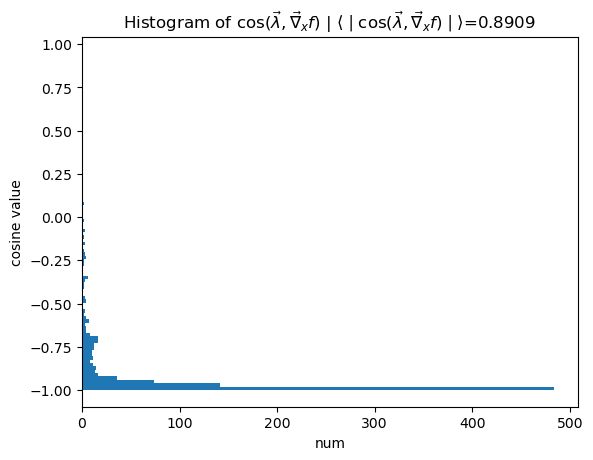

- seed=8 -
checkpoint directory created: ./model
saving model version 0.0


| trn_loss: 1.57e+00 | tst_loss: 1.59e+00 | e_stop: 10/10 | reg: 8.50e-01 | :  10%| | 10/100 [00:04<

Early stopping criteria raised
saving model version 0.1


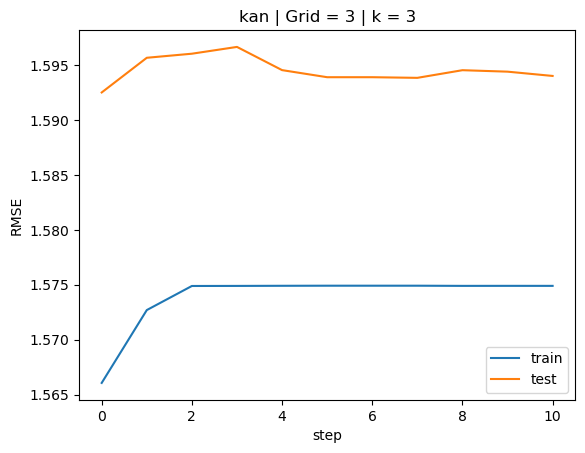

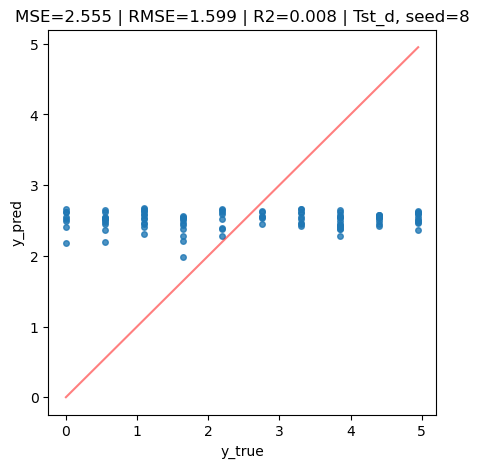

Full dataset:


ExactExplainer explainer: 1001it [00:40, 18.98it/s]                         


module of Input importance:


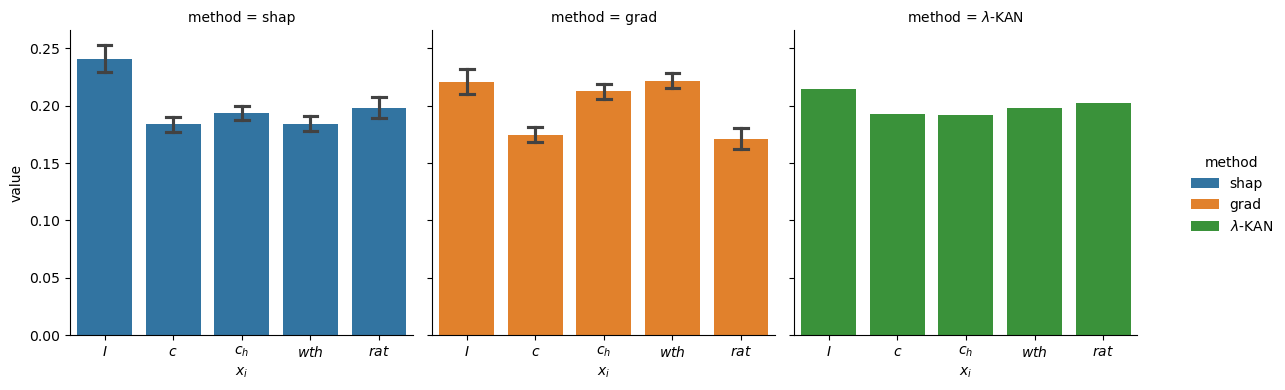

Input importance:


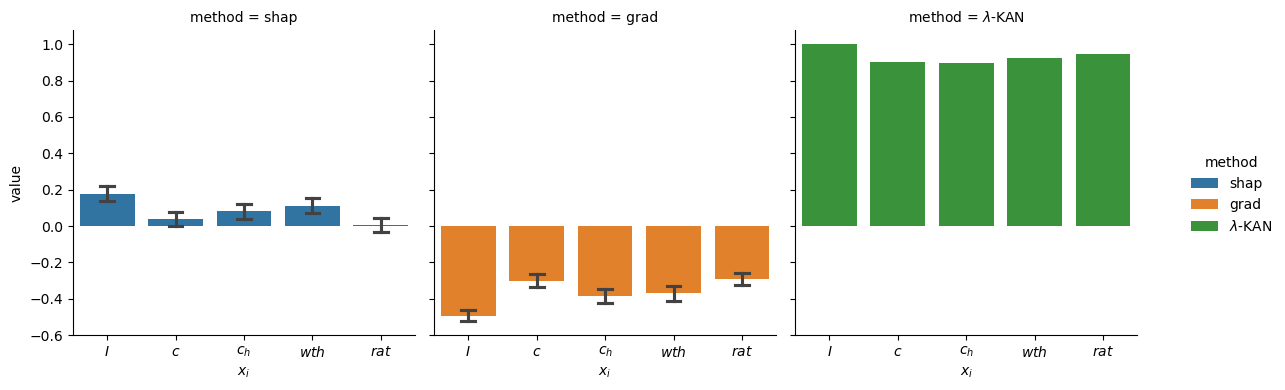

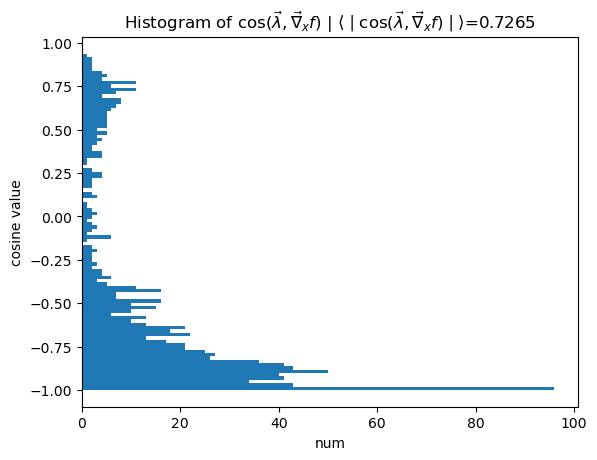

- seed=9 -
checkpoint directory created: ./model
saving model version 0.0


| trn_loss: 1.47e+00 | tst_loss: 1.66e+00 | e_stop: 10/10 | reg: 9.62e+00 | :  17%|▏| 17/100 [00:08<

Early stopping criteria raised
saving model version 0.1


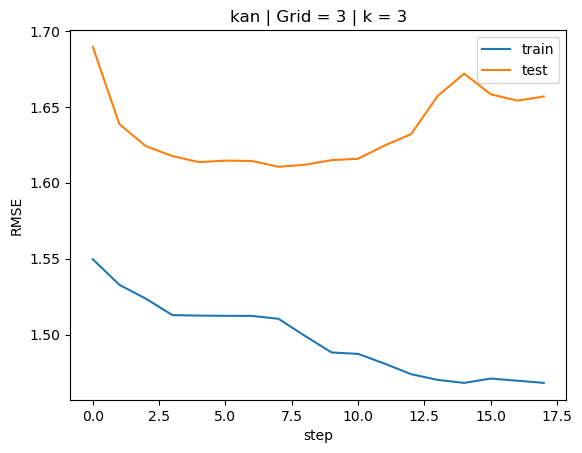

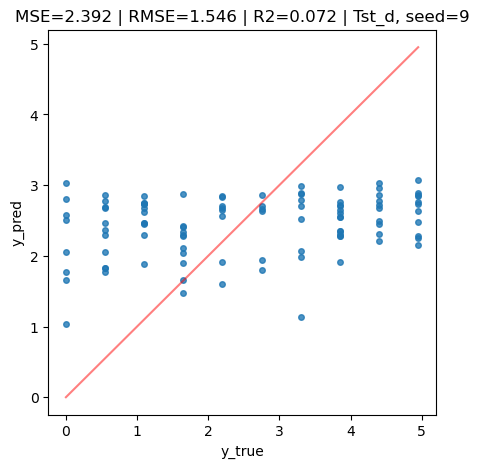

Full dataset:


ExactExplainer explainer: 1001it [00:41, 18.35it/s]                         


module of Input importance:


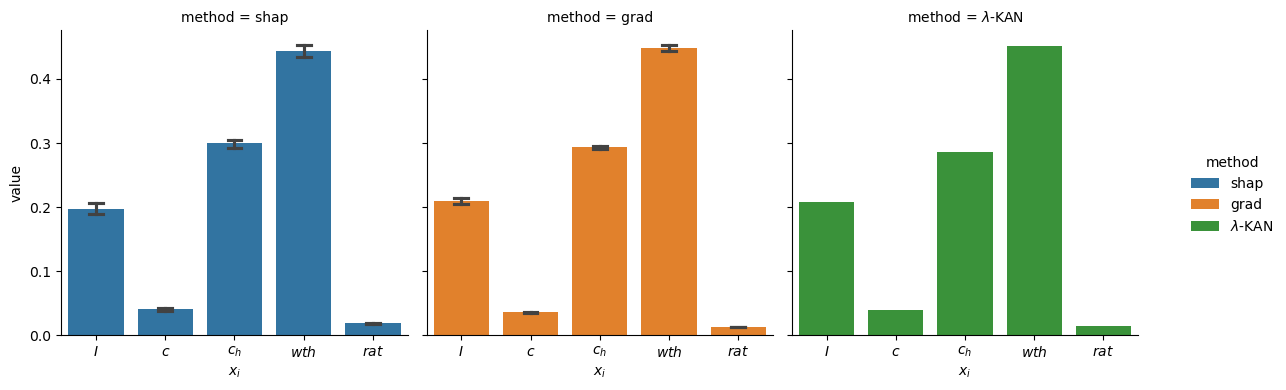

Input importance:


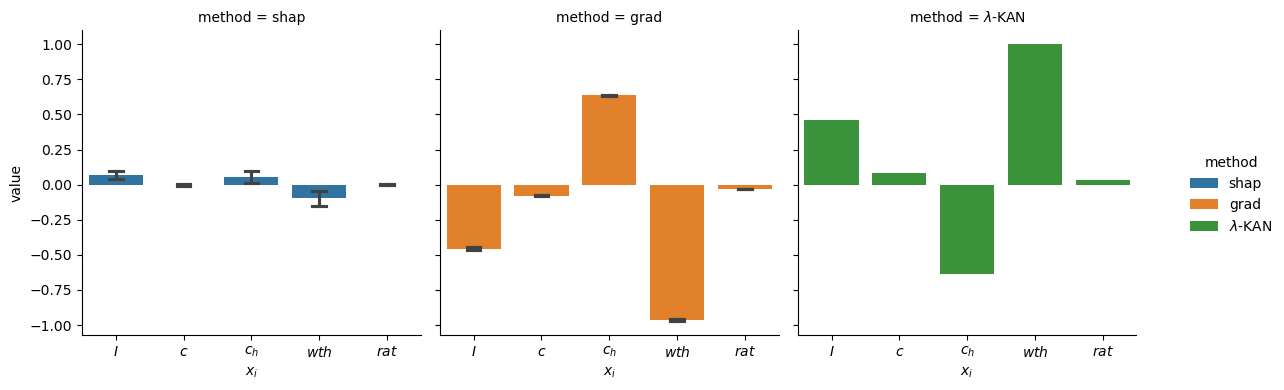

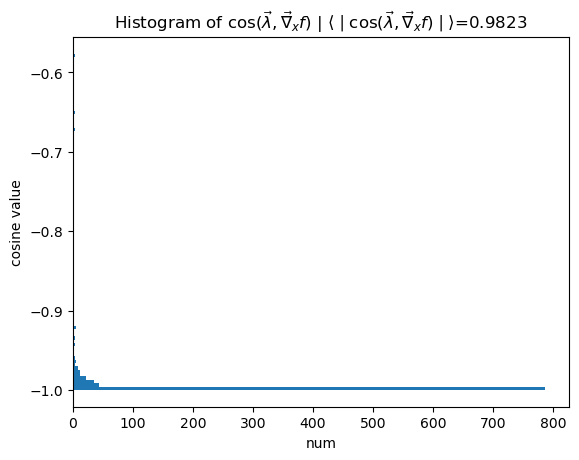

In [12]:
# FITTING KAN with different seed
l_seed = range(10)
grid = 3
k = 3

l_feature_scores = []

for seed in l_seed:
    print(f'==========\n- {seed=} -\n==========')
    model2 = lmdKANRegressor(hidden_layer_sizes=[5,2], seed=seed, grid=3, k=3, 
                       solver="lbfgs", max_iter=100, 
                       lamb=1e-2,
                       lamb_l1=1,
                       lamb_entropy=2)
    
    model2.fit(x_train, y_train)
    result2 = model2.kan.results
    
    #pred_test = model2.predict(x_test)
    pred_train = model2.predict(x_train)
    
    l_feature_scores.append(model2.kan.act_fun[0].lmd.detach().numpy())

    VAR = ['$I$', '$c$', '$c_h$', '$wth$', '$rat$']
    prnt_kwrgs = {'in_vars': VAR, 
                'out_vars': [PREDICT_IONS[0] + ' concentration'], 
                'title': None,
                'sample': True,
                'scale': 0.5,
                'scale_scatter': 0.5}
    
    #model2.kan.plot(**prnt_kwrgs, reper_in_out='out', reper_index=0, hist_plot=True)
    plt.show()

    plt.plot(result2['train_loss'])
    plt.plot(result2['test_loss'])
    #plt.plot(result2['reg'])
    plt.legend(['train', 'test']) #, 'reg'
    plt.title(f'kan | Grid = {grid} | k = {k}')
    plt.ylabel('RMSE')
    plt.xlabel('step')
    plt.show()

    scatter_prediction_skl(model2, x_test, y_test, f"Tst_d, seed={seed}")

    print('Full dataset:')
    importance_analyse_lmdKAN(model2.kan, dict(test_input=torch.tensor(scaler.transform(x), dtype=torch.float)))

    plt.show()
    
l_feature_scores = np.array(l_feature_scores)

In [13]:
l_feature_scores

array([[ 0.68282855,  0.44926488,  0.27478558,  0.4085596 ,  0.39371428],
       [ 1.1707137 ,  0.6808347 ,  0.68122214,  0.9278838 ,  0.694648  ],
       [ 0.7370137 , -0.12334109, -0.3098042 ,  0.84532547, -0.10786351],
       [ 1.1254073 ,  0.50295573,  0.5066379 ,  0.76090777,  0.45438045],
       [ 1.0129839 ,  0.560132  , -0.3575885 ,  1.0758177 ,  0.2957031 ],
       [ 0.17416929,  0.4361845 , -0.0773776 ,  0.17371461,  0.12585276],
       [ 0.46959576,  0.06888656, -0.6317862 ,  1.0437175 ,  0.00172484],
       [ 1.3223679 ,  0.35429358, -0.11297651,  1.0854554 ,  0.28208238],
       [ 0.9545331 ,  0.86030596,  0.8566723 ,  0.8842592 ,  0.9030172 ],
       [ 0.56272465,  0.10445878, -0.77287096,  1.2185019 ,  0.03843729]],
      dtype=float32)

- seed=1 -
checkpoint directory created: ./model
saving model version 0.0


| trn_loss: 1.50e+00 | tst_loss: 1.66e+00 | e_stop: 10/10 | reg: 1.12e+01 | :  15%|▏| 15/100 [00:08<


Early stopping criteria raised
saving model version 0.1


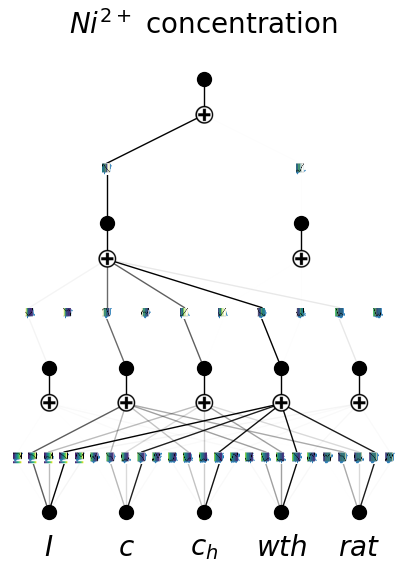

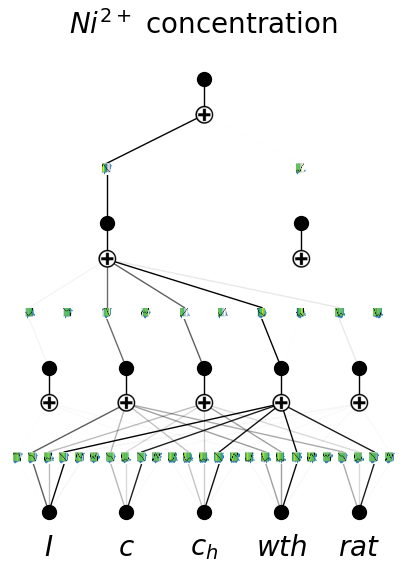

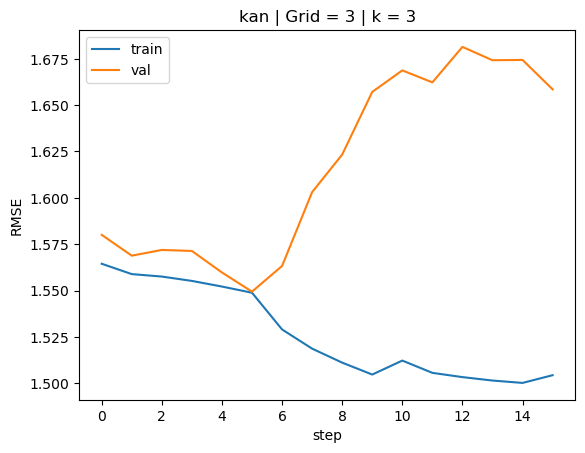

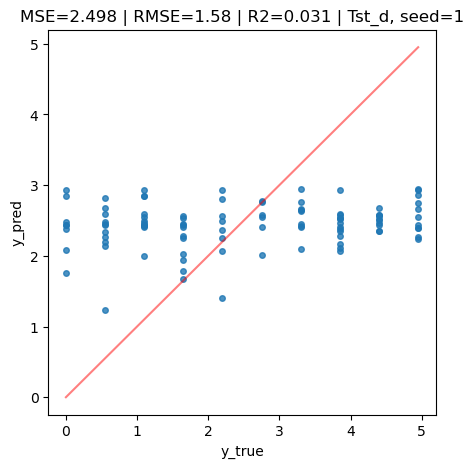

Full dataset:


ExactExplainer explainer: 1001it [00:47, 16.64it/s]                         


module of Input importance:


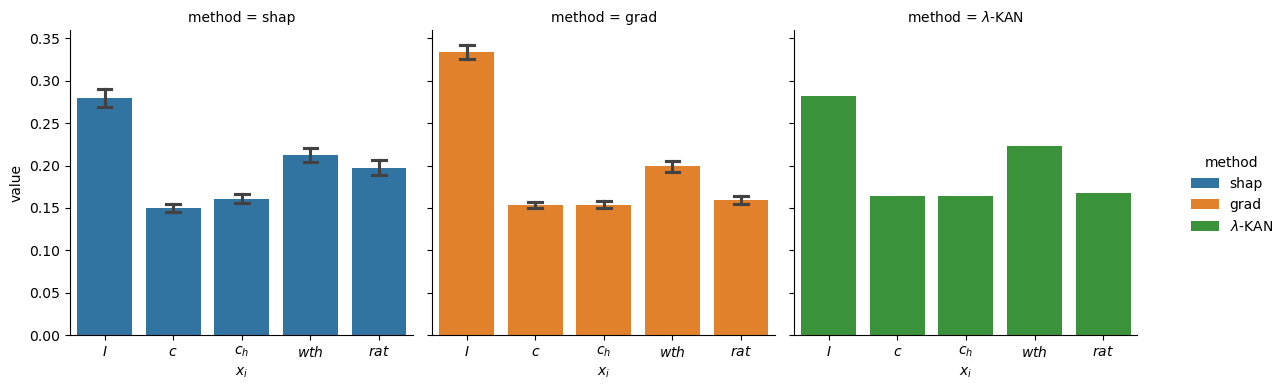

Input importance:


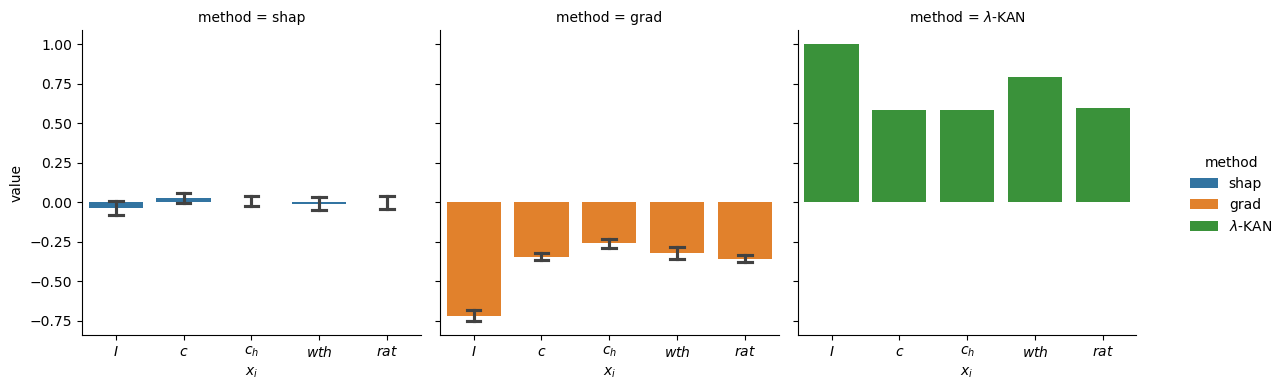

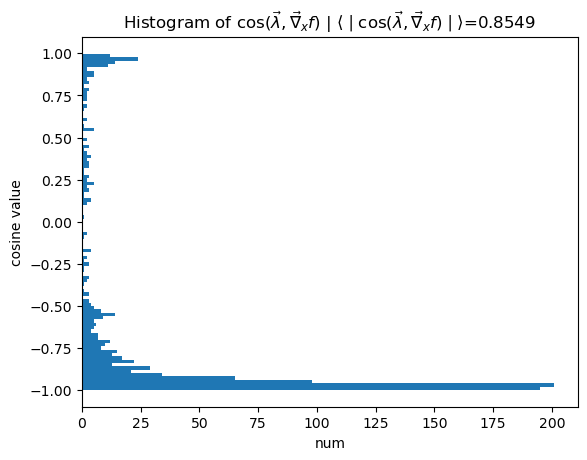

In [10]:
grid = 3
k = 3

# Choose seed and train again
seed = 1
print(f'==========\n- {seed=} -\n==========')
model2 = lmdKANRegressor(hidden_layer_sizes=[5,2,], seed=seed, grid=grid, k=k, 
                   solver="lbfgs", max_iter=100, 
                   lamb=1e-2,
                   lamb_l1=1,
                   lamb_entropy=2)

model2.fit(x_train, y_train)
result2 = model2.kan.results

#pred_test = model2.predict(x_test)
pred_train = model2.predict(x_train)
VAR = ['$I$', '$c$', '$c_h$', '$wth$', '$rat$']
prnt_kwrgs = {'in_vars': VAR, 
            'out_vars': [PREDICT_ION_NAME + ' concentration'], 
            'title': None,
            'sample': True,
            'scale': 0.5,
            'scale_scatter': 0.5}

model2.kan.plot(**prnt_kwrgs, reper_in_out='in', reper_index=0, hist_plot=True)
model2.kan.plot(**prnt_kwrgs, reper_in_out='out', reper_index=0, hist_plot=True)
plt.show()
plt.plot(result2['train_loss'])
plt.plot(result2['test_loss'])
#plt.plot(result2['reg'])
plt.legend(['train', 'val']) #, 'reg'
plt.title(f'kan | Grid = {grid} | k = {k}')
plt.ylabel('RMSE')
plt.xlabel('step')
plt.show()
scatter_prediction_skl(model2, x_test, y_test, f"Tst_d, seed={seed}")
print('Full dataset:')
importance_analyse_lmdKAN(model2.kan, dict(test_input=torch.tensor(scaler.transform(x), dtype=torch.float)))
plt.show()

# $NO_3$

In [11]:
# PREPARING DATA + PairPlot
PREDICT_IONS = ['NO3']# ['Cr'], ['Cu'], ['Ni'], ['NO3']# d_config['PREDICT_IONS']
PREDICT_ION_NAME = '$NO_{3}^{-}$'
y = get_y(l_ions=PREDICT_IONS, spec_file=""+SPEC_FOLDER)


squeezed_df = pd.DataFrame(np.concatenate([x, y.reshape([-1,1])], axis=1), columns=['$I$', '$c$', '$c_h$', '$wth$', '$rat$', PREDICT_IONS[0] + ' concentration'])
#sns.pairplot(squeezed_df)

x_train, x_test, y_train, y_test = train_test_split(x, y, 
                                                    train_size=TRAIN_TEST_RATIO,
                                                    random_state=42)

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

'''
scalerY = StandardScaler()
y_train = scalerY.fit_transform(y_train.reshape(-1, 1))
y_test = scalerY.transform(y_test.reshape(-1, 1))
'''
INPUT_SHAPE = x_train.shape[1]

- seed=0 -
checkpoint directory created: ./model
saving model version 0.0


| trn_loss: 2.87e+00 | tst_loss: 2.83e+00 | e_stop: 10/10 | reg: 2.58e+01 | :  27%|▎| 27/100 [00:12<

Early stopping criteria raised
saving model version 0.1


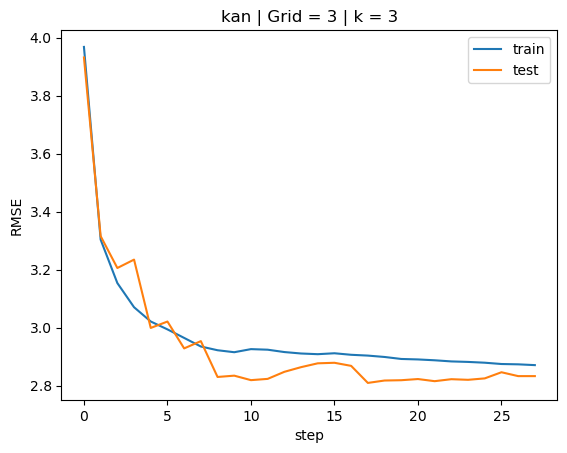

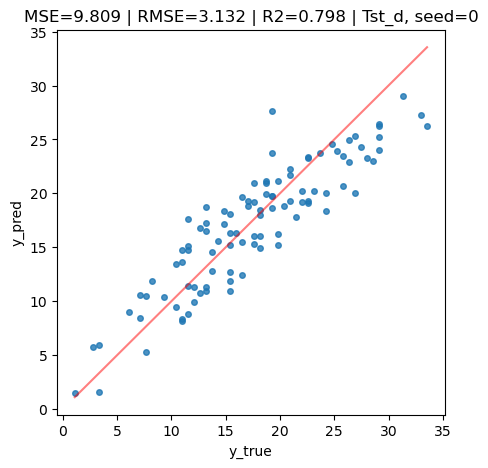

Full dataset:


ExactExplainer explainer: 1001it [00:39, 19.43it/s]                          


module of Input importance:


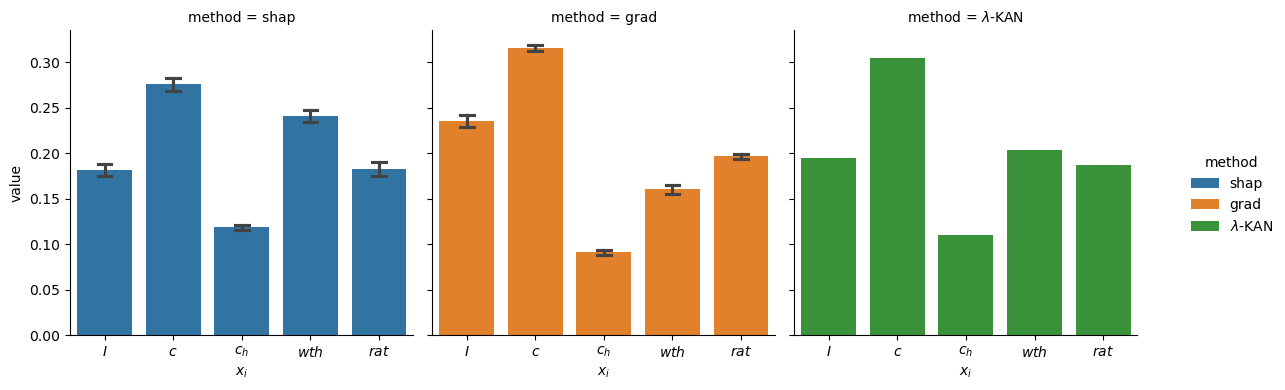

Input importance:


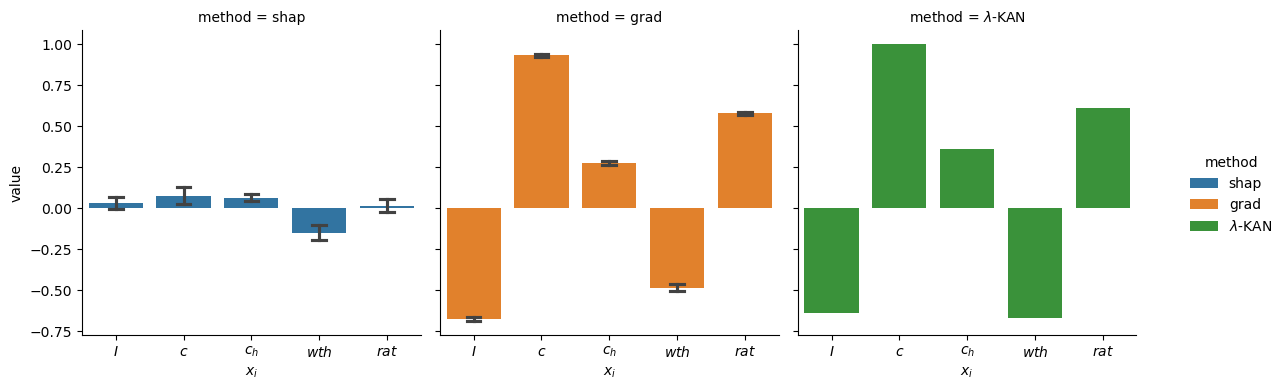

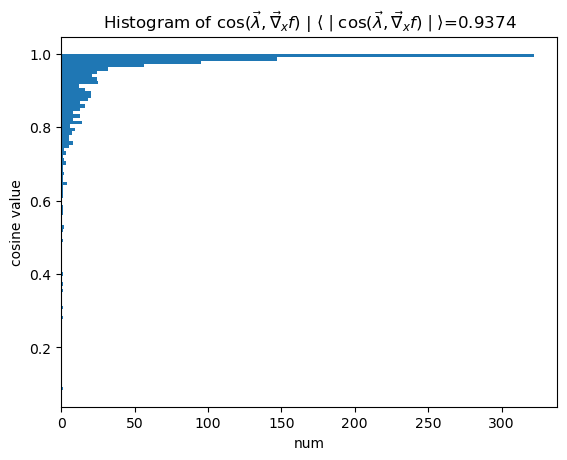

- seed=1 -
checkpoint directory created: ./model
saving model version 0.0


| trn_loss: 2.98e+00 | tst_loss: 3.23e+00 | e_stop: 10/10 | reg: 4.77e+01 | :  38%|▍| 38/100 [00:18<

Early stopping criteria raised
saving model version 0.1


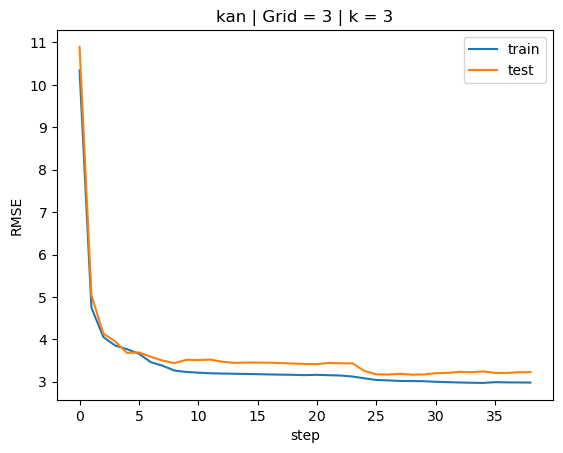

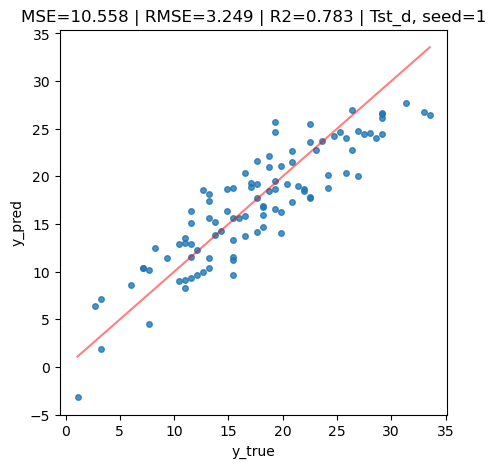

Full dataset:


ExactExplainer explainer: 1001it [00:39, 19.22it/s]                          


module of Input importance:


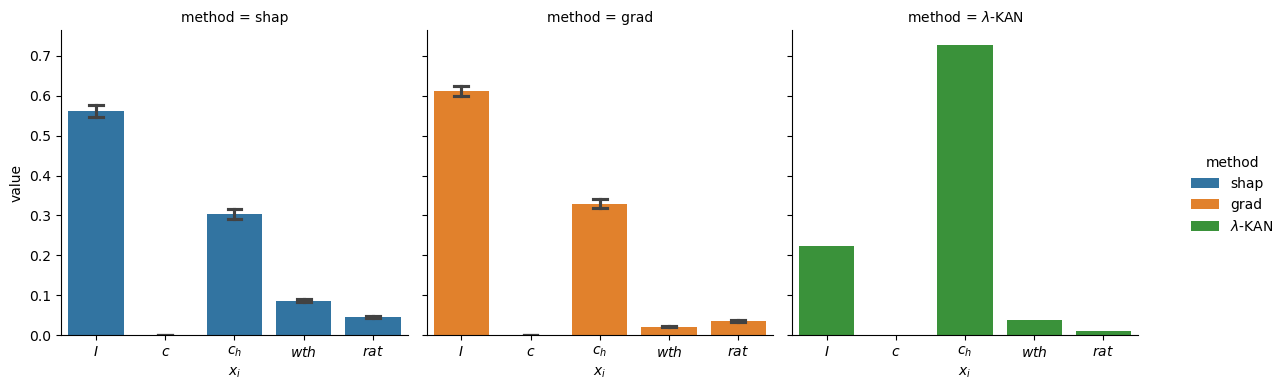

Input importance:


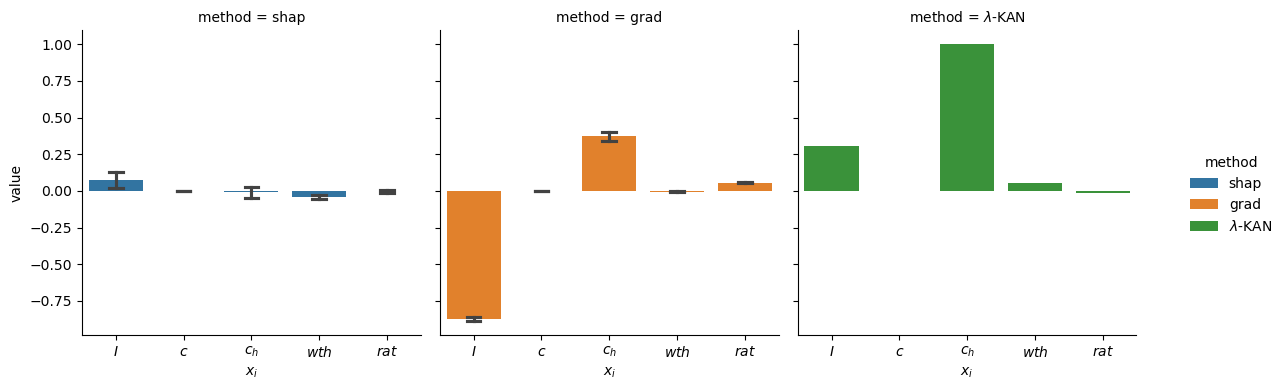

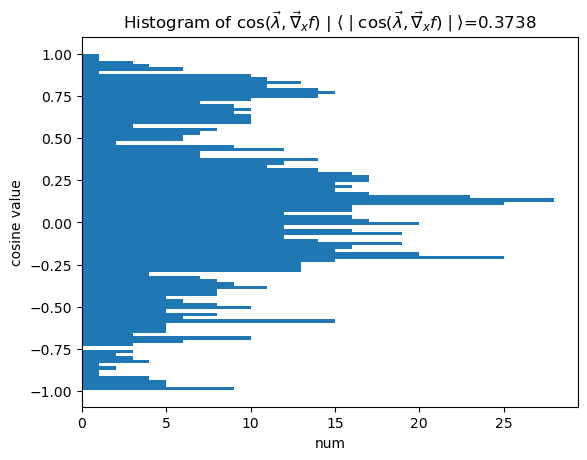

- seed=2 -
checkpoint directory created: ./model
saving model version 0.0


| trn_loss: 2.83e+00 | tst_loss: 2.96e+00 | e_stop: 10/10 | reg: 3.15e+01 | :  18%|▏| 18/100 [00:08<


Early stopping criteria raised
saving model version 0.1


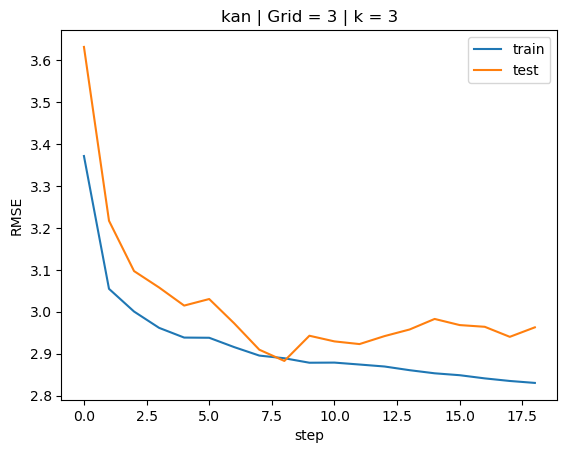

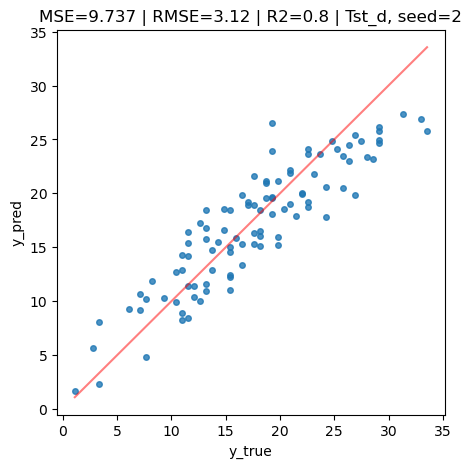

Full dataset:


ExactExplainer explainer: 1001it [00:39, 19.50it/s]                         


module of Input importance:


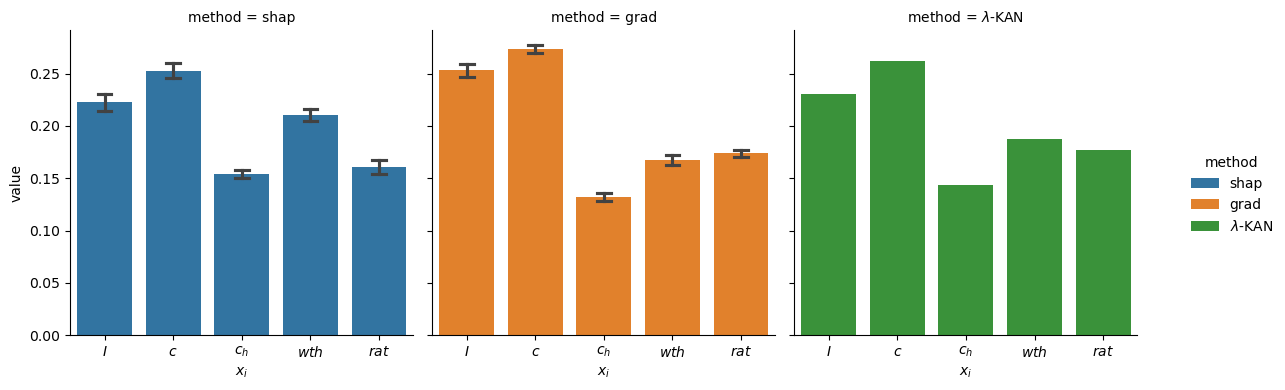

Input importance:


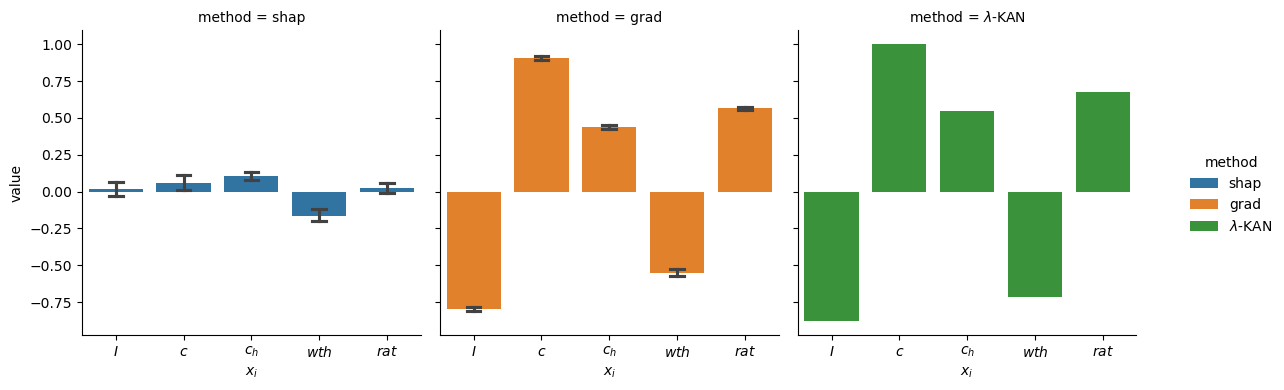

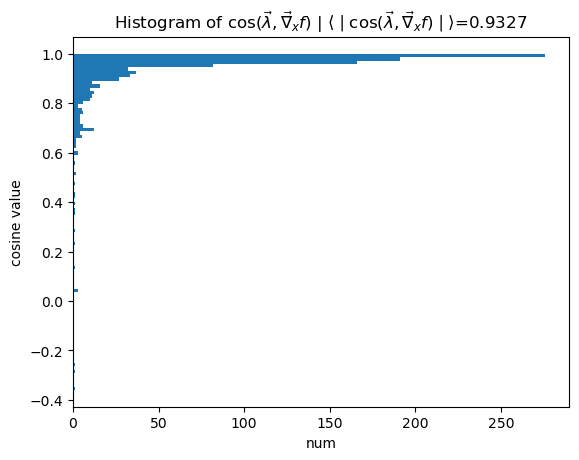

- seed=3 -
checkpoint directory created: ./model
saving model version 0.0


| trn_loss: 2.94e+00 | tst_loss: 2.95e+00 | e_stop: 10/10 | reg: 2.71e+01 | :  14%|▏| 14/100 [00:06<


Early stopping criteria raised
saving model version 0.1


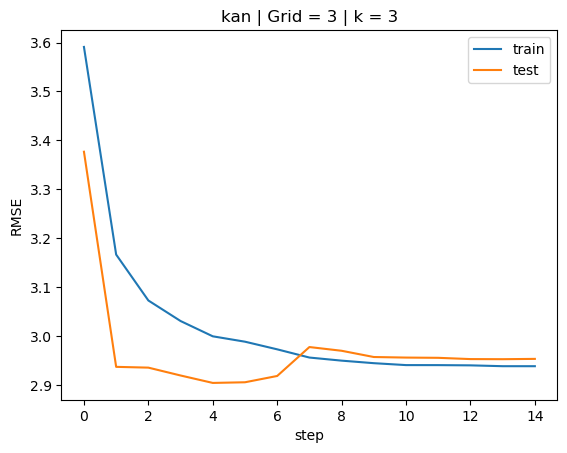

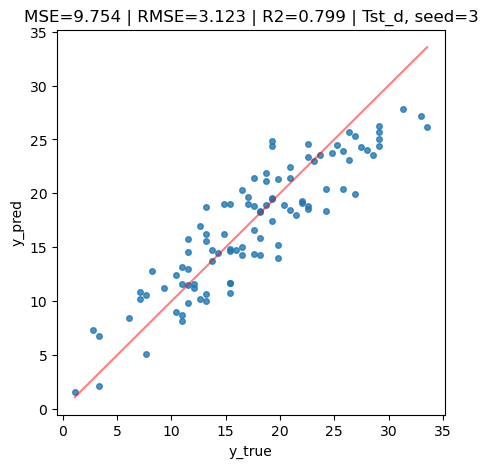

Full dataset:


ExactExplainer explainer: 1001it [00:39, 19.28it/s]                         


module of Input importance:


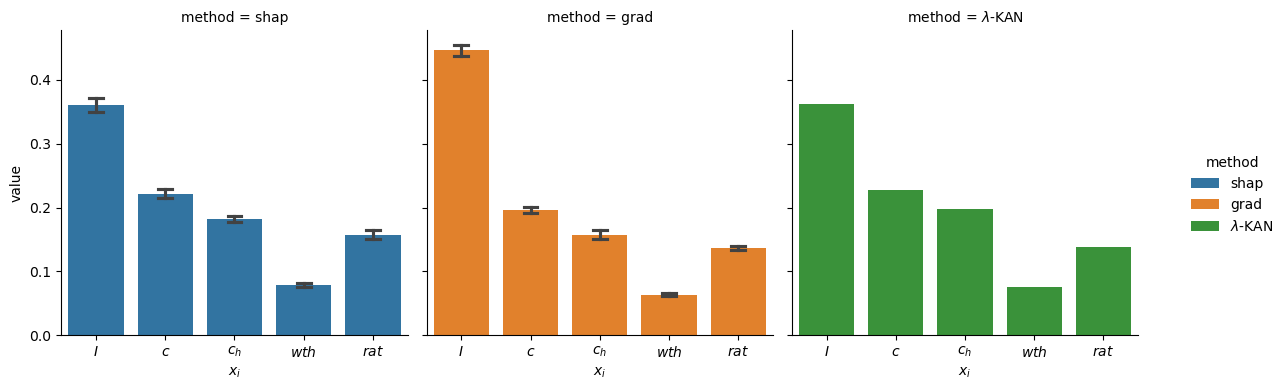

Input importance:


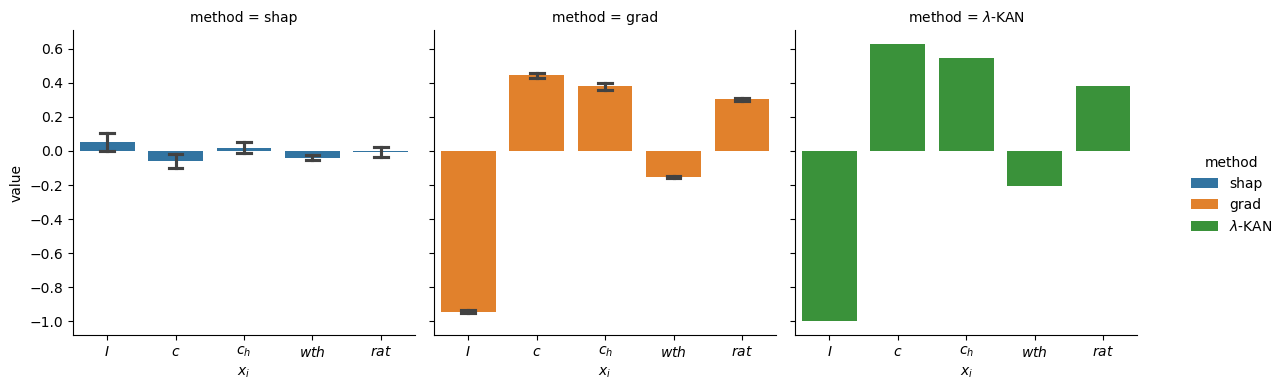

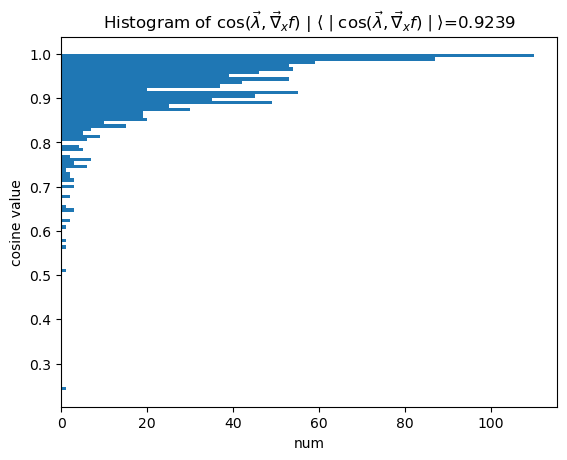

- seed=4 -
checkpoint directory created: ./model
saving model version 0.0


| trn_loss: 2.88e+00 | tst_loss: 2.99e+00 | e_stop: 10/10 | reg: 3.32e+01 | :  25%|▎| 25/100 [00:11<

Early stopping criteria raised
saving model version 0.1


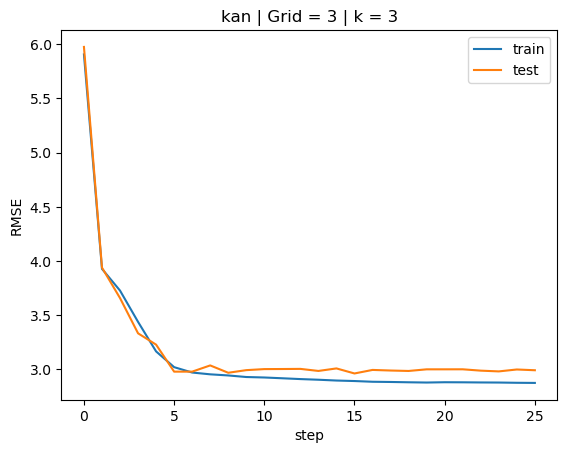

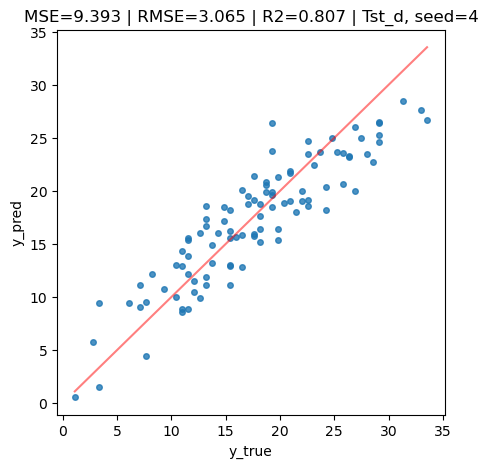

Full dataset:


ExactExplainer explainer: 1001it [00:39, 19.36it/s]                          


module of Input importance:


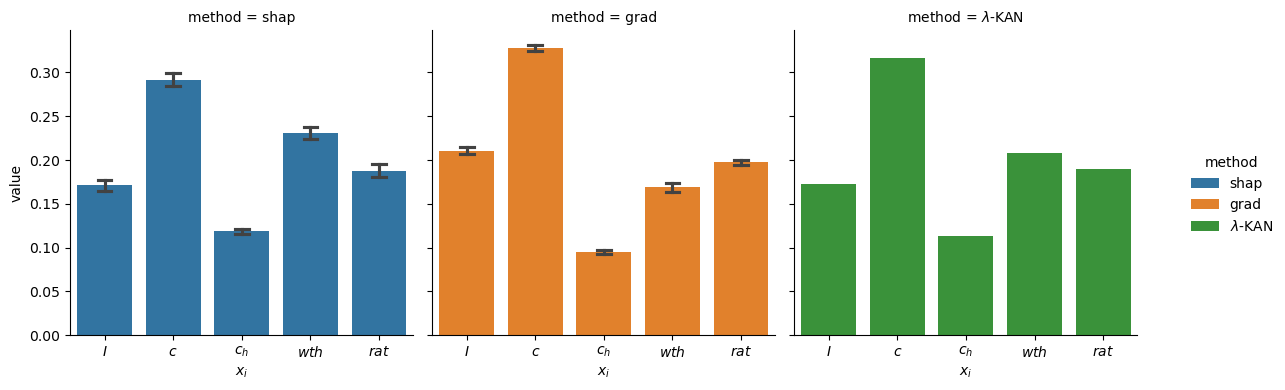

Input importance:


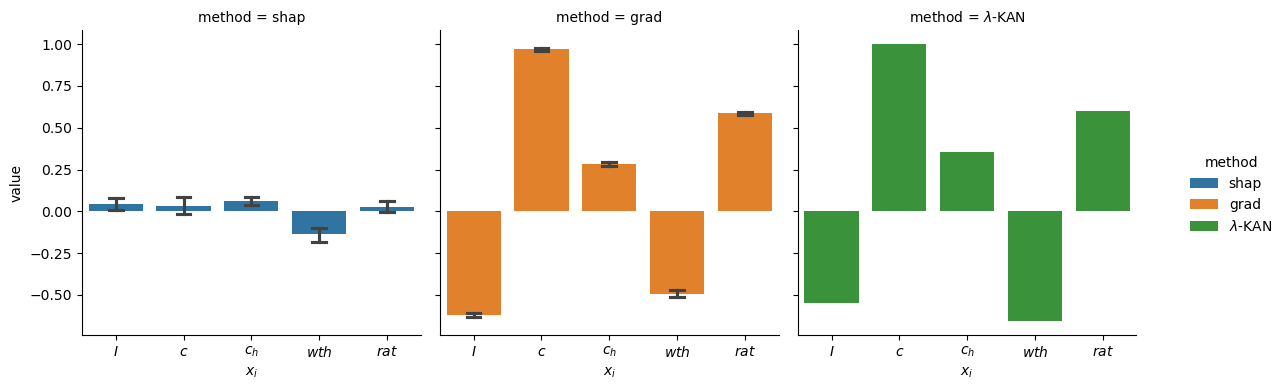

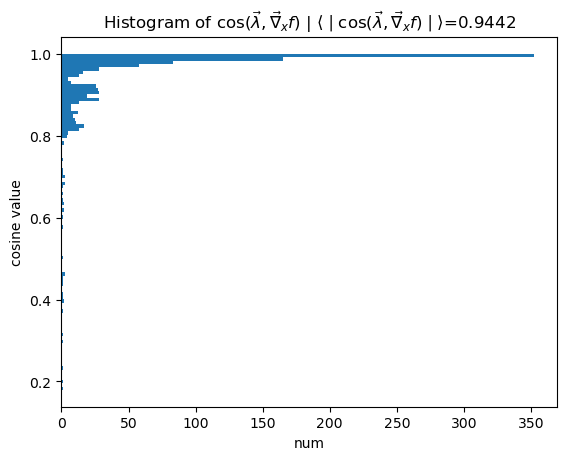

- seed=5 -
checkpoint directory created: ./model
saving model version 0.0


| trn_loss: 2.94e+00 | tst_loss: 3.00e+00 | e_stop: 10/10 | reg: 2.94e+01 | :  22%|▏| 22/100 [00:07<

Early stopping criteria raised
saving model version 0.1


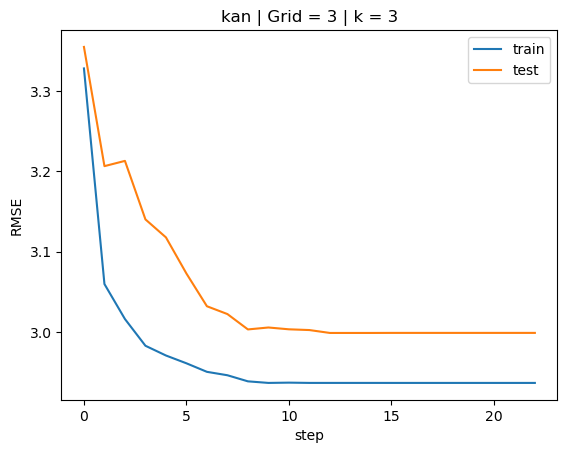

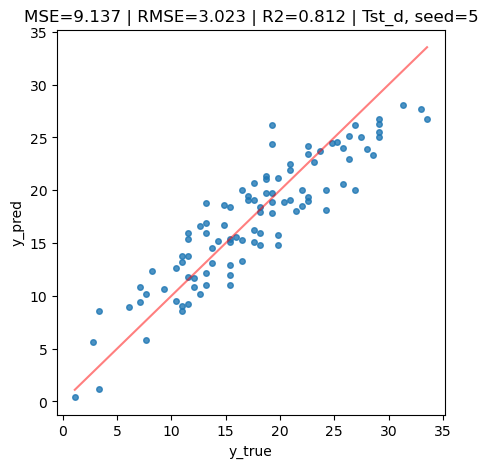

Full dataset:


ExactExplainer explainer: 1001it [00:39, 19.12it/s]                         


module of Input importance:


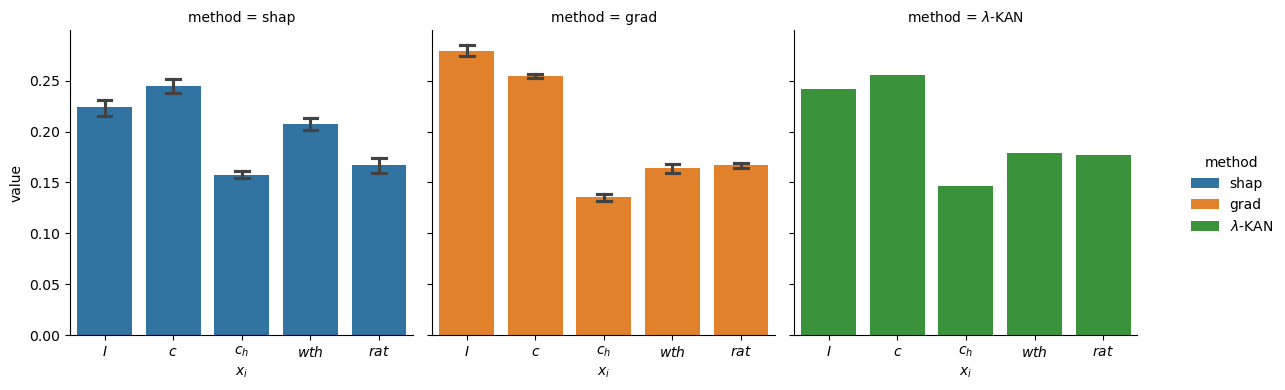

Input importance:


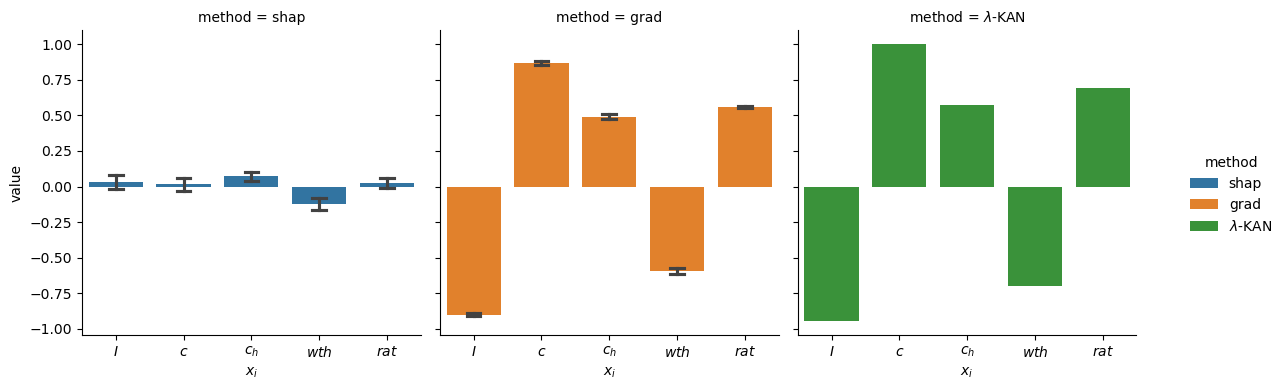

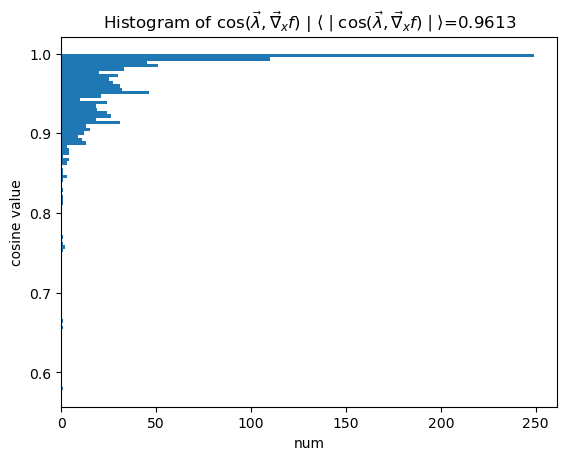

- seed=6 -
checkpoint directory created: ./model
saving model version 0.0


| trn_loss: 2.90e+00 | tst_loss: 2.99e+00 | e_stop: 10/10 | reg: 2.89e+01 | :  16%|▏| 16/100 [00:09<

Early stopping criteria raised
saving model version 0.1


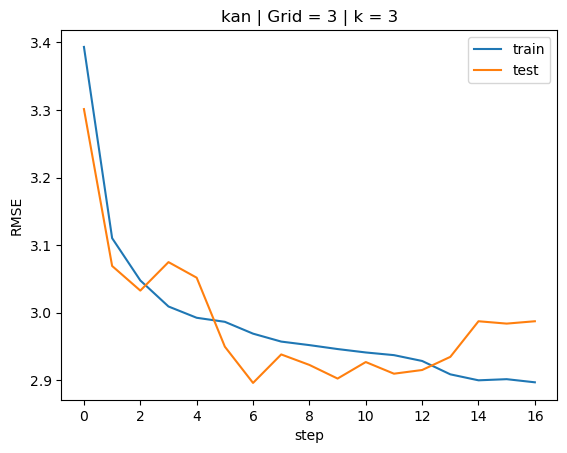

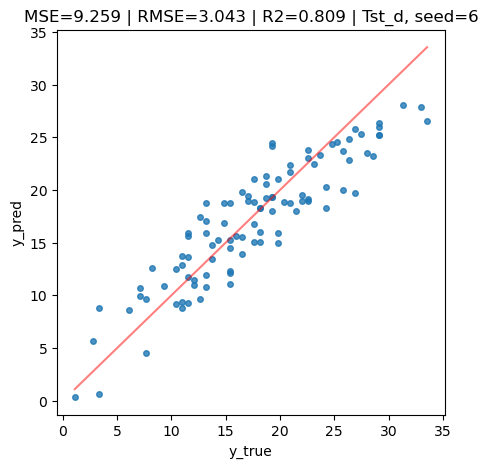

Full dataset:


ExactExplainer explainer: 1001it [00:44, 17.95it/s]                          


module of Input importance:


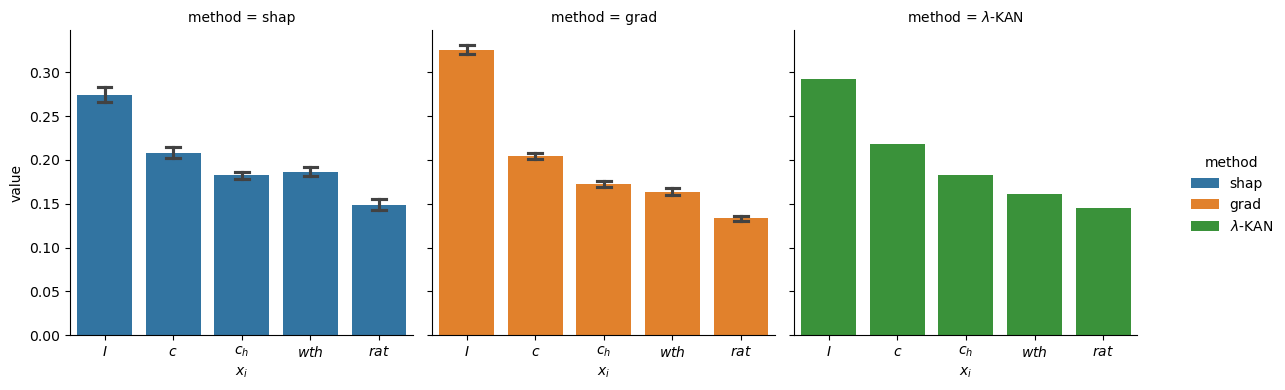

Input importance:


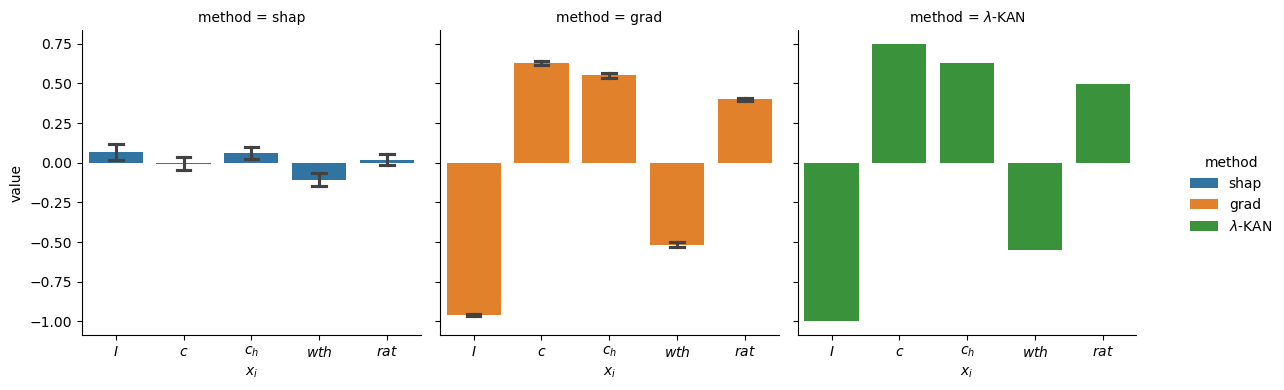

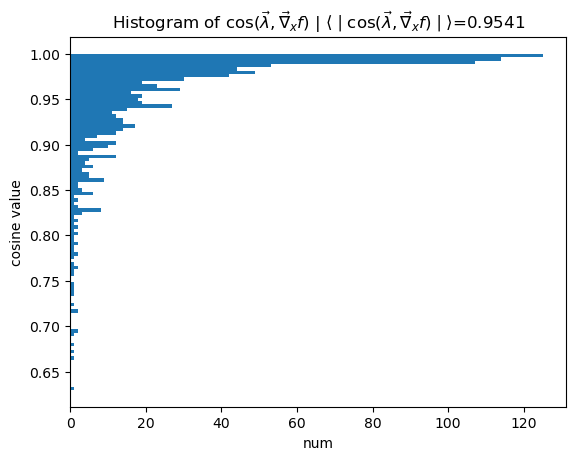

- seed=7 -
checkpoint directory created: ./model
saving model version 0.0


| trn_loss: 3.00e+00 | tst_loss: 2.95e+00 | e_stop: 10/10 | reg: 3.62e+01 | :  37%|▎| 37/100 [00:19<

Early stopping criteria raised
saving model version 0.1


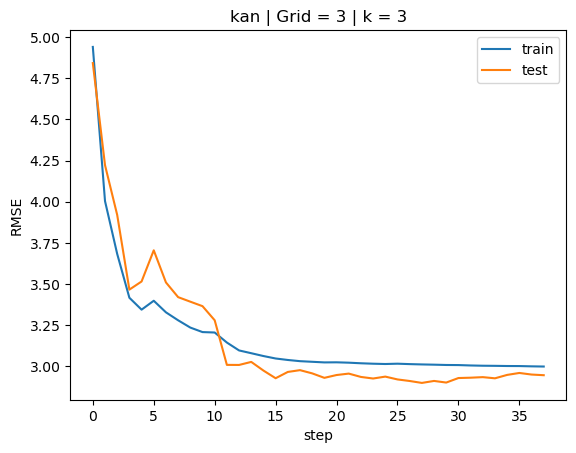

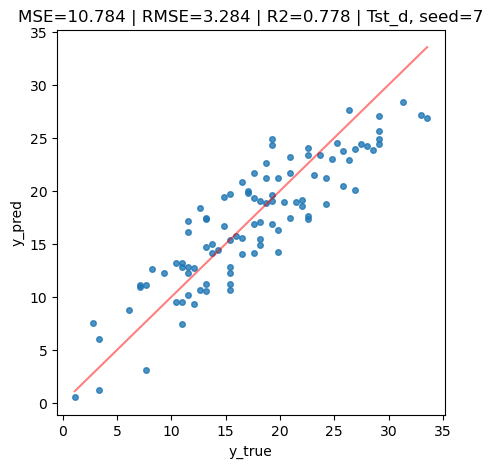

Full dataset:


ExactExplainer explainer: 1001it [00:41, 18.64it/s]                         


module of Input importance:


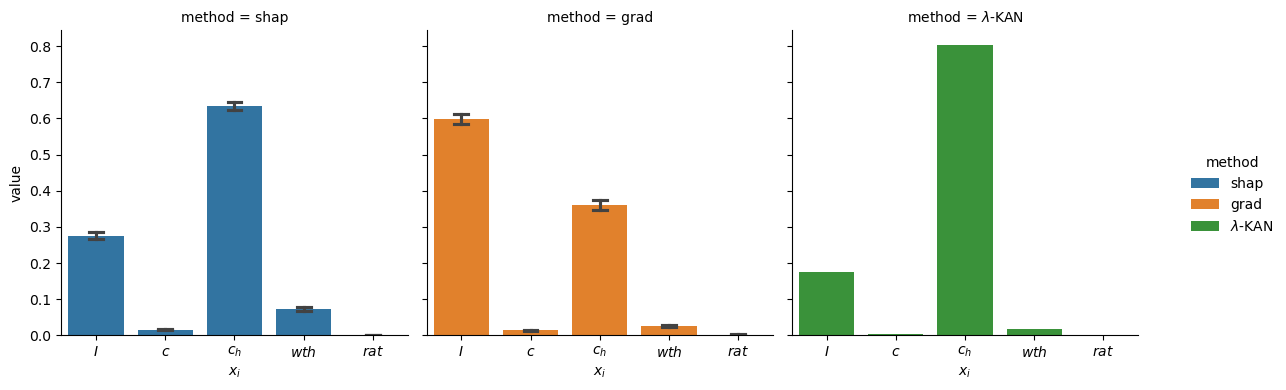

Input importance:


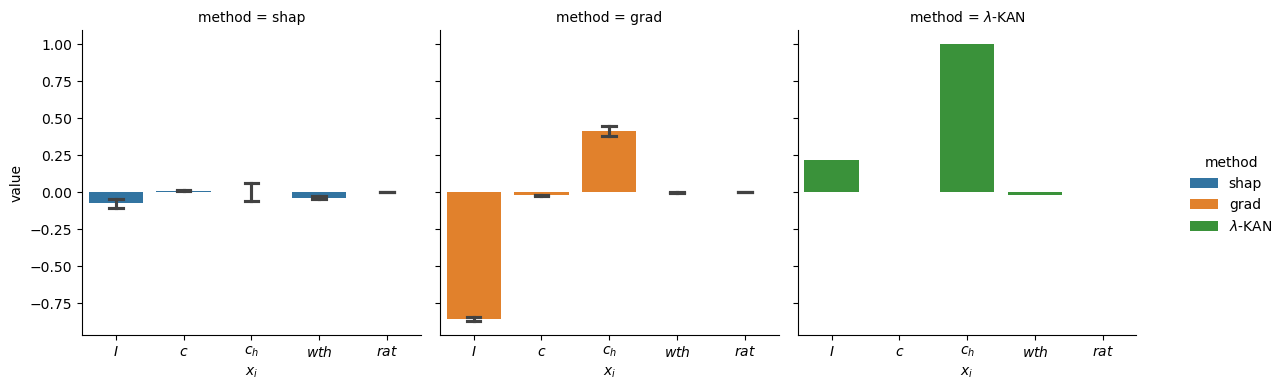

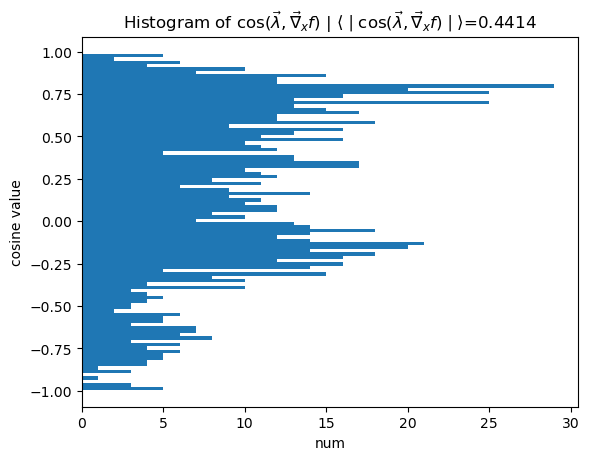

- seed=8 -
checkpoint directory created: ./model
saving model version 0.0


| trn_loss: 2.89e+00 | tst_loss: 3.08e+00 | e_stop: 10/10 | reg: 3.20e+01 | :  22%|▏| 22/100 [00:10<

Early stopping criteria raised
saving model version 0.1


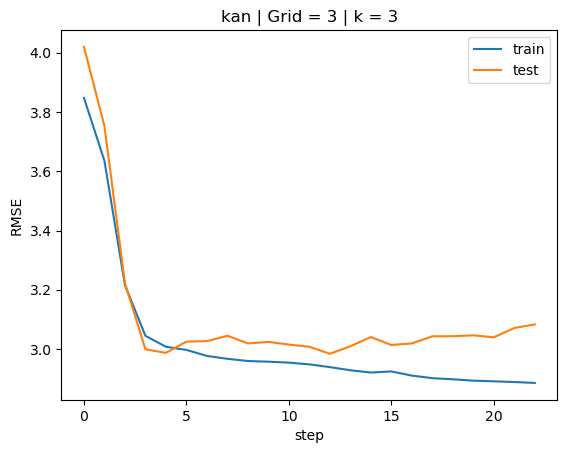

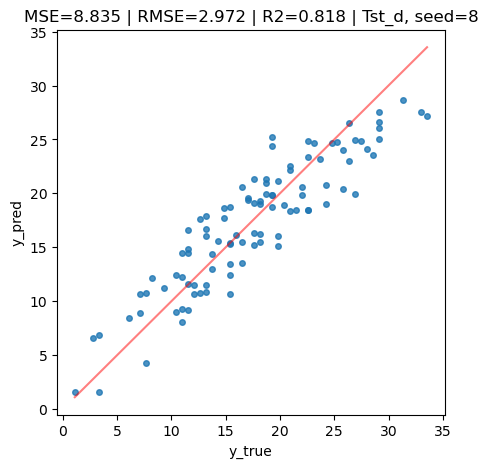

Full dataset:


ExactExplainer explainer: 1001it [00:45, 16.91it/s]                          


module of Input importance:


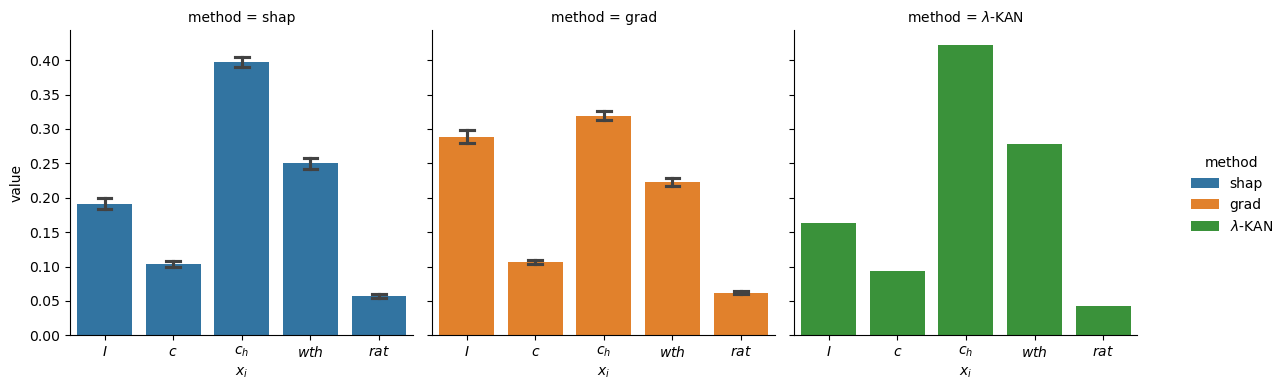

Input importance:


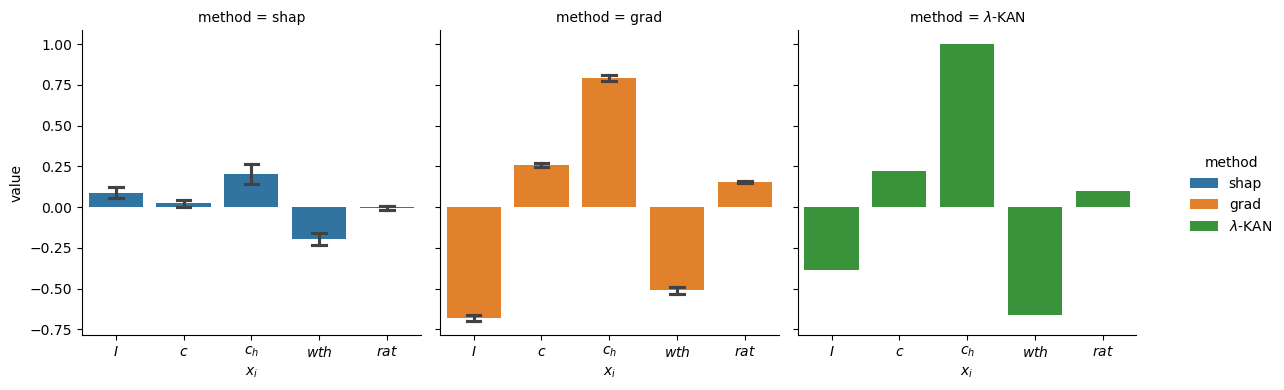

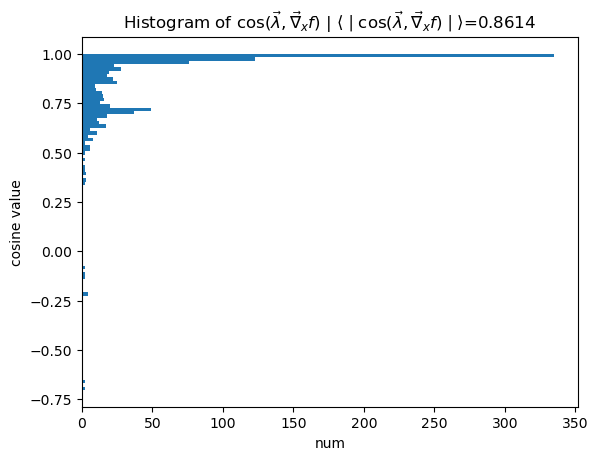

- seed=9 -
checkpoint directory created: ./model
saving model version 0.0


| trn_loss: 2.91e+00 | tst_loss: 3.51e+00 | e_stop: 10/10 | reg: 3.68e+01 | :  18%|▏| 18/100 [00:09<

Early stopping criteria raised
saving model version 0.1


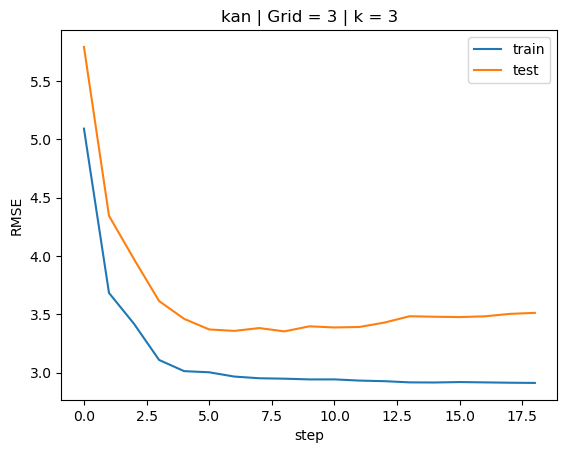

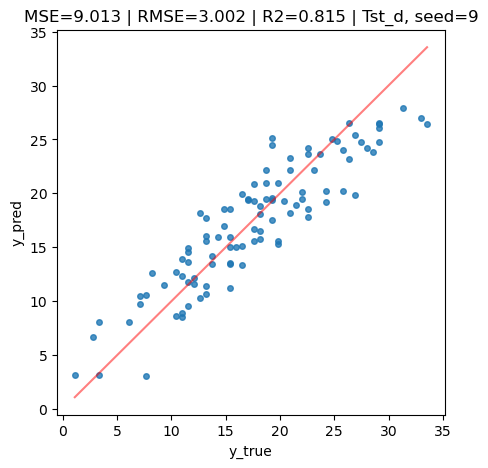

Full dataset:


ExactExplainer explainer: 1001it [00:42, 18.58it/s]                         


module of Input importance:


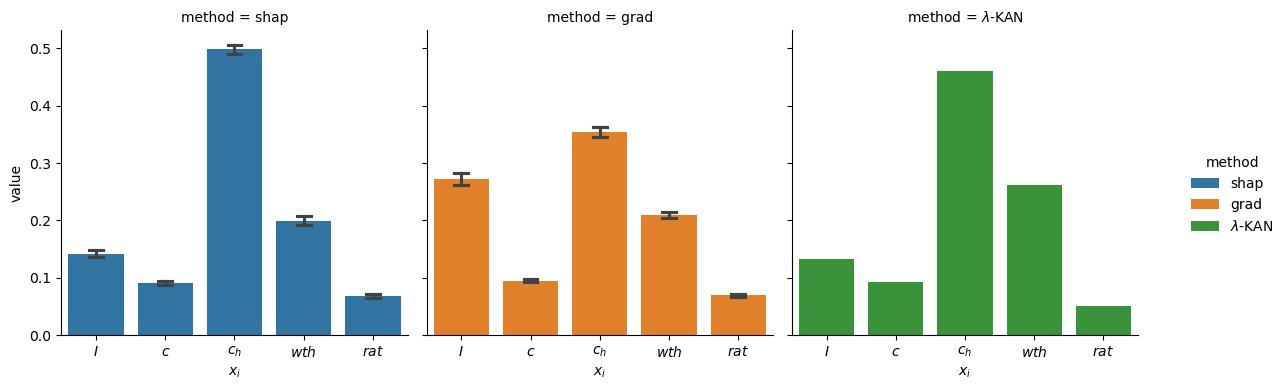

Input importance:


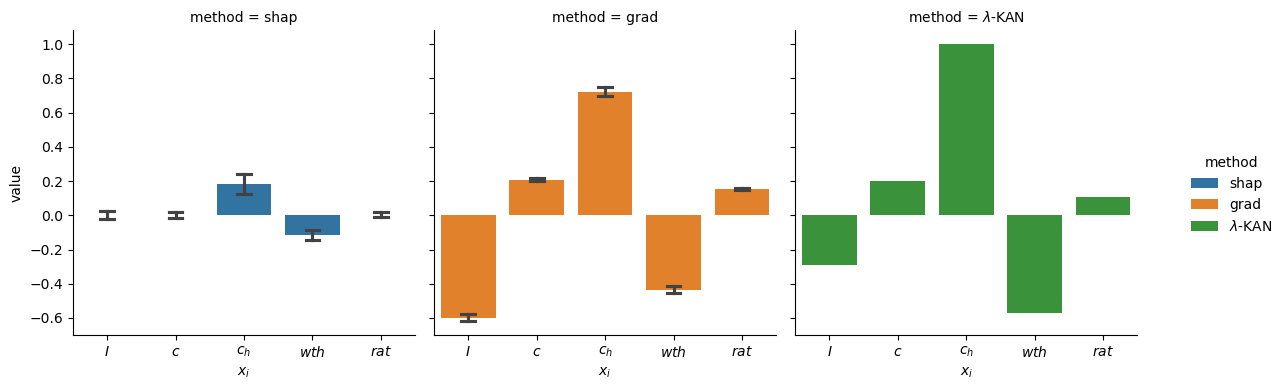

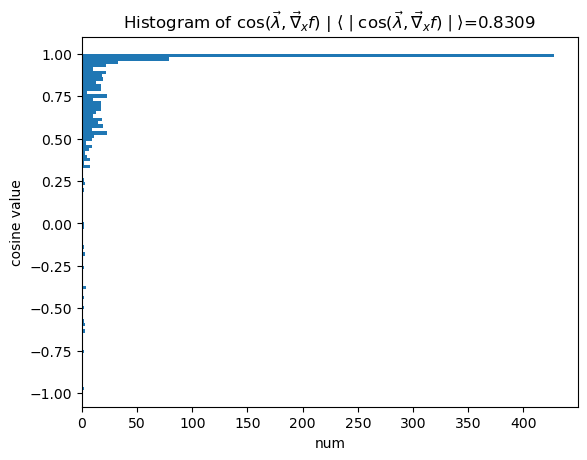

In [16]:
# FITTING KAN with different seed
l_seed = range(10)
grid = 3
k = 3

l_feature_scores = []

for seed in l_seed:
    print(f'==========\n- {seed=} -\n==========')
    model2 = lmdKANRegressor(hidden_layer_sizes=[5,2], seed=seed, grid=3, k=3, 
                       solver="lbfgs", max_iter=100, 
                       lamb=1e-2,
                       lamb_l1=1,
                       lamb_entropy=2)
    
    model2.fit(x_train, y_train)
    result2 = model2.kan.results
    
    #pred_test = model2.predict(x_test)
    pred_train = model2.predict(x_train)
    
    l_feature_scores.append(model2.kan.act_fun[0].lmd.detach().numpy())

    VAR = ['$I$', '$c$', '$c_h$', '$wth$', '$rat$']
    prnt_kwrgs = {'in_vars': VAR, 
                'out_vars': [PREDICT_IONS[0] + ' concentration'], 
                'title': None,
                'sample': True,
                'scale': 0.5,
                'scale_scatter': 0.5}
    
    #model2.kan.plot(**prnt_kwrgs, reper_in_out='out', reper_index=0, hist_plot=True)
    plt.show()

    plt.plot(result2['train_loss'])
    plt.plot(result2['test_loss'])
    #plt.plot(result2['reg'])
    plt.legend(['train', 'test']) #, 'reg'
    plt.title(f'kan | Grid = {grid} | k = {k}')
    plt.ylabel('RMSE')
    plt.xlabel('step')
    plt.show()

    scatter_prediction_skl(model2, x_test, y_test, f"Tst_d, seed={seed}")

    print('Full dataset:')
    importance_analyse_lmdKAN(model2.kan, dict(test_input=torch.tensor(scaler.transform(x), dtype=torch.float)))

    plt.show()
    
l_feature_scores = np.array(l_feature_scores)

In [17]:
l_feature_scores

array([[-1.9349512e+00,  3.0305810e+00,  1.0926901e+00, -2.0260363e+00,
         1.8585087e+00],
       [ 6.9445610e-01, -1.4852418e-03,  2.2595079e+00,  1.1602950e-01,
        -3.5871223e-02],
       [-2.4327745e+00,  2.7595682e+00,  1.5109520e+00, -1.9804192e+00,
         1.8613700e+00],
       [-5.4506516e+00,  3.4149394e+00,  2.9720407e+00, -1.1326404e+00,
         2.0665648e+00],
       [-1.0228932e+00,  1.8718528e+00,  6.6821849e-01, -1.2345060e+00,
         1.1233964e+00],
       [-3.5122907e+00,  3.7047544e+00,  2.1295457e+00, -2.5973294e+00,
         2.5617616e+00],
       [-3.8749499e+00,  2.8971598e+00,  2.4291835e+00, -2.1282730e+00,
         1.9180022e+00],
       [ 4.8634937e-01,  8.7774266e-03,  2.2197316e+00, -4.6054747e-02,
        -1.0848469e-03],
       [-1.1717534e+00,  6.6836220e-01,  3.0320444e+00, -2.0009215e+00,
         3.0628347e-01],
       [-1.1570495e+00,  8.0548692e-01,  3.9901915e+00, -2.2685077e+00,
         4.3749341e-01]], dtype=float32)

- seed=2 -
checkpoint directory created: ./model
saving model version 0.0


| trn_loss: 2.83e+00 | tst_loss: 2.96e+00 | e_stop: 10/10 | reg: 3.15e+01 | :  18%|▏| 18/100 [00:09<


Early stopping criteria raised
saving model version 0.1


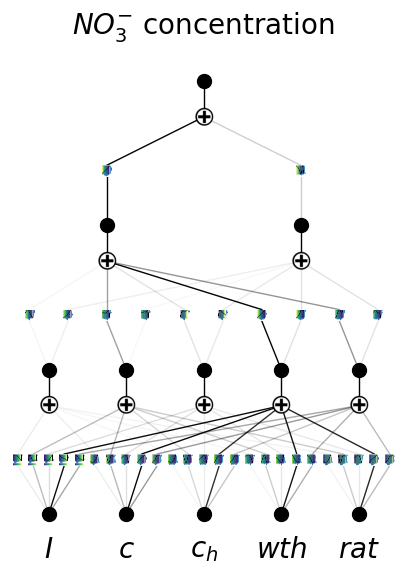

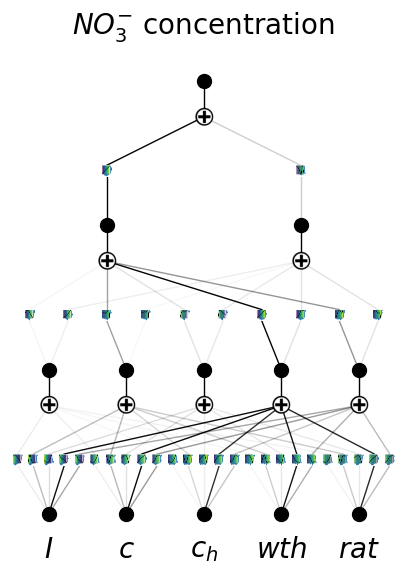

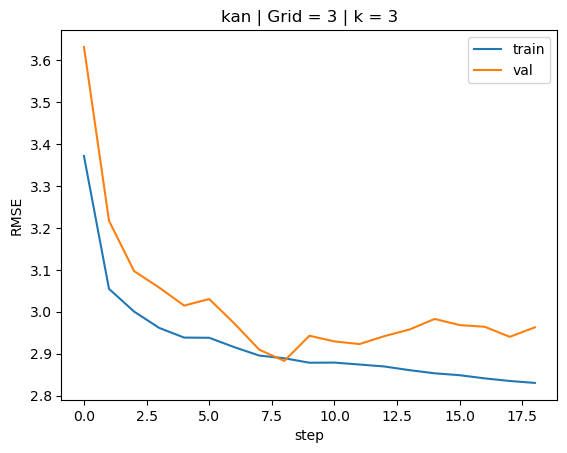

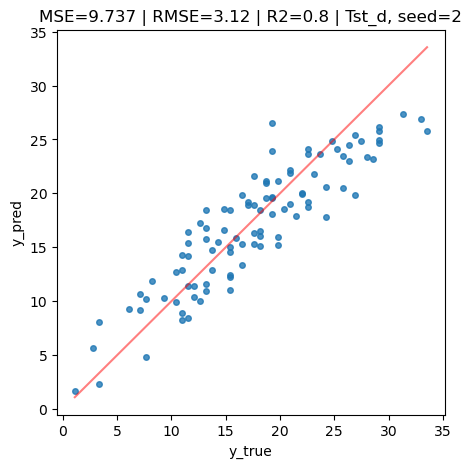

Full dataset:


ExactExplainer explainer: 1001it [00:47, 16.75it/s]                         


module of Input importance:


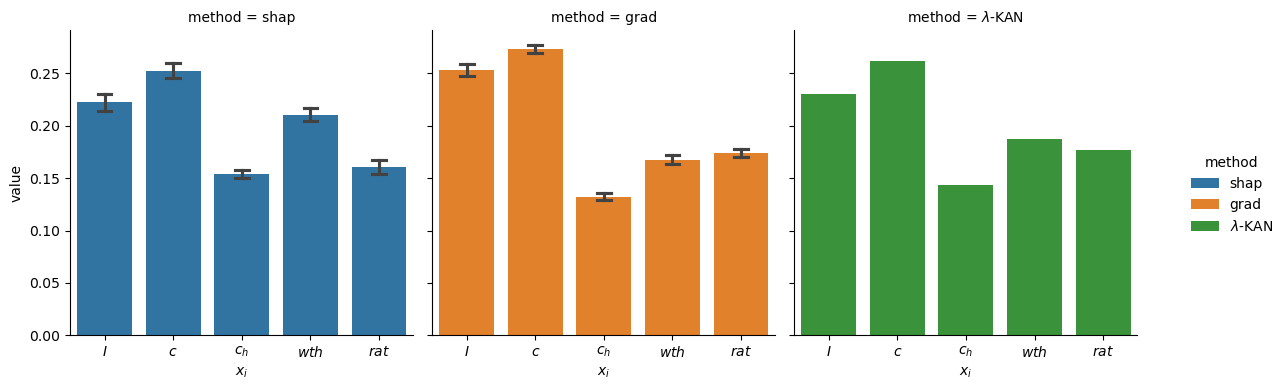

Input importance:


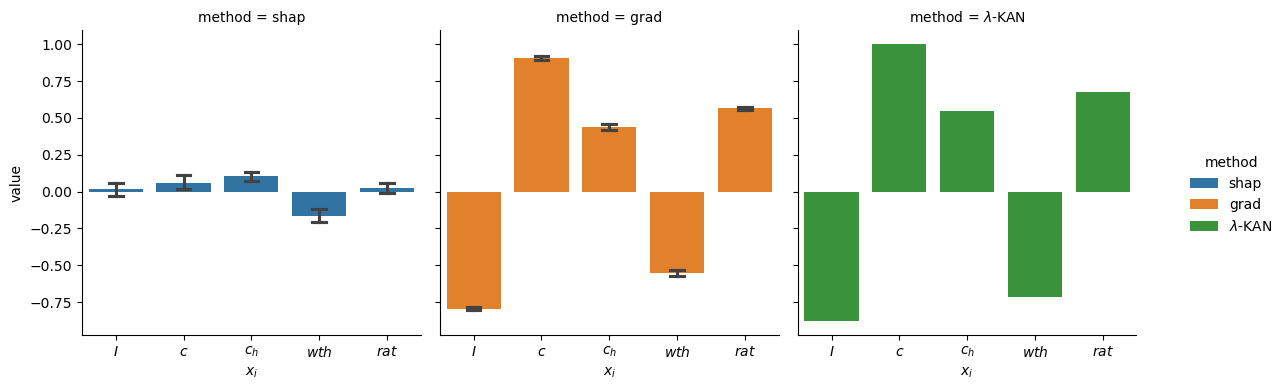

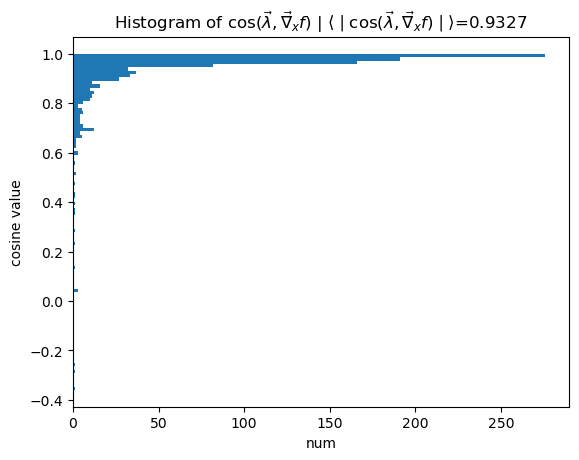

In [12]:
grid = 3
k = 3

# Choose seed and train again
seed = 2
print(f'==========\n- {seed=} -\n==========')
model2 = lmdKANRegressor(hidden_layer_sizes=[5,2,], seed=seed, grid=grid, k=k, 
                   solver="lbfgs", max_iter=100, 
                   lamb=1e-2,
                   lamb_l1=1,
                   lamb_entropy=2)

model2.fit(x_train, y_train)
result2 = model2.kan.results

#pred_test = model2.predict(x_test)
pred_train = model2.predict(x_train)
VAR = ['$I$', '$c$', '$c_h$', '$wth$', '$rat$']
prnt_kwrgs = {'in_vars': VAR, 
            'out_vars': [PREDICT_ION_NAME + ' concentration'], 
            'title': None,
            'sample': True,
            'scale': 0.5,
            'scale_scatter': 0.5}

model2.kan.plot(**prnt_kwrgs, reper_in_out='in', reper_index=0, hist_plot=True)
model2.kan.plot(**prnt_kwrgs, reper_in_out='out', reper_index=0, hist_plot=True)
plt.show()
plt.plot(result2['train_loss'])
plt.plot(result2['test_loss'])
#plt.plot(result2['reg'])
plt.legend(['train', 'val']) #, 'reg'
plt.title(f'kan | Grid = {grid} | k = {k}')
plt.ylabel('RMSE')
plt.xlabel('step')
plt.show()
scatter_prediction_skl(model2, x_test, y_test, f"Tst_d, seed={seed}")
print('Full dataset:')
importance_analyse_lmdKAN(model2.kan, dict(test_input=torch.tensor(scaler.transform(x), dtype=torch.float)))
plt.show()